First importing necessary libraries

In [1]:
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
print(tf.__version__)
%matplotlib inline
np.random.seed(1)

2.1.0


Part 1: Baseline Implementation of the workflow for CIFAR-10 image classification.<br>
1.1 Data Preparation:<br>
a. Load the CIFAR-10 data set. Find how many images are in training and testing set, respectively. Also, find what type of labeling is the data set using.

In [2]:
from tensorflow.keras.datasets import cifar10

(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

num_train, img_rows, img_cols, img_channels =  train_data.shape
print(train_data.shape)
num_test, _, _, _ =  test_data.shape

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

num_classes = len(np.unique(train_labels))

print("Number of images in Training :",num_train)
print("Number of images in Testing :",num_test)
print("Training labels shape :",train_labels.shape)
print("Number of unique classes in labels :", num_classes)
print(train_labels)

(50000, 32, 32, 3)
Number of images in Training : 50000
Number of images in Testing : 10000
Training labels shape : (50000, 1)
Number of unique classes in labels : 10
[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


As we can see we have 50000 number of training set and 10000 number of testing set and the labels are in format of 1 int per image within range of 0-9, that define its classes i.e. label encoding.<br>
b. Show the first 5 images in the training set, display them in one row, with the corresponding class label below each image.<br>
c. Show the first 5 images in the testing set, display them in a second row, with the corresponding class label below each image.

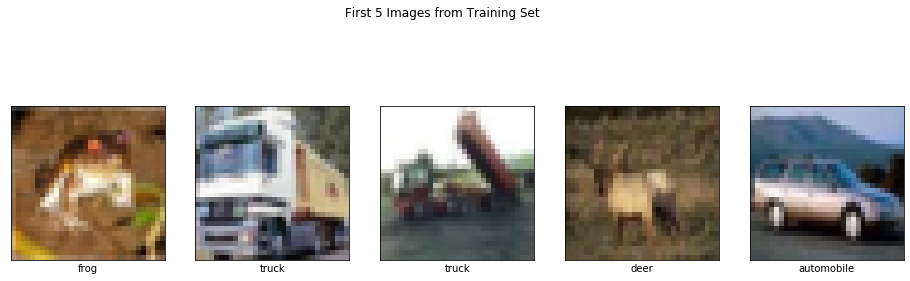

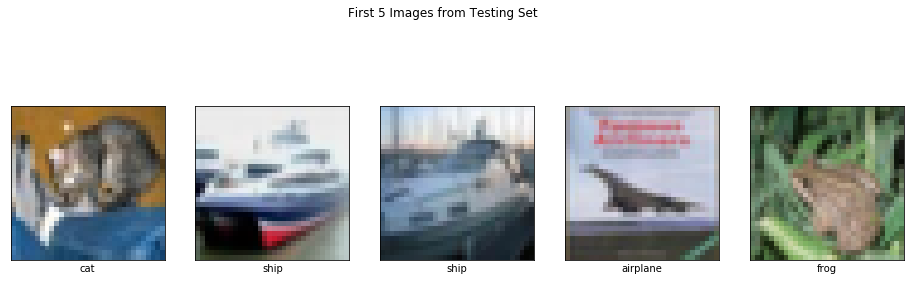

In [3]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)
fig1 = plt.figure()
fig1.suptitle('First 5 Images from Training Set')
for i in range(5):
    ax = plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    ax.imshow(train_data[i], cmap=plt.cm.binary)
    ax.set_xlabel(class_names[train_labels[i][0]])


fig2 = plt.figure()
fig2.suptitle('First 5 Images from Testing Set')
for i in range(5):
    ax = plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    ax.imshow(test_data[i], cmap=plt.cm.binary)
    ax.set_xlabel(class_names[test_labels[i][0]])
plt.show()

d. Normalize all image pixels to the range of 0-1.

In [4]:
train_data = train_data.astype(float) / 255
test_data = test_data.astype(float) / 255

1.2 Model Selection:<br>
a. Build a CNN model with the following structure:<br>
i. Three convolutional layers with 16, 32, and 64 3x3 filters and Relu activations. Each output feature map should have the same dimension as the input to this layer. Each Conv layer is followed by a 2x2 Maxpooling layer with stride of 2.<br>
ii. A Fully Connected layers with 1024 neurons.

In [5]:
def build_model():
    
    model = keras.Sequential([
        layers.Conv2D(16, kernel_size=(3, 3), padding = 'same', activation='relu',
                      input_shape = (img_rows, img_cols, img_channels)),
        
        layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = 'same'),
        
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = 'same'),
        
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = 'same'),
        
        layers.Flatten(),
        
        layers.Dense(1024),
        
        layers.Dense(10, activation = 'softmax')
    ])
    
    adam = keras.optimizers.Adam(learning_rate = 0.0001)
    los = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    
    model.compile(optimizer = adam, loss = los, metrics = ['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

b. Before training the above model, test your model with the first image in the testing set, print out the predicted probability for each class, and find the cross entropy loss of the untrained model for this testing sample. Verify this loss is approximately log(C).

In [6]:
history = model.predict(np.expand_dims(test_data[0,:,:], axis=0))

In [7]:
for i in range(len(class_names)):
    print('Probability for class', class_names[i],'is', history[:,i])

print('\nMax Probability index is',np.argmax(history),'i.e.',class_names[np.argmax(history)])

Probability for class airplane is [0.09562517]
Probability for class automobile is [0.10928748]
Probability for class bird is [0.10476846]
Probability for class cat is [0.11054724]
Probability for class deer is [0.10583138]
Probability for class dog is [0.09955515]
Probability for class frog is [0.08656115]
Probability for class horse is [0.09004904]
Probability for class ship is [0.10018664]
Probability for class truck is [0.09758826]

Max Probability index is 3 i.e. cat


In [8]:
cel = model.evaluate(np.expand_dims(test_data[0,:,:], axis=0), test_labels[0,:], verbose = 0, use_multiprocessing = True)
print('Cross entropy Loss for this image is', cel[0], 'comparing to log(C=10) i.e.',math.log(10))

Cross entropy Loss for this image is 2.2920658588409424 comparing to log(C=10) i.e. 2.302585092994046


1.3 Model Training:<br>
a. Use default hyperparameter values, train the model for 20 epochs. validate after each epoch.

In [9]:
num_epochs = 20

all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

train_data_temp, test_data_temp, train_labels_temp, test_labels_temp = train_test_split(train_data, train_labels,
                                                                                        test_size=0.3)

model = build_model()
history = model.fit(train_data_temp, train_labels_temp, validation_data=(test_data_temp, test_labels_temp), epochs=num_epochs)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 136us/sample - loss: 2.1335 - accuracy: 0.3257 - val_loss: 2.0610 - val_accuracy: 0.4008
Epoch 2/20
50000/50000 [==============================] - 6s 127us/sample - loss: 2.0473 - accuracy: 0.4128 - val_loss: 2.0258 - val_accuracy: 0.4348
Epoch 3/20
50000/50000 [==============================] - 9s 174us/sample - loss: 2.0125 - accuracy: 0.4482 - val_loss: 1.9861 - val_accuracy: 0.4778
Epoch 4/20
50000/50000 [==============================] - 7s 137us/sample - loss: 1.9662 - accuracy: 0.4990 - val_loss: 1.9556 - val_accuracy: 0.5070
Epoch 5/20
50000/50000 [==============================] - 7s 137us/sample - loss: 1.9407 - accuracy: 0.5239 - val_loss: 1.9299 - val_accuracy: 0.5370
Epoch 6/20
50000/50000 [==============================] - 7s 136us/sample - loss: 1.9195 - accuracy: 0.5453 - val_loss: 1.9142 - val_accuracy: 0.5513
Epoch 7/20
50000/50000 [==========================

b. Plot the training loss and validation loss curves in one figure, and training accuracy and validation accuracy curves in another figure.

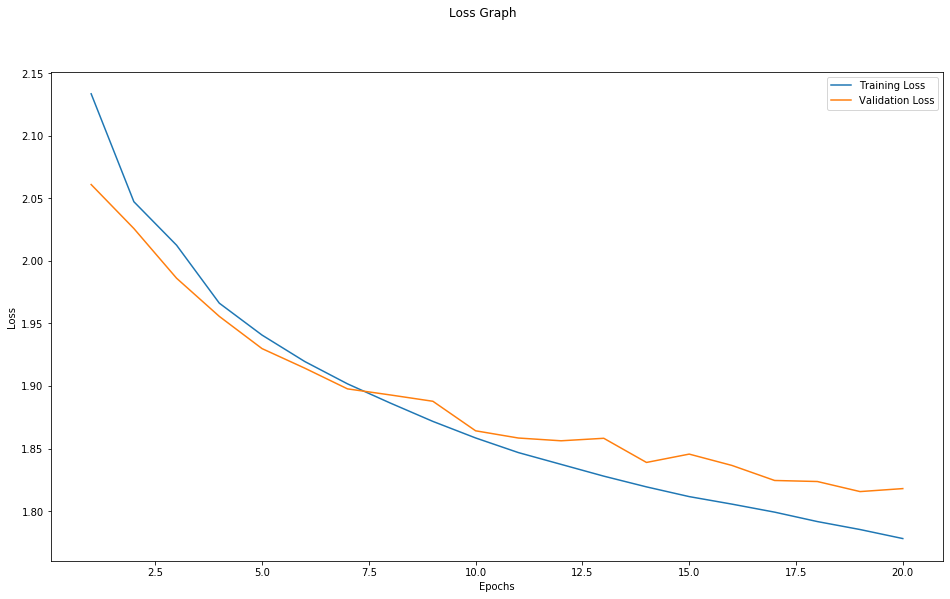

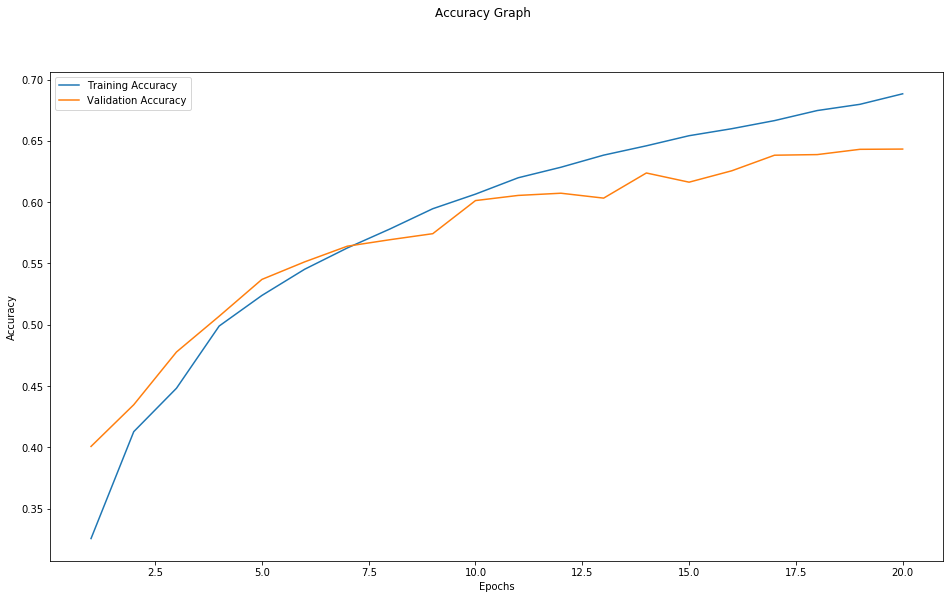

Smooth curve graphs of above graphs


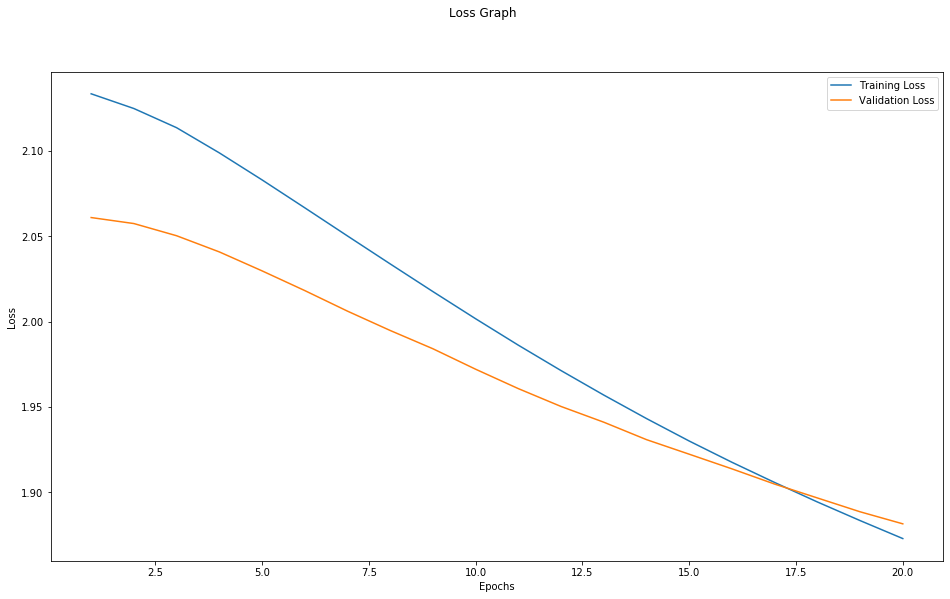

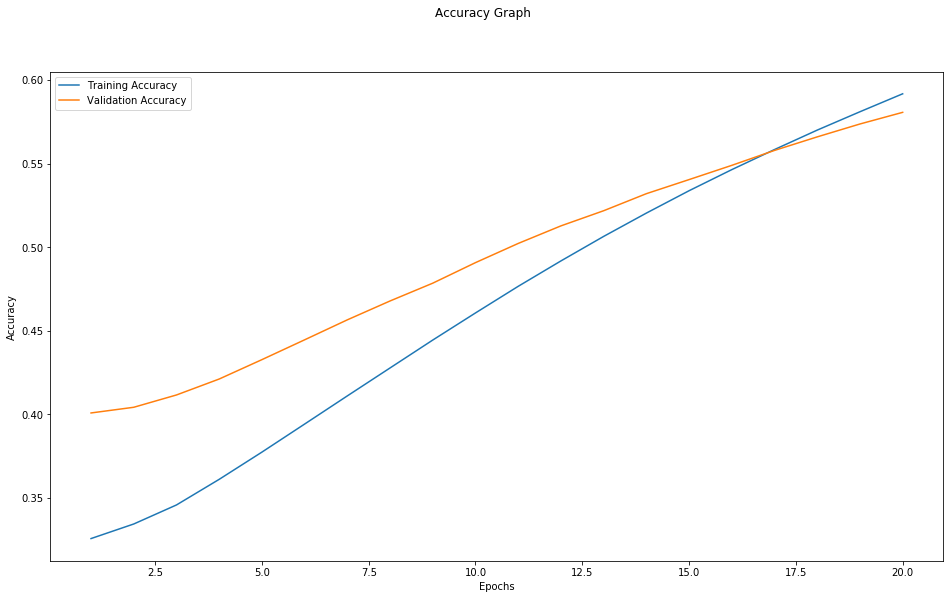

In [10]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories):
    plt.rcParams['figure.figsize'] = (16.0, 9.0)
    
    # Averaging Total fold's accuracy into 1
    average_accuracy_history = [np.mean([x[i] for x in all_accuracy_histories]) for i in range(num_epochs)]
    average_val_accuracy_history = [np.mean([x[i] for x in all_val_accuracy_histories]) for i in range(num_epochs)]
    average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
    average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
    
    #plotting training and validation loss into 1 graph
    plt.plot(range(1, len(average_loss_history) + 1), average_loss_history, label = 'Training Loss')
    plt.plot(range(1, len(average_val_loss_history) + 1), average_val_loss_history, label = 'Validation Loss')
    plt.suptitle('Loss Graph')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    #plotting training and validation accuracy into 1 graph
    plt.plot(range(1, len(average_accuracy_history) + 1), average_accuracy_history, label = 'Training Accuracy')
    plt.plot(range(1, len(average_val_accuracy_history) + 1), average_val_accuracy_history, label = 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.suptitle('Accuracy Graph')
    plt.legend()
    plt.show()
    
    #plotting smooth curve graphs of loss graph
    print('Smooth curve graphs of above graphs')
    smooth_loss_history = smooth_curve(average_loss_history)
    plt.plot(range(1, len(smooth_loss_history) + 1), smooth_loss_history, label = 'Training Loss')

    smooth_val_loss_history = smooth_curve(average_val_loss_history)
    plt.plot(range(1, len(smooth_val_loss_history) + 1), smooth_val_loss_history, label = 'Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.suptitle('Loss Graph')
    plt.legend()
    plt.show()
    
    #plotting smooth curve graph of accuracy graph
    smooth_accuracy_history = smooth_curve(average_accuracy_history)
    plt.plot(range(1, len(smooth_accuracy_history) + 1), smooth_accuracy_history, label = 'Training Accuracy')

    smooth_val_accuracy_history = smooth_curve(average_val_accuracy_history)
    plt.plot(range(1, len(smooth_val_accuracy_history) + 1), smooth_val_accuracy_history, label = 'Validation Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.suptitle('Accuracy Graph')
    plt.legend()
    plt.show()
    
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

1.4Model Evaluation:

a. Use testing data set to evaluate the testing accuracy of the trained model.

In [11]:
test_loss_score, test_accuracy_score = model.evaluate(test_data, test_labels, verbose = 0)
print("Testing loss",test_loss_score," Accuracy",test_accuracy_score*100,"%")

Testing loss 1.8179509113311767  Accuracy 64.32999968528748 %


1.5 Prediction:<br>
a. Generate the class label for the first image in the testing set using the trained model. Display the predicted probability for each class, and calculate the cross-entropy loss of the trained model for this testing sample. Compare the results with those of the untrained model in 1.2.b.

In [12]:
history = model.predict(np.expand_dims(test_data[0,:,:], axis=0))

for i in range(10):
    print('Probability for class', class_names[i],'is', history[:,i])

print('\nMax Probability index is',np.argmax(history),'i.e.',class_names[np.argmax(history)])
print('\nWhile original label class of the image is ',class_names[test_labels[0,:][0]])

cel = model.evaluate(np.expand_dims(test_data[0,:,:], axis=0), test_labels[0,:], verbose = 0)
print('\nCross entropy Loss for this image is', cel[0], 'comparing to Loss before Training i.e.',math.log(10))

Probability for class airplane is [2.1509886e-06]
Probability for class automobile is [5.333182e-09]
Probability for class bird is [5.0108683e-05]
Probability for class cat is [0.97202545]
Probability for class deer is [1.098455e-08]
Probability for class dog is [0.02781241]
Probability for class frog is [1.13951046e-07]
Probability for class horse is [6.4940436e-13]
Probability for class ship is [0.00010975]
Probability for class truck is [2.2472049e-11]

Max Probability index is 3 i.e. cat

While original label class of the image is  cat

Cross entropy Loss for this image is 1.485137939453125 comparing to Loss before Training i.e. 2.302585092994046


Part 2: Additional functionalities.<br>
2.1 Accuracy analysis<br>
Generate a confusion table for the model testing. The rows of the table is the ground truth of labels, while the column is the model output labels. So the Nij in the table indicate the number of testing images with ground truth label i, but being classified as label j by the trained model.

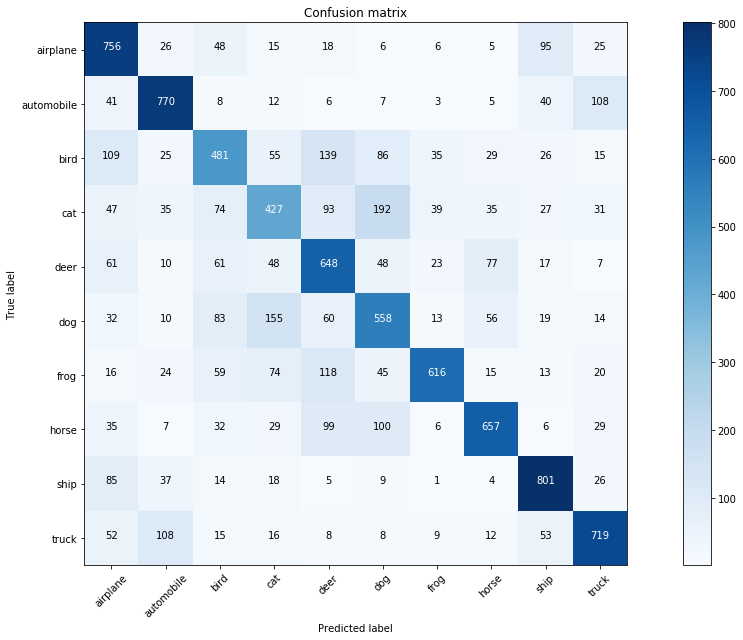

In [13]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

predictions = model.predict_classes(test_data)
ax = confusion_matrix(test_labels[:,0], predictions)
plt.figure()
plot_confusion_matrix(ax, classes=class_names, title='Confusion matrix')

2.2Model visualization<br>
a. Display the 16 trained filters in the first conv layer as images.

Shape of this layer's filters (3, 3, 3, 16)
Double Click To Zoom


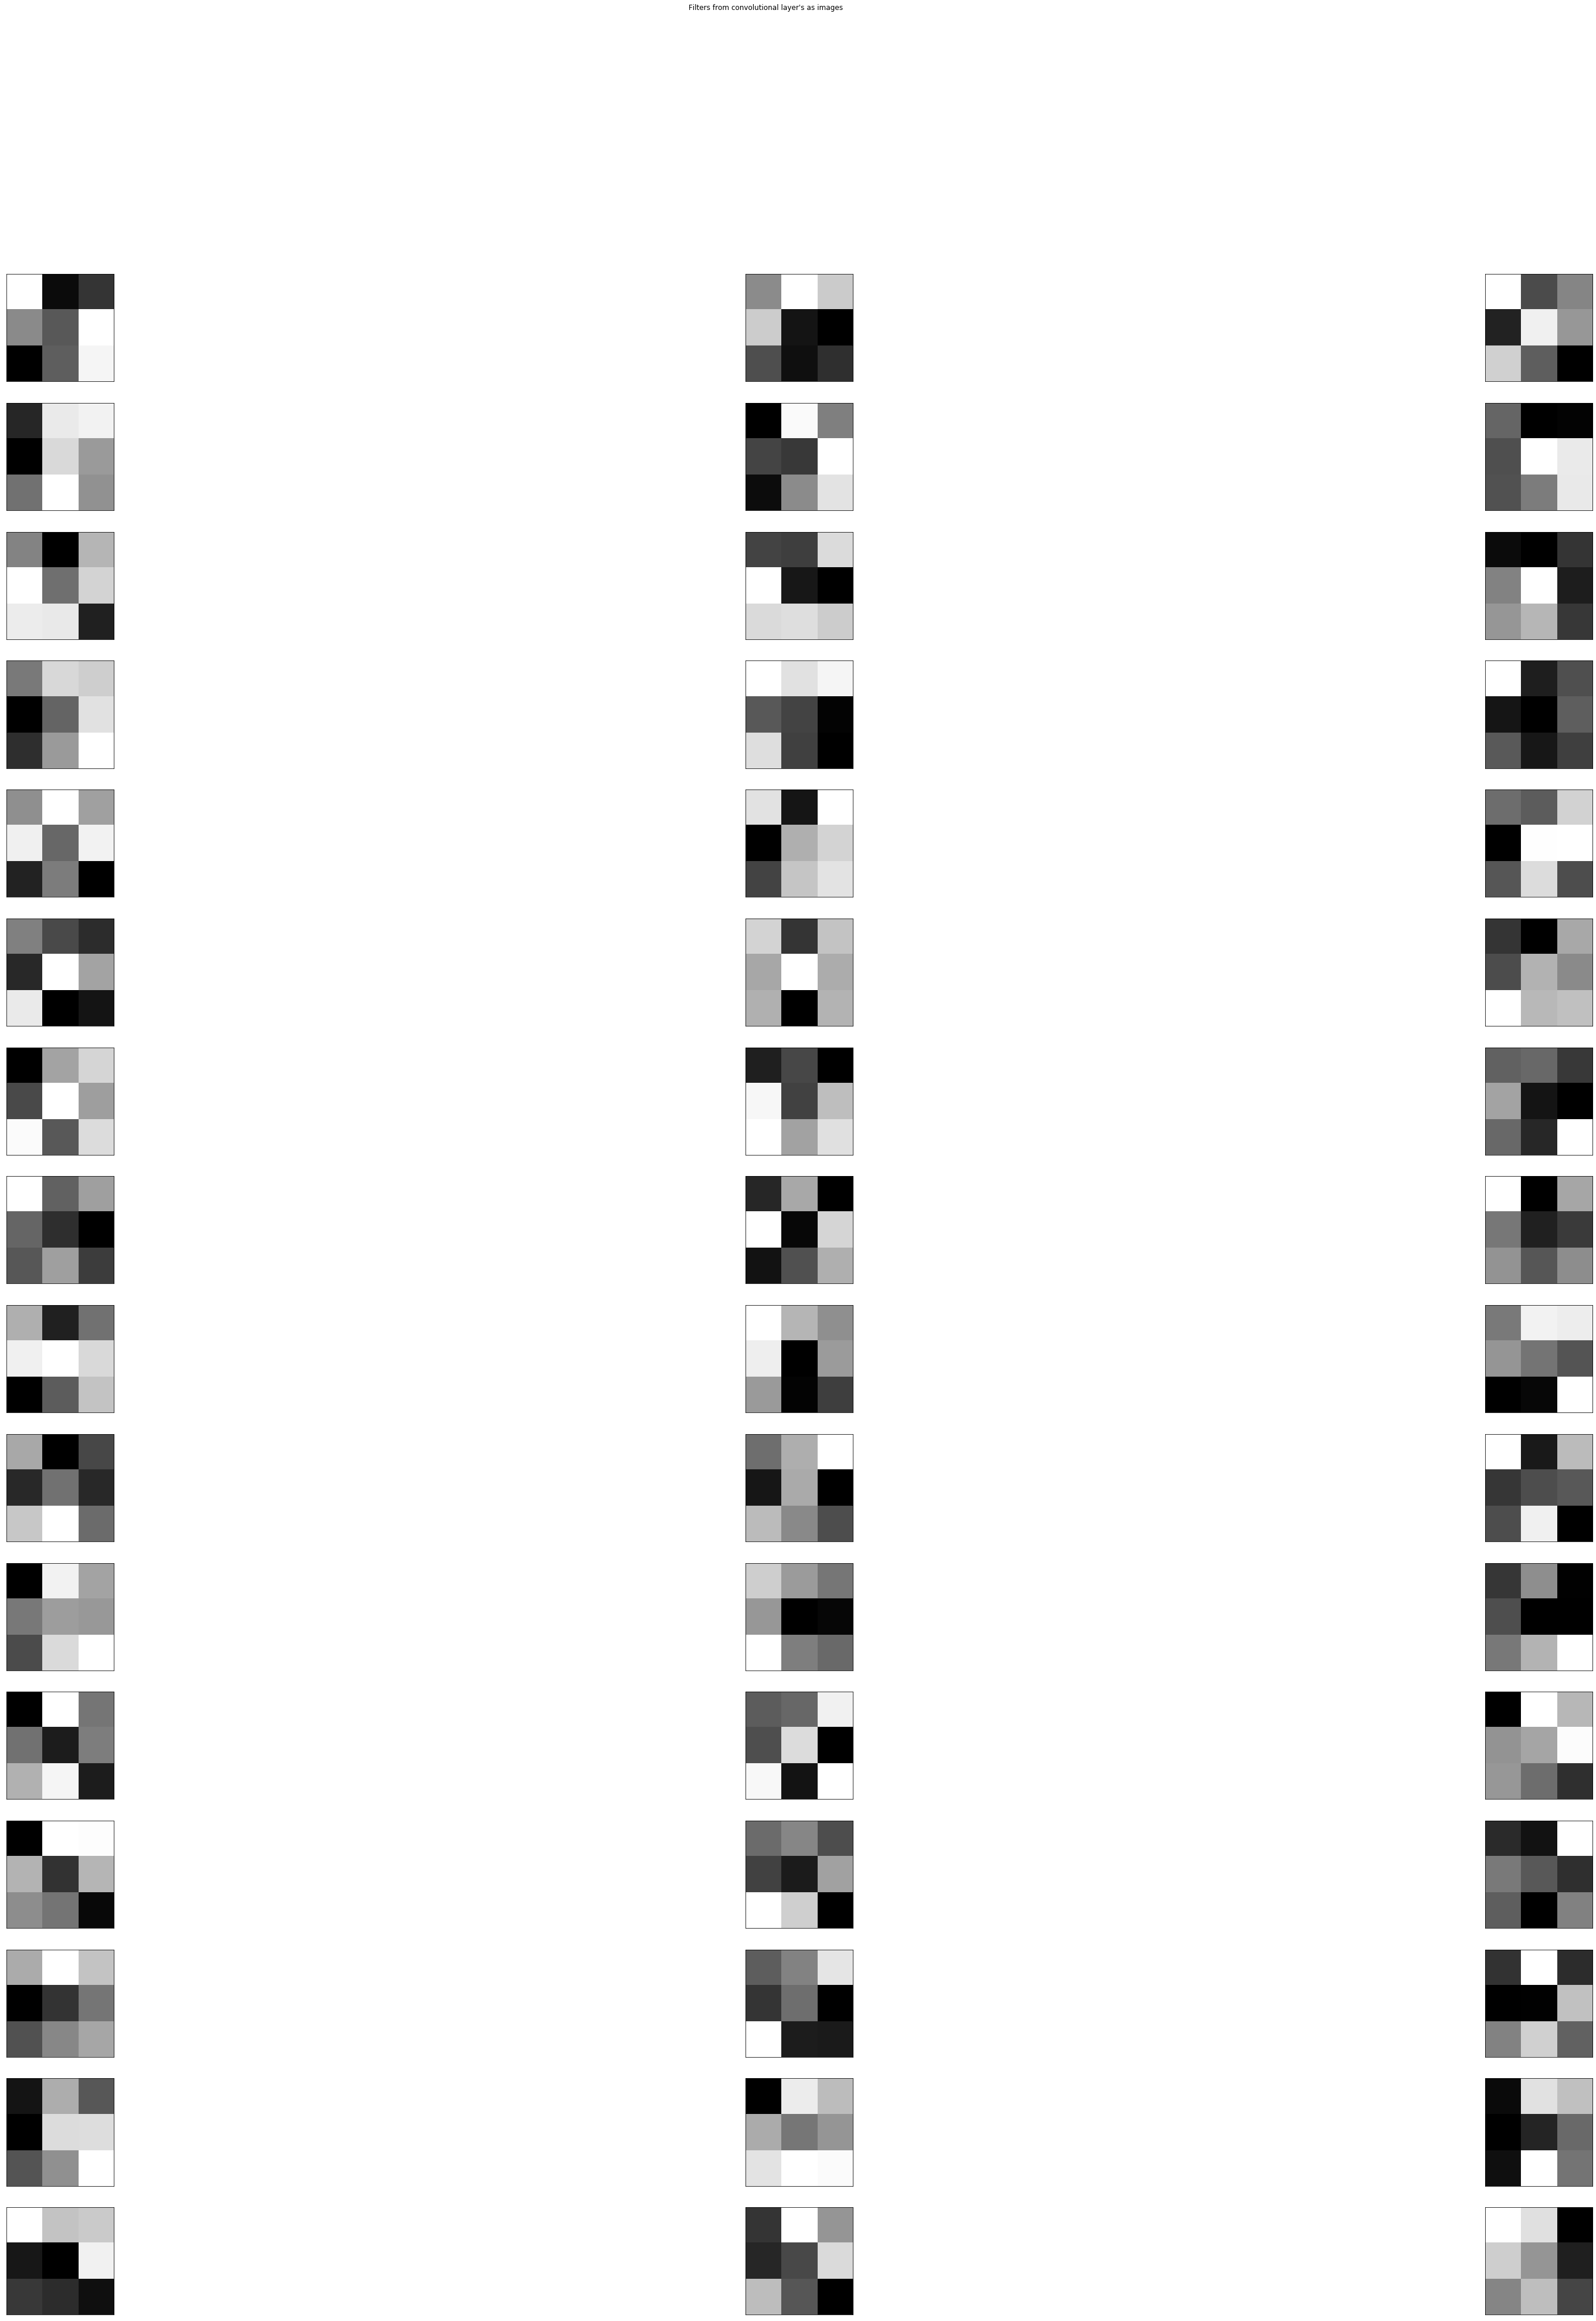

Shape of this layer's filters (3, 3, 16, 32)
Double Click To Zoom


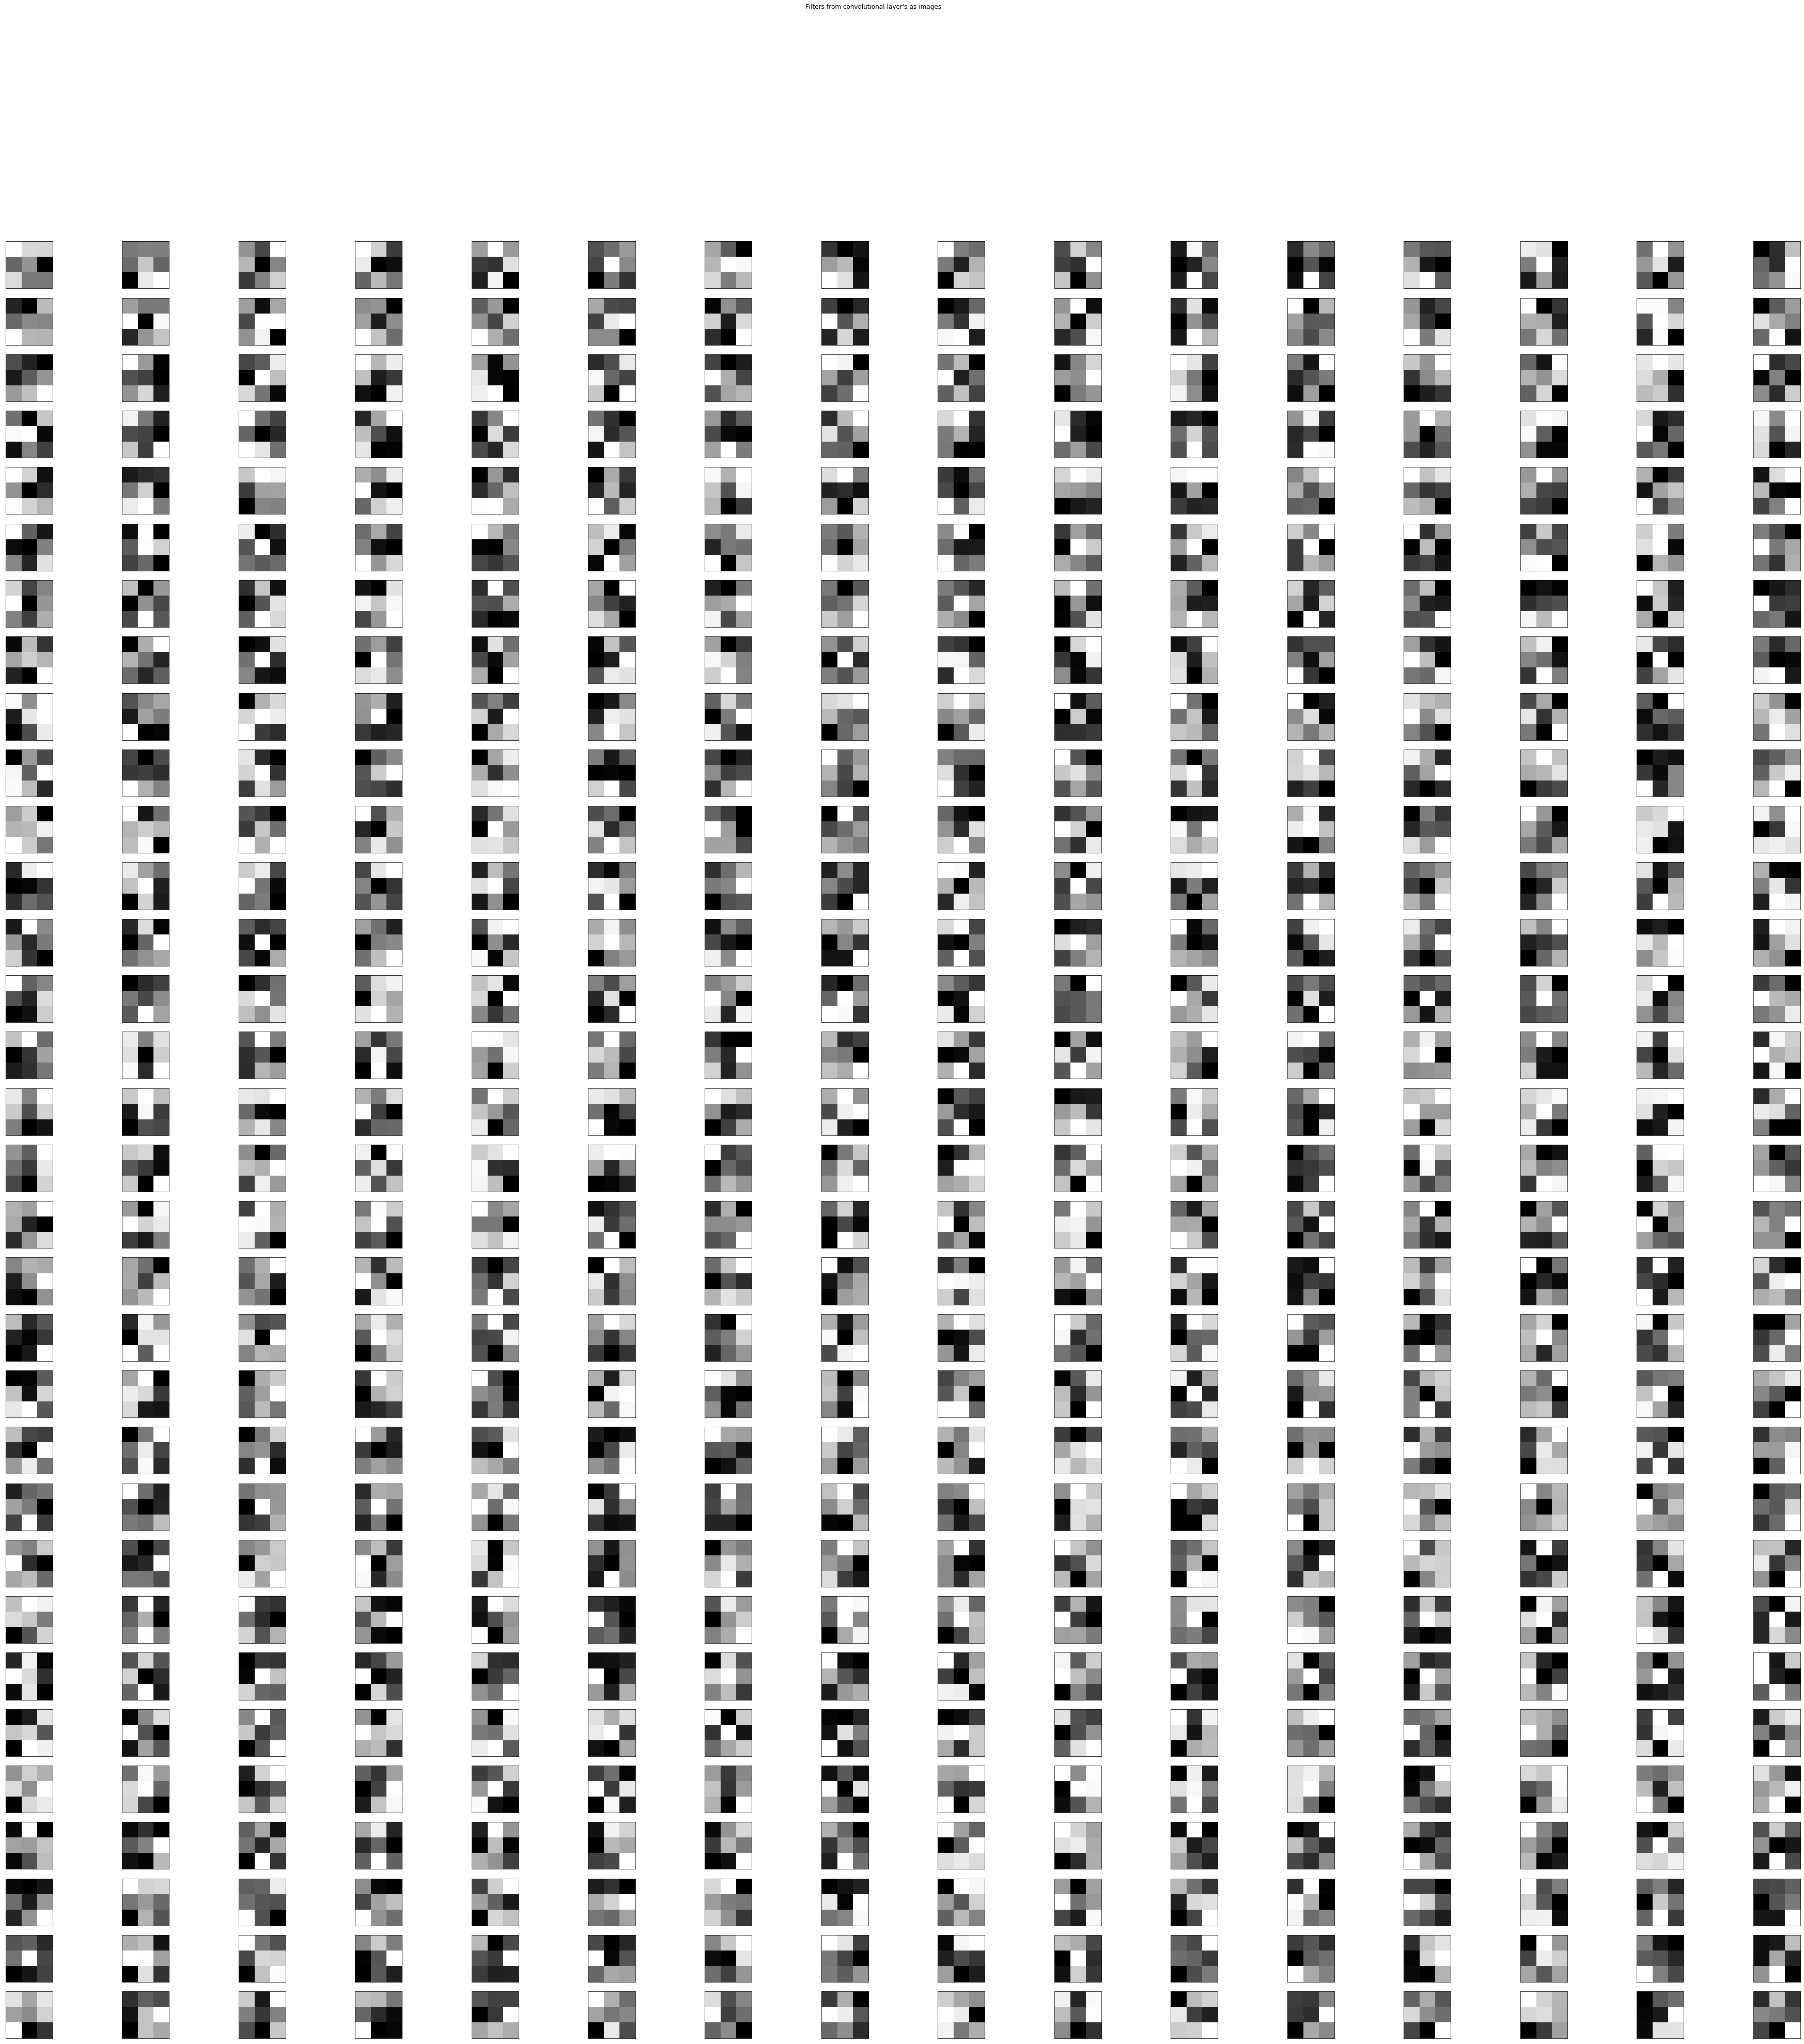

Shape of this layer's filters (3, 3, 32, 64)
Double Click To Zoom


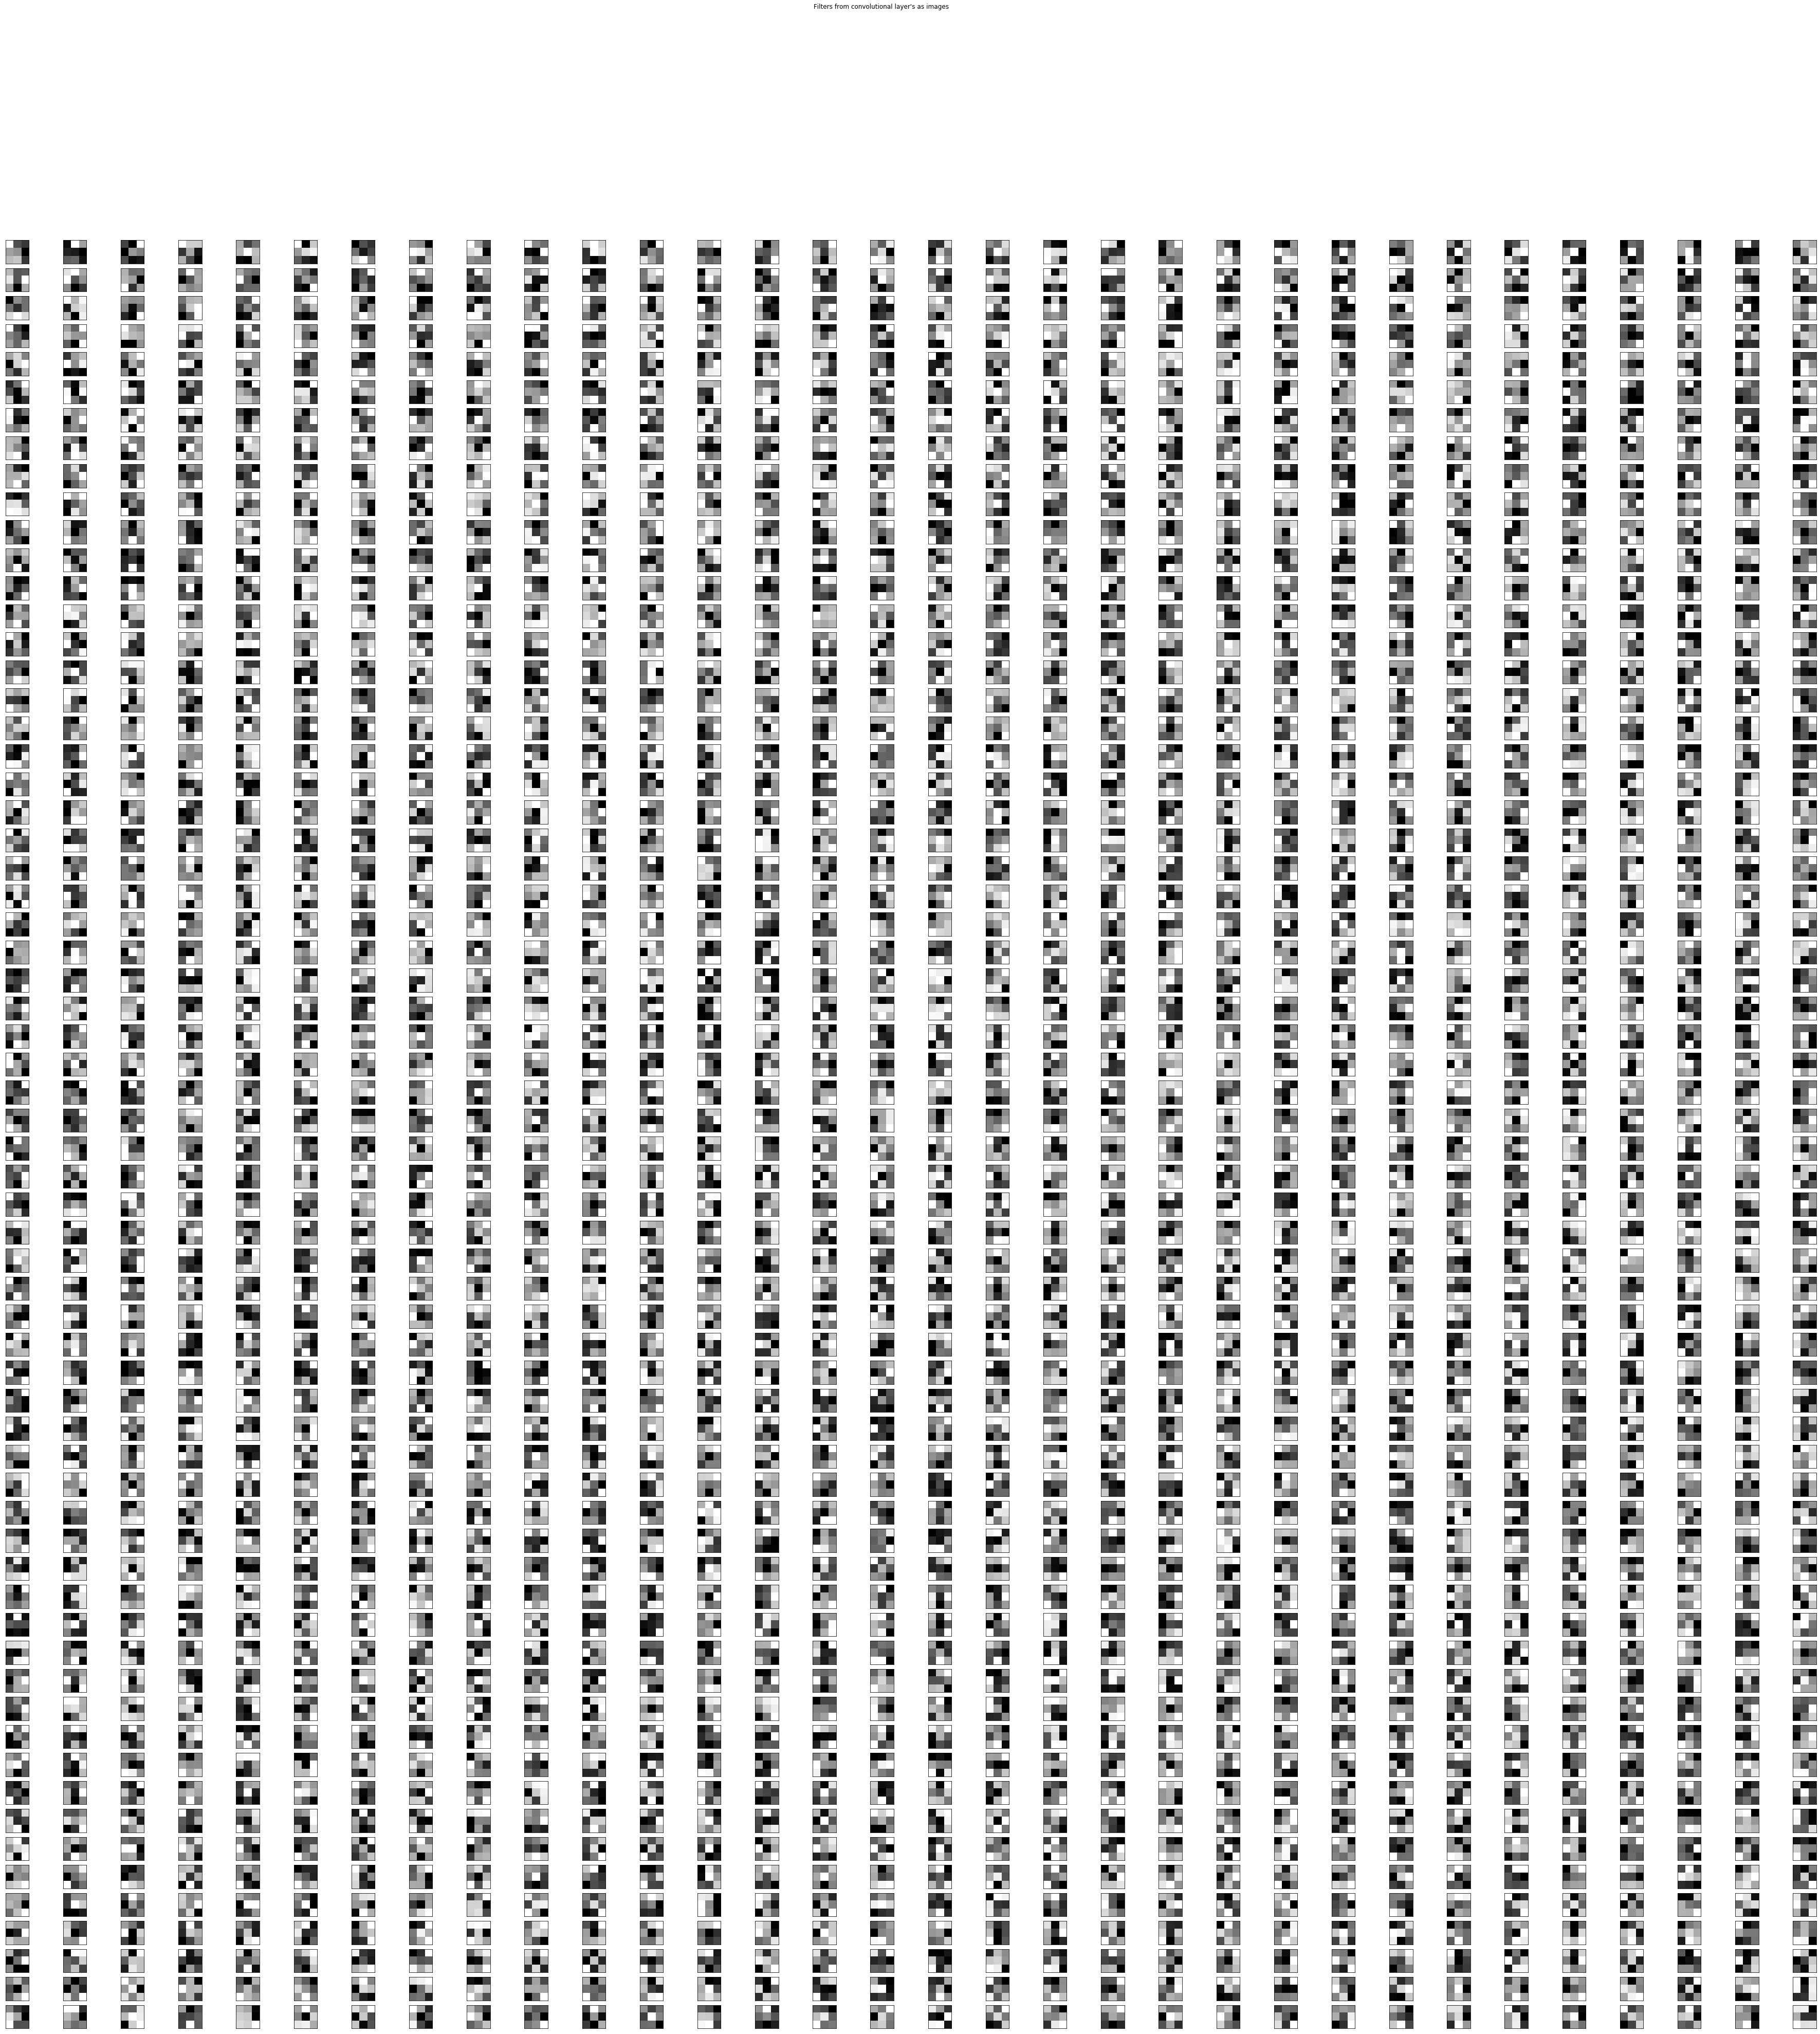

In [14]:
def plot_filters(filters):
    n_filters = filters.shape[-1]
    # Normalized filters to set them between 0 - 1
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    fig = plt.figure()
    fig.suptitle('Filters from convolutional layer\'s as images')
    for i in range(n_filters):
        for j in range(filters.shape[-2]):
            ax = plt.subplot(n_filters, filters.shape[-2], i*(filters.shape[-2]) + j + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(filters[:, :, j, i], cmap = 'gray')
    plt.show()

# plotting filters of every convolutional layer
for layer in model.layers:
    if 'conv' not in layer.name:
        continue
    filters, _ = layer.get_weights()
    plt.rcParams['figure.figsize'] = (64.0, 64.0)
    print('Shape of this layer\'s filters',filters.shape)
    print("Double Click To Zoom")
    plot_filters(filters)

b. Display the 16 feature maps as images from the first conv layer generated for the first testing image.

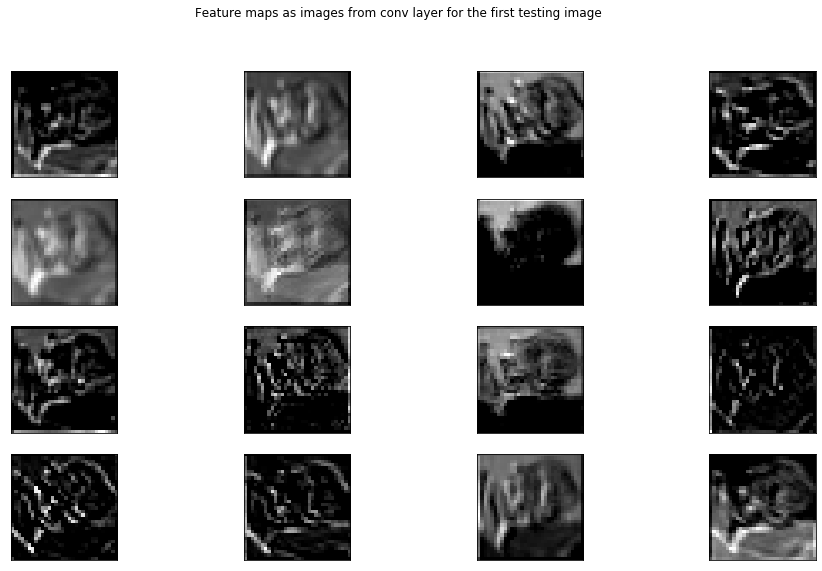

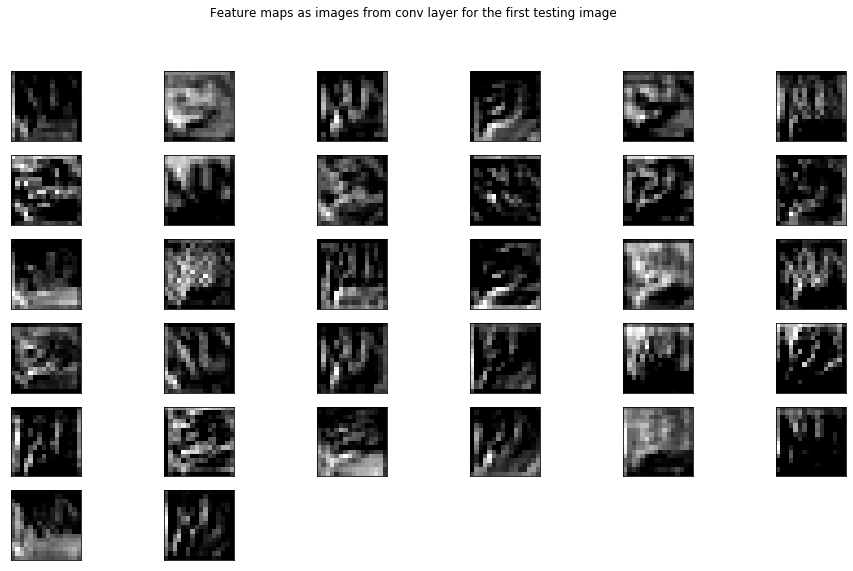

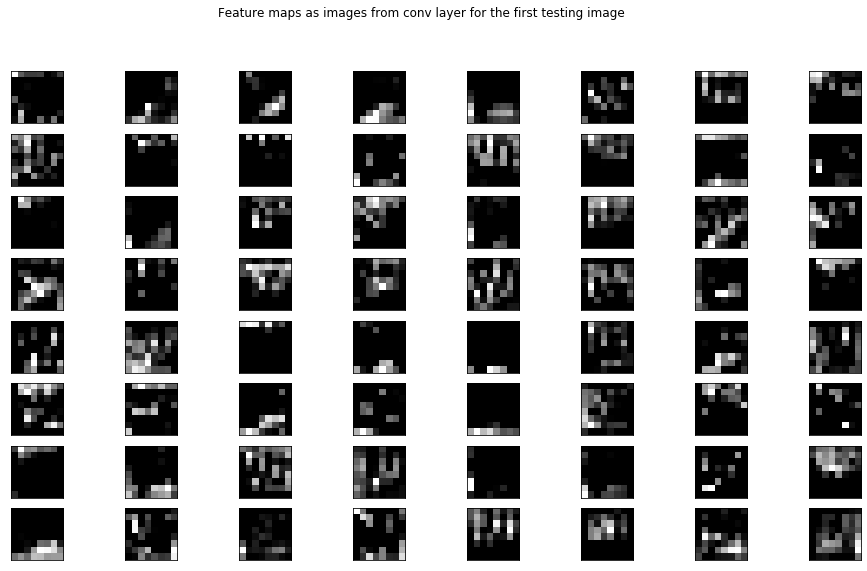

In [15]:
def plot_feature_maps(feature_maps):
    plt.rcParams['figure.figsize'] = (16.0, 9.0)
    n_filters = feature_maps.shape[-1]
    fig = plt.figure()
    fig.suptitle('Feature maps as images from conv layer for the first testing image')
    for i in range(n_filters):
        ax = plt.subplot(math.ceil(math.sqrt(n_filters)), math.ceil(math.sqrt(n_filters)), i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, i], cmap= 'gray')
    plt.show()

#plotting feature map after every convolutional layer
for i in range(len(model.layers)):
    if 'conv' not in model.layers[i].name:
        continue
    temp_model = models.Model(inputs = model.inputs, outputs = model.layers[i].output)
    feature_maps = temp_model.predict(np.expand_dims(test_data[0,:,:], axis=0))
    plot_feature_maps(feature_maps)

2.3 Overfitting observation<br>
a. Use a small set of training images (100) to run the same implementation as in Part 1. Plot the training and validation loss curves in a single figure. Find out the number of epochs it takes to overfitting.

In [16]:
num_epochs = 500

all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

# Randomly Choosing 100 samples from training set
train_data_temp, test_data_temp, train_labels_temp, test_labels_temp = train_test_split(train_data, train_labels,
                                                                                        test_size=0.998)

# Randomly choosing 25 samples from remaining data points i.e. from 49,900 points.
_, test_data_temp, _, test_labels_temp = train_test_split(test_data_temp, test_labels_temp, test_size=0.0005)

model = build_model()
history = model.fit(train_data_temp, train_labels_temp,validation_data=(test_data_temp, test_labels_temp),
                    epochs=num_epochs)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Train on 100 samples, validate on 25 samples
Epoch 1/500
100/100 [==============================] - 1s 6ms/sample - loss: 2.3016 - accuracy: 0.1300 - val_loss: 2.2997 - val_accuracy: 0.0400
Epoch 2/500
100/100 [==============================] - 0s 259us/sample - loss: 2.2930 - accuracy: 0.1200 - val_loss: 2.2932 - val_accuracy: 0.2000
Epoch 3/500
100/100 [==============================] - 0s 259us/sample - loss: 2.2875 - accuracy: 0.1300 - val_loss: 2.2861 - val_accuracy: 0.2000
Epoch 4/500
100/100 [==============================] - 0s 239us/sample - loss: 2.2811 - accuracy: 0.1300 - val_loss: 2.2797 - val_accuracy: 0.2000
Epoch 5/500
100/100 [==============================] - 0s 239us/sample - loss: 2.2749 - accuracy: 0.1600 - val_loss: 2.2744 - val_accuracy: 0.3200
Epoch 6/500
100/100 [==============================] - 0s 239us/sample - loss: 2.2673 - accuracy: 0.2800 - val_loss: 2.2672 - val_accuracy: 0.3200
Epoch 7/500
100/100 [==============================] - 0s 229us/sample - lo

100/100 [==============================] - 0s 229us/sample - loss: 1.9207 - accuracy: 0.5900 - val_loss: 2.1362 - val_accuracy: 0.3600
Epoch 112/500
100/100 [==============================] - 0s 239us/sample - loss: 1.9154 - accuracy: 0.5700 - val_loss: 2.1271 - val_accuracy: 0.4000
Epoch 113/500
100/100 [==============================] - 0s 239us/sample - loss: 1.9039 - accuracy: 0.6000 - val_loss: 2.1372 - val_accuracy: 0.3200
Epoch 114/500
100/100 [==============================] - 0s 239us/sample - loss: 1.9001 - accuracy: 0.5900 - val_loss: 2.1300 - val_accuracy: 0.3200
Epoch 115/500
100/100 [==============================] - 0s 220us/sample - loss: 1.9144 - accuracy: 0.5800 - val_loss: 2.1382 - val_accuracy: 0.3200
Epoch 116/500
100/100 [==============================] - 0s 229us/sample - loss: 1.9206 - accuracy: 0.5700 - val_loss: 2.1377 - val_accuracy: 0.3200
Epoch 117/500
100/100 [==============================] - 0s 229us/sample - loss: 1.8907 - accuracy: 0.6000 - val_loss: 2

100/100 [==============================] - 0s 229us/sample - loss: 1.8104 - accuracy: 0.6600 - val_loss: 2.1587 - val_accuracy: 0.2800
Epoch 167/500
100/100 [==============================] - 0s 230us/sample - loss: 1.8128 - accuracy: 0.6600 - val_loss: 2.1600 - val_accuracy: 0.2800
Epoch 168/500
100/100 [==============================] - 0s 229us/sample - loss: 1.8155 - accuracy: 0.6600 - val_loss: 2.1616 - val_accuracy: 0.2800
Epoch 169/500
100/100 [==============================] - 0s 229us/sample - loss: 1.8096 - accuracy: 0.6600 - val_loss: 2.1594 - val_accuracy: 0.3200
Epoch 170/500
100/100 [==============================] - 0s 249us/sample - loss: 1.8089 - accuracy: 0.6700 - val_loss: 2.1665 - val_accuracy: 0.3200
Epoch 171/500
100/100 [==============================] - 0s 229us/sample - loss: 1.8083 - accuracy: 0.6600 - val_loss: 2.1763 - val_accuracy: 0.2800
Epoch 172/500
100/100 [==============================] - 0s 229us/sample - loss: 1.8169 - accuracy: 0.6600 - val_loss: 2

100/100 [==============================] - 0s 229us/sample - loss: 1.7738 - accuracy: 0.6900 - val_loss: 2.1683 - val_accuracy: 0.3200
Epoch 222/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7737 - accuracy: 0.6900 - val_loss: 2.1668 - val_accuracy: 0.3200
Epoch 223/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7747 - accuracy: 0.6900 - val_loss: 2.1668 - val_accuracy: 0.3200
Epoch 224/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7736 - accuracy: 0.6900 - val_loss: 2.1677 - val_accuracy: 0.3200
Epoch 225/500
100/100 [==============================] - 0s 239us/sample - loss: 1.7731 - accuracy: 0.6900 - val_loss: 2.1691 - val_accuracy: 0.2800
Epoch 226/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7731 - accuracy: 0.6900 - val_loss: 2.1691 - val_accuracy: 0.2800
Epoch 227/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7724 - accuracy: 0.6900 - val_loss: 2

100/100 [==============================] - 0s 239us/sample - loss: 1.7678 - accuracy: 0.6900 - val_loss: 2.1756 - val_accuracy: 0.2800
Epoch 277/500
100/100 [==============================] - 0s 250us/sample - loss: 1.7679 - accuracy: 0.6900 - val_loss: 2.1732 - val_accuracy: 0.2800
Epoch 278/500
100/100 [==============================] - 0s 239us/sample - loss: 1.7677 - accuracy: 0.6900 - val_loss: 2.1725 - val_accuracy: 0.2800
Epoch 279/500
100/100 [==============================] - 0s 239us/sample - loss: 1.7673 - accuracy: 0.6900 - val_loss: 2.1725 - val_accuracy: 0.3200
Epoch 280/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7674 - accuracy: 0.6900 - val_loss: 2.1720 - val_accuracy: 0.3200
Epoch 281/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7673 - accuracy: 0.6900 - val_loss: 2.1703 - val_accuracy: 0.3200
Epoch 282/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7672 - accuracy: 0.6900 - val_loss: 2

100/100 [==============================] - 0s 229us/sample - loss: 1.7601 - accuracy: 0.7000 - val_loss: 2.1691 - val_accuracy: 0.2800
Epoch 332/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7587 - accuracy: 0.7000 - val_loss: 2.1654 - val_accuracy: 0.3200
Epoch 333/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7583 - accuracy: 0.7000 - val_loss: 2.1654 - val_accuracy: 0.3200
Epoch 334/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7582 - accuracy: 0.7000 - val_loss: 2.1669 - val_accuracy: 0.3200
Epoch 335/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7578 - accuracy: 0.7000 - val_loss: 2.1680 - val_accuracy: 0.3200
Epoch 336/500
100/100 [==============================] - 0s 249us/sample - loss: 1.7575 - accuracy: 0.7000 - val_loss: 2.1685 - val_accuracy: 0.2800
Epoch 337/500
100/100 [==============================] - 0s 239us/sample - loss: 1.7572 - accuracy: 0.7000 - val_loss: 2

100/100 [==============================] - 0s 229us/sample - loss: 1.7483 - accuracy: 0.7100 - val_loss: 2.1843 - val_accuracy: 0.2400
Epoch 387/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7482 - accuracy: 0.7100 - val_loss: 2.1846 - val_accuracy: 0.2400
Epoch 388/500
100/100 [==============================] - 0s 239us/sample - loss: 1.7489 - accuracy: 0.7100 - val_loss: 2.1818 - val_accuracy: 0.2800
Epoch 389/500
100/100 [==============================] - 0s 220us/sample - loss: 1.7487 - accuracy: 0.7100 - val_loss: 2.1797 - val_accuracy: 0.2800
Epoch 390/500
100/100 [==============================] - 0s 239us/sample - loss: 1.7478 - accuracy: 0.7100 - val_loss: 2.1790 - val_accuracy: 0.2800
Epoch 391/500
100/100 [==============================] - 0s 239us/sample - loss: 1.7476 - accuracy: 0.7100 - val_loss: 2.1813 - val_accuracy: 0.2800
Epoch 392/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7472 - accuracy: 0.7100 - val_loss: 2

100/100 [==============================] - 0s 229us/sample - loss: 1.7443 - accuracy: 0.7100 - val_loss: 2.1858 - val_accuracy: 0.2400
Epoch 442/500
100/100 [==============================] - 0s 240us/sample - loss: 1.7442 - accuracy: 0.7100 - val_loss: 2.1863 - val_accuracy: 0.2400
Epoch 443/500
100/100 [==============================] - 0s 239us/sample - loss: 1.7442 - accuracy: 0.7100 - val_loss: 2.1863 - val_accuracy: 0.2800
Epoch 444/500
100/100 [==============================] - 0s 239us/sample - loss: 1.7442 - accuracy: 0.7100 - val_loss: 2.1859 - val_accuracy: 0.2400
Epoch 445/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7442 - accuracy: 0.7100 - val_loss: 2.1870 - val_accuracy: 0.2400
Epoch 446/500
100/100 [==============================] - 0s 229us/sample - loss: 1.7442 - accuracy: 0.7100 - val_loss: 2.1862 - val_accuracy: 0.2400
Epoch 447/500
100/100 [==============================] - ETA: 0s - loss: 1.6481 - accuracy: 0.81 - 0s 239us/sample - los

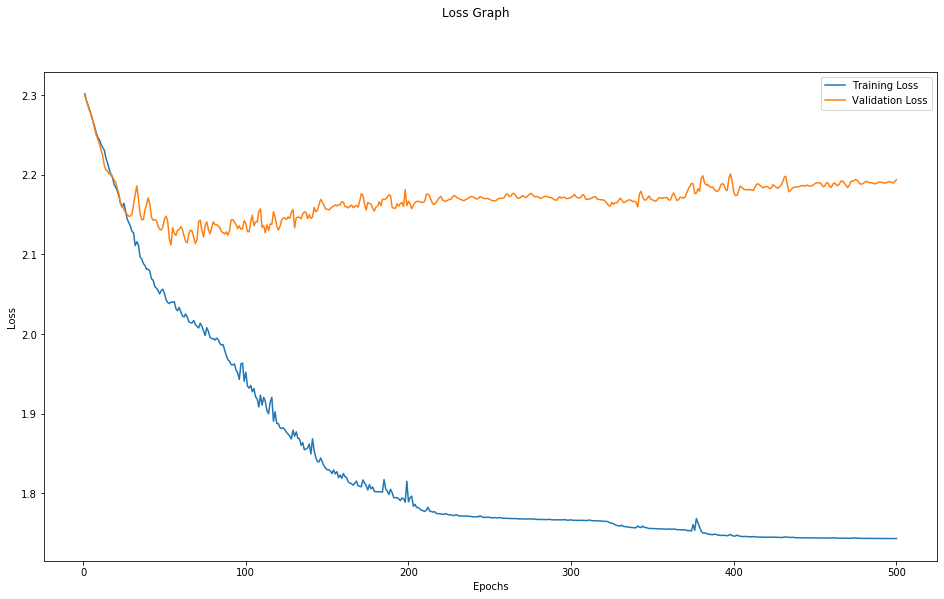

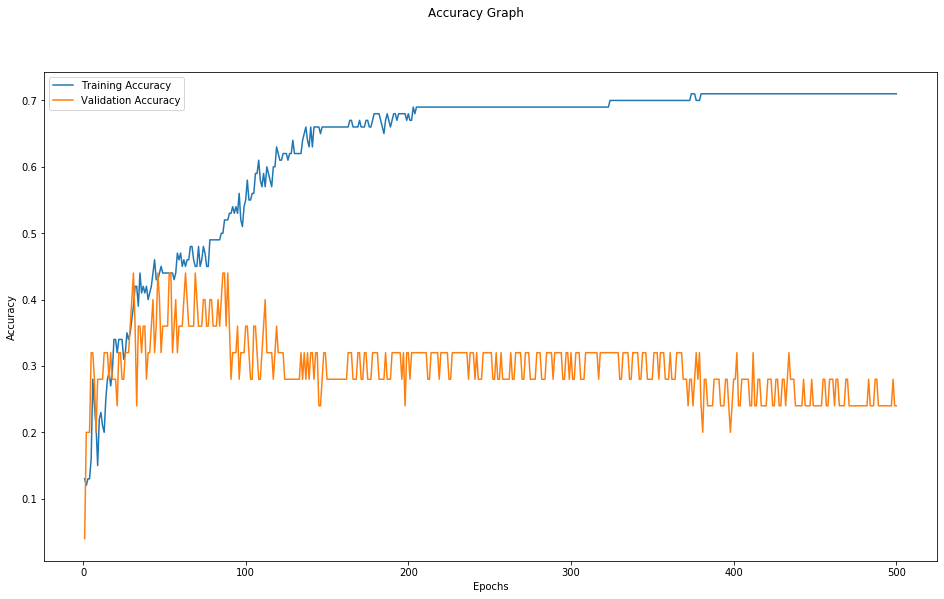

Smooth curve graphs of above graphs


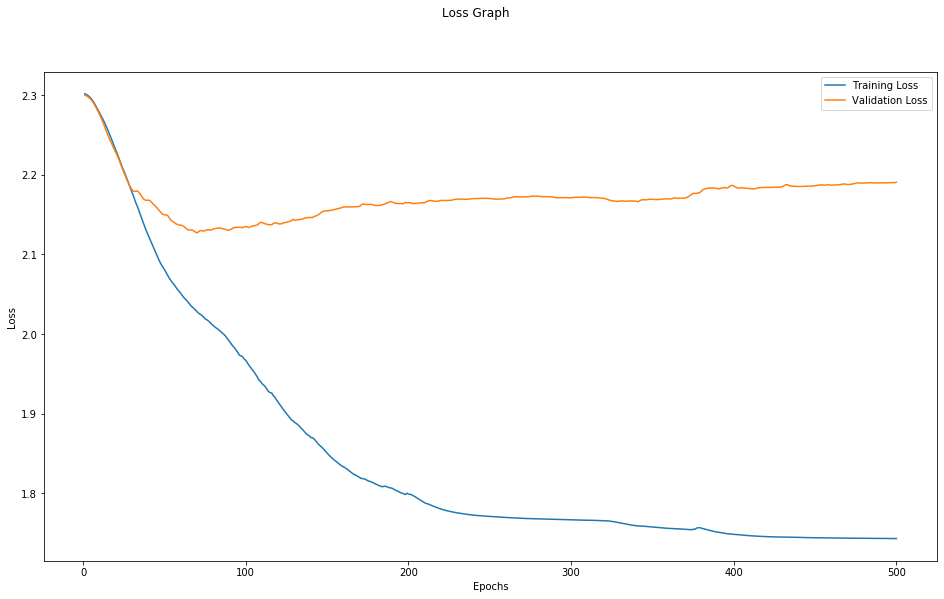

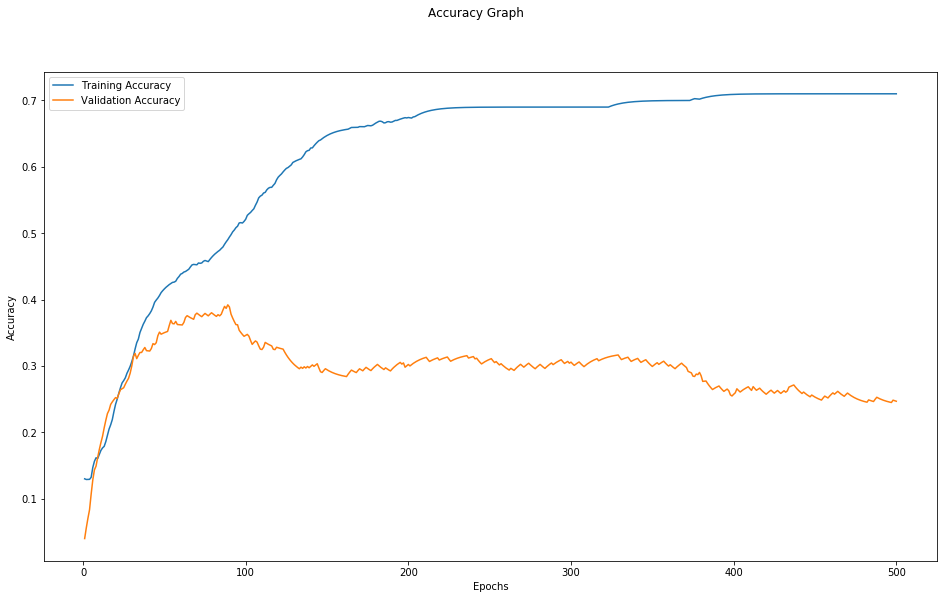

In [17]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

b. Add drop out layers as regularization method to reduce overfitting.

In [18]:
def build_model():
    
    model = keras.Sequential([
        layers.Conv2D(16, kernel_size=(3, 3), padding = 'same', activation='relu',
                      input_shape = (img_rows, img_cols, img_channels)),
        
        layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = 'same'),

        layers.Dropout(0.2),
        
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = 'same'),
        
        layers.Dropout(0.3),
        
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = 'same'),
        
        layers.Dropout(0.4),
        
        layers.Flatten(),
        
        layers.Dense(1024),
        
        layers.Dropout(0.5),
        
        layers.Dense(10, activation = 'softmax')
    ])
    
    adam = keras.optimizers.Adam(learning_rate = 0.0001)
    los = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    
    model.compile(optimizer = adam, loss = los, metrics = ['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)         

In [19]:
num_epochs = 500

all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

# Randomly Choosing 100 samples from training set
train_data_temp, test_data_temp, train_labels_temp, test_labels_temp = train_test_split(train_data, train_labels,
                                                                                        test_size=0.998)

# Randomly choosing 25 samples from remaining data points i.e. from 49,900 points.
_, test_data_temp, _, test_labels_temp = train_test_split(test_data_temp, test_labels_temp, test_size=0.0005)

model = build_model()
history = model.fit(train_data_temp, train_labels_temp,validation_data=(test_data_temp, test_labels_temp),
                    epochs=num_epochs)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Train on 100 samples, validate on 25 samples
Epoch 1/500
100/100 [==============================] - 1s 7ms/sample - loss: 2.3083 - accuracy: 0.0600 - val_loss: 2.3050 - val_accuracy: 0.1200
Epoch 2/500
100/100 [==============================] - 0s 249us/sample - loss: 2.3058 - accuracy: 0.1000 - val_loss: 2.3051 - val_accuracy: 0.1200
Epoch 3/500
100/100 [==============================] - 0s 249us/sample - loss: 2.2904 - accuracy: 0.1500 - val_loss: 2.3054 - val_accuracy: 0.1200
Epoch 4/500
100/100 [==============================] - 0s 249us/sample - loss: 2.2918 - accuracy: 0.1300 - val_loss: 2.3052 - val_accuracy: 0.1200
Epoch 5/500
100/100 [==============================] - 0s 249us/sample - loss: 2.2844 - accuracy: 0.1500 - val_loss: 2.3045 - val_accuracy: 0.1200
Epoch 6/500
100/100 [==============================] - 0s 239us/sample - loss: 2.2969 - accuracy: 0.1400 - val_loss: 2.3051 - val_accuracy: 0.1200
Epoch 7/500
100/100 [==============================] - 0s 249us/sample - lo

100/100 [==============================] - 0s 249us/sample - loss: 2.1559 - accuracy: 0.2700 - val_loss: 2.2940 - val_accuracy: 0.1200
Epoch 112/500
100/100 [==============================] - 0s 259us/sample - loss: 2.1445 - accuracy: 0.2900 - val_loss: 2.2905 - val_accuracy: 0.0800
Epoch 113/500
100/100 [==============================] - 0s 259us/sample - loss: 2.1416 - accuracy: 0.3000 - val_loss: 2.2931 - val_accuracy: 0.1600
Epoch 114/500
100/100 [==============================] - 0s 259us/sample - loss: 2.1503 - accuracy: 0.3100 - val_loss: 2.2984 - val_accuracy: 0.0400
Epoch 115/500
100/100 [==============================] - 0s 260us/sample - loss: 2.1295 - accuracy: 0.3100 - val_loss: 2.2948 - val_accuracy: 0.1200
Epoch 116/500
100/100 [==============================] - 0s 249us/sample - loss: 2.1581 - accuracy: 0.2900 - val_loss: 2.2972 - val_accuracy: 0.1200
Epoch 117/500
100/100 [==============================] - 0s 259us/sample - loss: 2.1434 - accuracy: 0.2700 - val_loss: 2

100/100 [==============================] - 0s 259us/sample - loss: 2.1138 - accuracy: 0.3000 - val_loss: 2.2883 - val_accuracy: 0.1200
Epoch 167/500
100/100 [==============================] - 0s 259us/sample - loss: 2.0849 - accuracy: 0.4000 - val_loss: 2.2887 - val_accuracy: 0.1600
Epoch 168/500
100/100 [==============================] - 0s 249us/sample - loss: 2.0776 - accuracy: 0.3800 - val_loss: 2.2875 - val_accuracy: 0.1600
Epoch 169/500
100/100 [==============================] - 0s 249us/sample - loss: 2.0936 - accuracy: 0.3700 - val_loss: 2.2807 - val_accuracy: 0.1600
Epoch 170/500
100/100 [==============================] - 0s 249us/sample - loss: 2.1012 - accuracy: 0.3500 - val_loss: 2.2738 - val_accuracy: 0.1600
Epoch 171/500
100/100 [==============================] - 0s 259us/sample - loss: 2.0782 - accuracy: 0.4100 - val_loss: 2.2685 - val_accuracy: 0.1600
Epoch 172/500
100/100 [==============================] - 0s 249us/sample - loss: 2.1017 - accuracy: 0.3800 - val_loss: 2

100/100 [==============================] - 0s 259us/sample - loss: 2.0380 - accuracy: 0.4700 - val_loss: 2.2919 - val_accuracy: 0.1600
Epoch 222/500
100/100 [==============================] - 0s 239us/sample - loss: 2.0133 - accuracy: 0.4600 - val_loss: 2.2927 - val_accuracy: 0.1600
Epoch 223/500
100/100 [==============================] - 0s 249us/sample - loss: 2.0329 - accuracy: 0.4500 - val_loss: 2.2919 - val_accuracy: 0.0800
Epoch 224/500
100/100 [==============================] - 0s 269us/sample - loss: 2.0346 - accuracy: 0.4200 - val_loss: 2.2867 - val_accuracy: 0.0800
Epoch 225/500
100/100 [==============================] - 0s 249us/sample - loss: 2.0183 - accuracy: 0.4400 - val_loss: 2.2799 - val_accuracy: 0.0800
Epoch 226/500
100/100 [==============================] - 0s 249us/sample - loss: 2.0272 - accuracy: 0.4700 - val_loss: 2.2810 - val_accuracy: 0.1600
Epoch 227/500
100/100 [==============================] - 0s 249us/sample - loss: 2.0356 - accuracy: 0.4300 - val_loss: 2

100/100 [==============================] - 0s 259us/sample - loss: 2.0480 - accuracy: 0.4100 - val_loss: 2.3135 - val_accuracy: 0.1200
Epoch 277/500
100/100 [==============================] - 0s 250us/sample - loss: 2.0081 - accuracy: 0.4600 - val_loss: 2.3115 - val_accuracy: 0.1200
Epoch 278/500
100/100 [==============================] - 0s 249us/sample - loss: 2.0245 - accuracy: 0.4500 - val_loss: 2.3106 - val_accuracy: 0.0800
Epoch 279/500
100/100 [==============================] - 0s 249us/sample - loss: 2.0232 - accuracy: 0.4500 - val_loss: 2.3013 - val_accuracy: 0.0800
Epoch 280/500
100/100 [==============================] - 0s 259us/sample - loss: 2.0350 - accuracy: 0.4100 - val_loss: 2.2886 - val_accuracy: 0.1200
Epoch 281/500
100/100 [==============================] - 0s 259us/sample - loss: 1.9704 - accuracy: 0.5100 - val_loss: 2.2830 - val_accuracy: 0.1200
Epoch 282/500
100/100 [==============================] - 0s 239us/sample - loss: 1.9993 - accuracy: 0.4800 - val_loss: 2

Epoch 331/500
100/100 [==============================] - 0s 249us/sample - loss: 1.9491 - accuracy: 0.5200 - val_loss: 2.2856 - val_accuracy: 0.0800
Epoch 332/500
100/100 [==============================] - 0s 249us/sample - loss: 1.9641 - accuracy: 0.5200 - val_loss: 2.2848 - val_accuracy: 0.0800
Epoch 333/500
100/100 [==============================] - 0s 249us/sample - loss: 1.9790 - accuracy: 0.5000 - val_loss: 2.2876 - val_accuracy: 0.0800
Epoch 334/500
100/100 [==============================] - 0s 249us/sample - loss: 1.9899 - accuracy: 0.4900 - val_loss: 2.2957 - val_accuracy: 0.0400
Epoch 335/500
100/100 [==============================] - 0s 249us/sample - loss: 1.9668 - accuracy: 0.5300 - val_loss: 2.2979 - val_accuracy: 0.0400
Epoch 336/500
100/100 [==============================] - 0s 269us/sample - loss: 1.9775 - accuracy: 0.5100 - val_loss: 2.2995 - val_accuracy: 0.0400
Epoch 337/500
100/100 [==============================] - 0s 259us/sample - loss: 1.9722 - accuracy: 0.5000

Epoch 386/500
100/100 [==============================] - 0s 239us/sample - loss: 1.9366 - accuracy: 0.5300 - val_loss: 2.2772 - val_accuracy: 0.1200
Epoch 387/500
100/100 [==============================] - 0s 259us/sample - loss: 1.9647 - accuracy: 0.5200 - val_loss: 2.2780 - val_accuracy: 0.1200
Epoch 388/500
100/100 [==============================] - 0s 249us/sample - loss: 1.9333 - accuracy: 0.5400 - val_loss: 2.2814 - val_accuracy: 0.1200
Epoch 389/500
100/100 [==============================] - 0s 259us/sample - loss: 1.9353 - accuracy: 0.5300 - val_loss: 2.2790 - val_accuracy: 0.1200
Epoch 390/500
100/100 [==============================] - 0s 249us/sample - loss: 1.9720 - accuracy: 0.4800 - val_loss: 2.2742 - val_accuracy: 0.1200
Epoch 391/500
100/100 [==============================] - 0s 249us/sample - loss: 1.9177 - accuracy: 0.5600 - val_loss: 2.2638 - val_accuracy: 0.1600
Epoch 392/500
100/100 [==============================] - 0s 259us/sample - loss: 1.9198 - accuracy: 0.5600

Epoch 441/500
100/100 [==============================] - 0s 249us/sample - loss: 1.9223 - accuracy: 0.5400 - val_loss: 2.2538 - val_accuracy: 0.2000
Epoch 442/500
100/100 [==============================] - 0s 249us/sample - loss: 1.8826 - accuracy: 0.6100 - val_loss: 2.2594 - val_accuracy: 0.1600
Epoch 443/500
100/100 [==============================] - 0s 239us/sample - loss: 1.9091 - accuracy: 0.5500 - val_loss: 2.2632 - val_accuracy: 0.1600
Epoch 444/500
100/100 [==============================] - 0s 249us/sample - loss: 1.9001 - accuracy: 0.5900 - val_loss: 2.2590 - val_accuracy: 0.2000
Epoch 445/500
100/100 [==============================] - 0s 249us/sample - loss: 1.8947 - accuracy: 0.6000 - val_loss: 2.2582 - val_accuracy: 0.2000
Epoch 446/500
100/100 [==============================] - 0s 249us/sample - loss: 1.8921 - accuracy: 0.5600 - val_loss: 2.2561 - val_accuracy: 0.2000
Epoch 447/500
100/100 [==============================] - 0s 249us/sample - loss: 1.8962 - accuracy: 0.5700

Epoch 496/500
100/100 [==============================] - 0s 249us/sample - loss: 1.9103 - accuracy: 0.5700 - val_loss: 2.2496 - val_accuracy: 0.2000
Epoch 497/500
100/100 [==============================] - 0s 269us/sample - loss: 1.8807 - accuracy: 0.6000 - val_loss: 2.2500 - val_accuracy: 0.2000
Epoch 498/500
100/100 [==============================] - 0s 239us/sample - loss: 1.8702 - accuracy: 0.6300 - val_loss: 2.2506 - val_accuracy: 0.2000
Epoch 499/500
100/100 [==============================] - 0s 239us/sample - loss: 1.8872 - accuracy: 0.6000 - val_loss: 2.2523 - val_accuracy: 0.2000
Epoch 500/500
100/100 [==============================] - 0s 249us/sample - loss: 1.8722 - accuracy: 0.6100 - val_loss: 2.2740 - val_accuracy: 0.2000


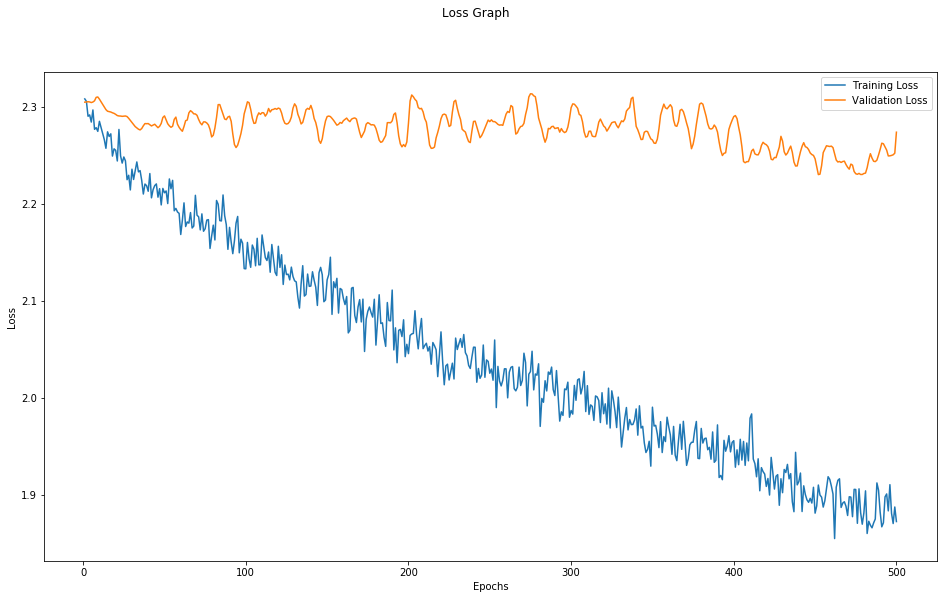

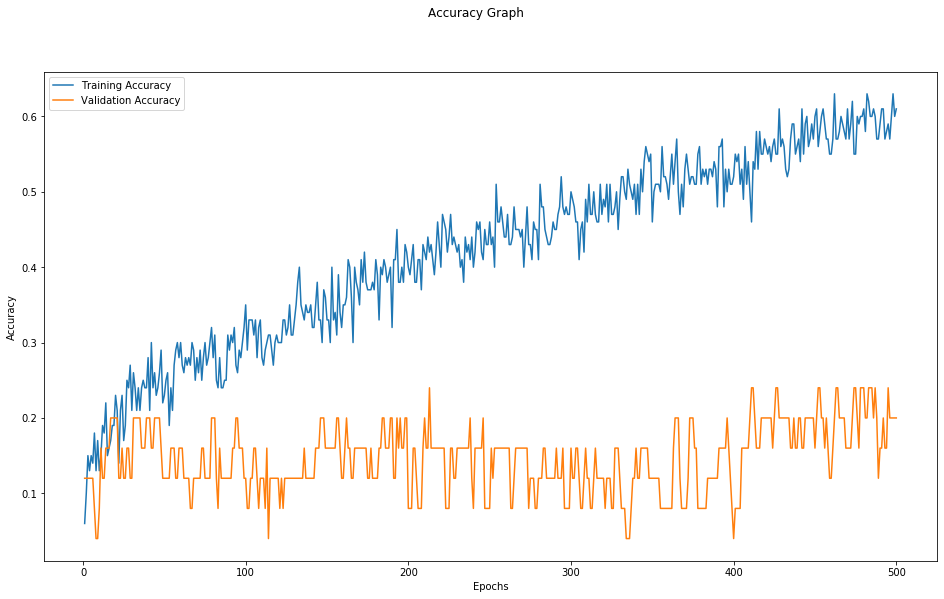

Smooth curve graphs of above graphs


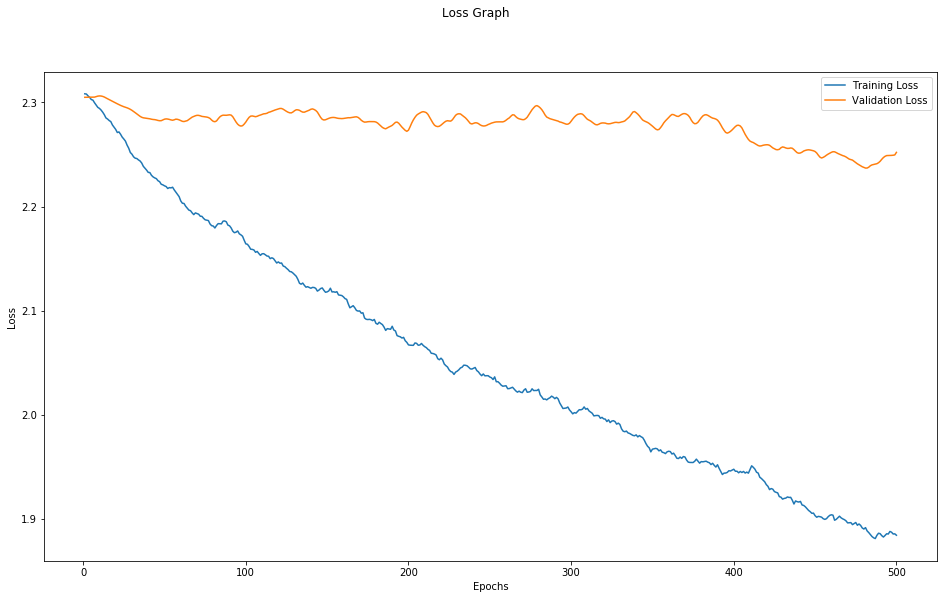

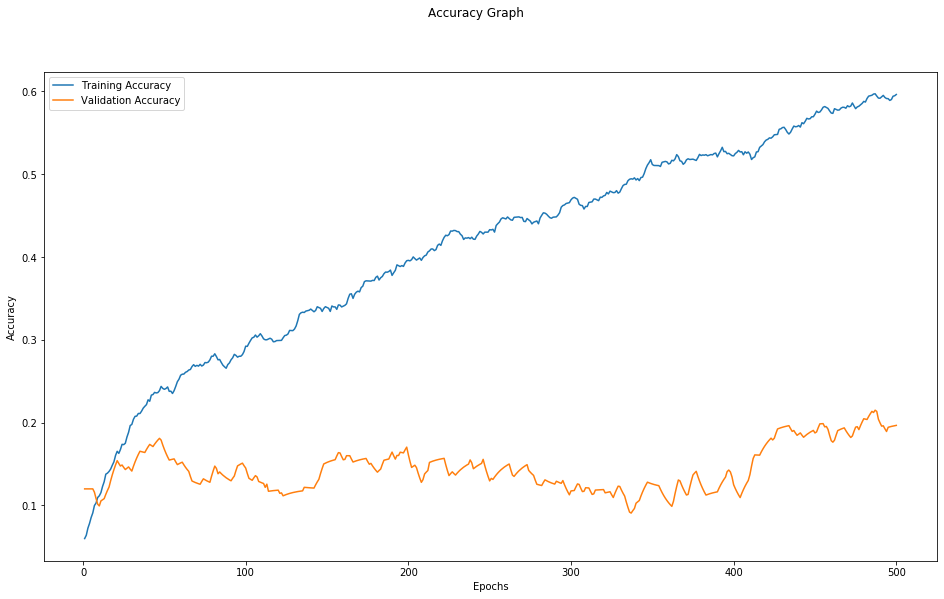

In [20]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

3.1 Modify the model architecture parameters, including<br>
a. Number of different layers<br>
b. Number of filters/outputs in each layer<br>
3.2 Modify the training hyperparameters including (but not limited to)<br>
a. Learning rate<br>
b. Batch size<br>
c. Number of epochs

Here are the all tests we conducted using different models and techniques.<br>
Build a sample model with SGD optimizer with Constant Learning Rate

In [21]:
def build_model_SGD():
    # changed model pattern with 2 convolutional layers followed by a maxpooling layer to increase convolution operations.
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu',
                      input_shape = (img_rows, img_cols, img_channels)),
        
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
                      
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Flatten(),
        
        layers.Dense(128),
        
        layers.Dense(10, activation = 'softmax')
    ])
    
    sgd = keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9)
    los = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    
    model.compile(optimizer = sgd, loss = los, metrics = ['accuracy'])
    return model

model = build_model_SGD()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 128)        

In [22]:
num_epochs = 150

all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

train_data_temp, test_data_temp, train_labels_temp, test_labels_temp = train_test_split(train_data, train_labels,
                                                                                        test_size=0.3)

model = build_model_SGD()
history = model.fit(train_data_temp, train_labels_temp,validation_data=(test_data_temp, test_labels_temp),
                    epochs=num_epochs, batch_size = 64)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Train on 35000 samples, validate on 15000 samples
Epoch 1/150
35000/35000 [==============================] - 8s 237us/sample - loss: 2.3026 - accuracy: 0.1082 - val_loss: 2.3025 - val_accuracy: 0.1267
Epoch 2/150
35000/35000 [==============================] - 7s 200us/sample - loss: 2.3024 - accuracy: 0.1373 - val_loss: 2.3023 - val_accuracy: 0.1505
Epoch 3/150
35000/35000 [==============================] - 7s 200us/sample - loss: 2.3022 - accuracy: 0.1443 - val_loss: 2.3021 - val_accuracy: 0.1263
Epoch 4/150
35000/35000 [==============================] - 7s 198us/sample - loss: 2.3019 - accuracy: 0.1255 - val_loss: 2.3018 - val_accuracy: 0.1040
Epoch 5/150
35000/35000 [==============================] - 7s 199us/sample - loss: 2.3014 - accuracy: 0.1107 - val_loss: 2.3012 - val_accuracy: 0.1035
Epoch 6/150
35000/35000 [==============================] - 8s 224us/sample - loss: 2.3002 - accuracy: 0.1196 - val_loss: 2.2992 - val_accuracy: 0.1157
Epoch 7/150
35000/35000 [===================

Epoch 108/150
35000/35000 [==============================] - 9s 248us/sample - loss: 1.6837 - accuracy: 0.7787 - val_loss: 1.8865 - val_accuracy: 0.5727
Epoch 109/150
35000/35000 [==============================] - 9s 256us/sample - loss: 1.6881 - accuracy: 0.7743 - val_loss: 1.8892 - val_accuracy: 0.5689
Epoch 110/150
35000/35000 [==============================] - 9s 243us/sample - loss: 1.6814 - accuracy: 0.7808 - val_loss: 1.8925 - val_accuracy: 0.5656
Epoch 111/150
35000/35000 [==============================] - 8s 241us/sample - loss: 1.6799 - accuracy: 0.7825 - val_loss: 1.8902 - val_accuracy: 0.5693
Epoch 112/150
35000/35000 [==============================] - 8s 230us/sample - loss: 1.6800 - accuracy: 0.7821 - val_loss: 1.8905 - val_accuracy: 0.5669
Epoch 113/150
35000/35000 [==============================] - 9s 244us/sample - loss: 1.6772 - accuracy: 0.7846 - val_loss: 1.8841 - val_accuracy: 0.5737
Epoch 114/150
35000/35000 [==============================] - 9s 252us/sample - los

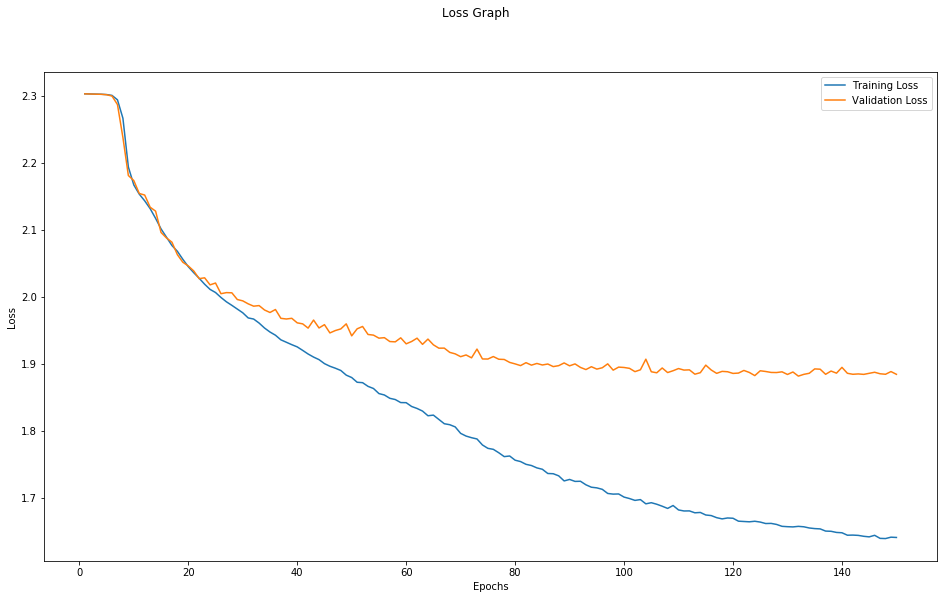

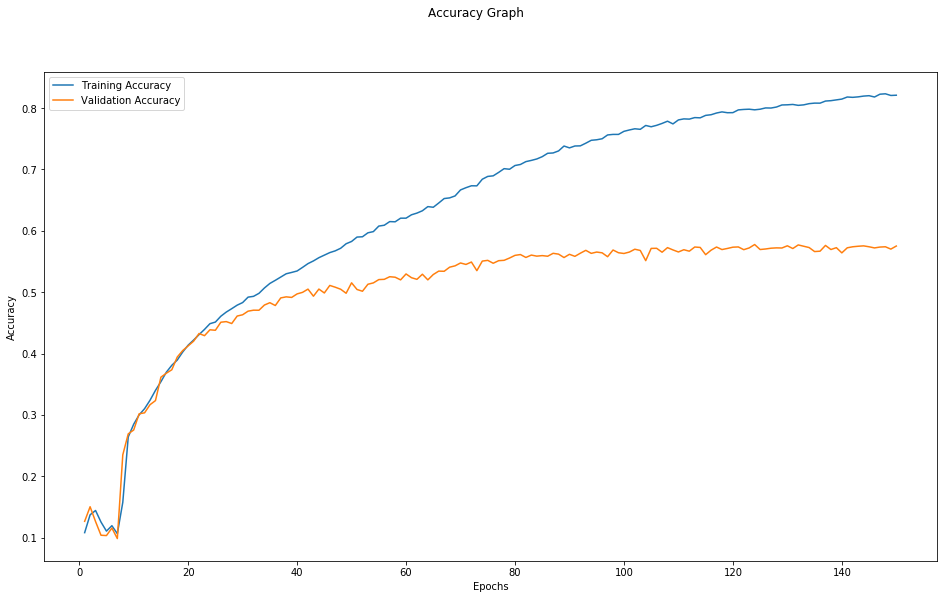

Smooth curve graphs of above graphs


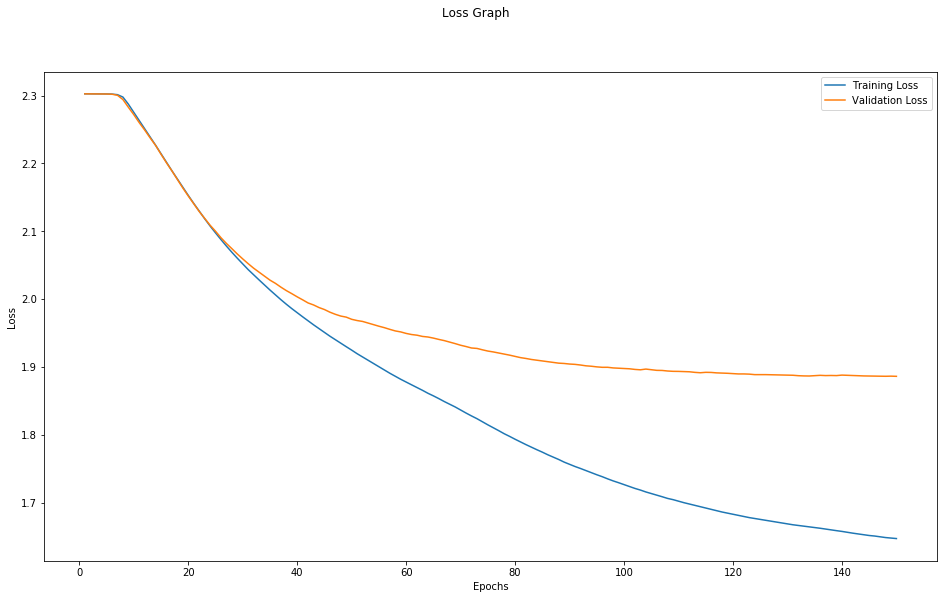

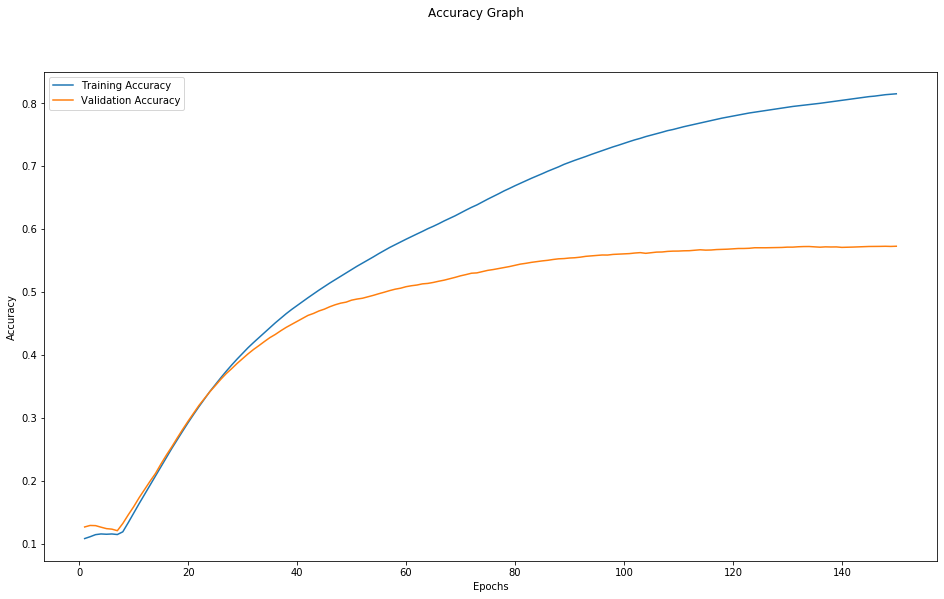

In [23]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

In [24]:
test_mse_score, test_acc_score = model.evaluate(test_data, test_labels)
print("Final testing Accuracy",test_acc_score*100,"%")

10000/10000 [==============================] - 2s 163us/sample - loss: 1.8804 - accuracy: 0.5784
Final testing Accuracy 57.840001583099365 %


Time Based Decay with SGD Optimizer

In [25]:
def build_model_SGD():
    
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu',
                      input_shape = (img_rows, img_cols, img_channels)),
        
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
                      
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2),  padding = 'same'),
        
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
                      
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2),  padding = 'same'),
        
        layers.Flatten(),
                      
        layers.Dense(128),
                      
        layers.Dense(10, activation = 'softmax'),
        
        
        
    ])
    
    lr = 0.1
    decay_rate = lr/150
    
    # While using Momentum 0.9, it overfitted the model within first 10 epochs giving only 10 % training accuracy
    # so we decided to use 0.8 momentum.
    
    sgd = keras.optimizers.SGD(learning_rate = lr, momentum=0.8, decay=decay_rate)
    los = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    model.compile(optimizer = sgd, loss = los, metrics = ['accuracy'])
    return model

model = build_model_SGD()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 8, 8, 128)        

In [26]:
num_epochs = 150

all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

train_data_temp, test_data_temp, train_labels_temp, test_labels_temp = train_test_split(train_data, train_labels,
                                                                                        test_size=0.3)

model = build_model_SGD()
history = model.fit(train_data_temp, train_labels_temp,validation_data=(test_data_temp, test_labels_temp),
                    epochs=num_epochs, batch_size = 64)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Train on 35000 samples, validate on 15000 samples
Epoch 1/150
35000/35000 [==============================] - 9s 251us/sample - loss: 2.2373 - accuracy: 0.2055 - val_loss: 2.1752 - val_accuracy: 0.2742
Epoch 2/150
35000/35000 [==============================] - 8s 227us/sample - loss: 2.1628 - accuracy: 0.2887 - val_loss: 2.1303 - val_accuracy: 0.3246
Epoch 3/150
35000/35000 [==============================] - 8s 227us/sample - loss: 2.1099 - accuracy: 0.3457 - val_loss: 2.0844 - val_accuracy: 0.3680
Epoch 4/150
35000/35000 [==============================] - 8s 233us/sample - loss: 2.0541 - accuracy: 0.4002 - val_loss: 2.0931 - val_accuracy: 0.3613
Epoch 5/150
35000/35000 [==============================] - 8s 229us/sample - loss: 2.0098 - accuracy: 0.4462 - val_loss: 2.0032 - val_accuracy: 0.4541
Epoch 6/150
35000/35000 [==============================] - 8s 226us/sample - loss: 1.9687 - accuracy: 0.4887 - val_loss: 1.9701 - val_accuracy: 0.4868
Epoch 7/150
35000/35000 [===================

Epoch 108/150
35000/35000 [==============================] - 8s 220us/sample - loss: 1.5788 - accuracy: 0.8807 - val_loss: 1.7959 - val_accuracy: 0.6642
Epoch 109/150
35000/35000 [==============================] - 8s 225us/sample - loss: 1.5788 - accuracy: 0.8807 - val_loss: 1.7959 - val_accuracy: 0.6637
Epoch 110/150
35000/35000 [==============================] - 8s 219us/sample - loss: 1.5788 - accuracy: 0.8807 - val_loss: 1.7958 - val_accuracy: 0.6634
Epoch 111/150
35000/35000 [==============================] - 8s 226us/sample - loss: 1.5788 - accuracy: 0.8807 - val_loss: 1.7958 - val_accuracy: 0.6636
Epoch 112/150
35000/35000 [==============================] - 8s 227us/sample - loss: 1.5788 - accuracy: 0.8807 - val_loss: 1.7958 - val_accuracy: 0.6634
Epoch 113/150
35000/35000 [==============================] - 8s 221us/sample - loss: 1.5788 - accuracy: 0.8807 - val_loss: 1.7959 - val_accuracy: 0.6635
Epoch 114/150
35000/35000 [==============================] - 8s 224us/sample - los

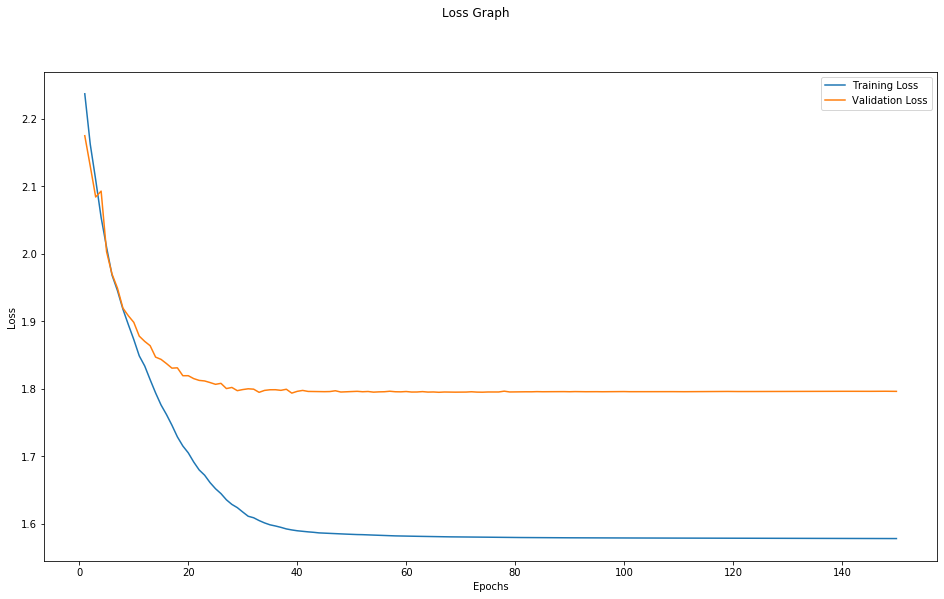

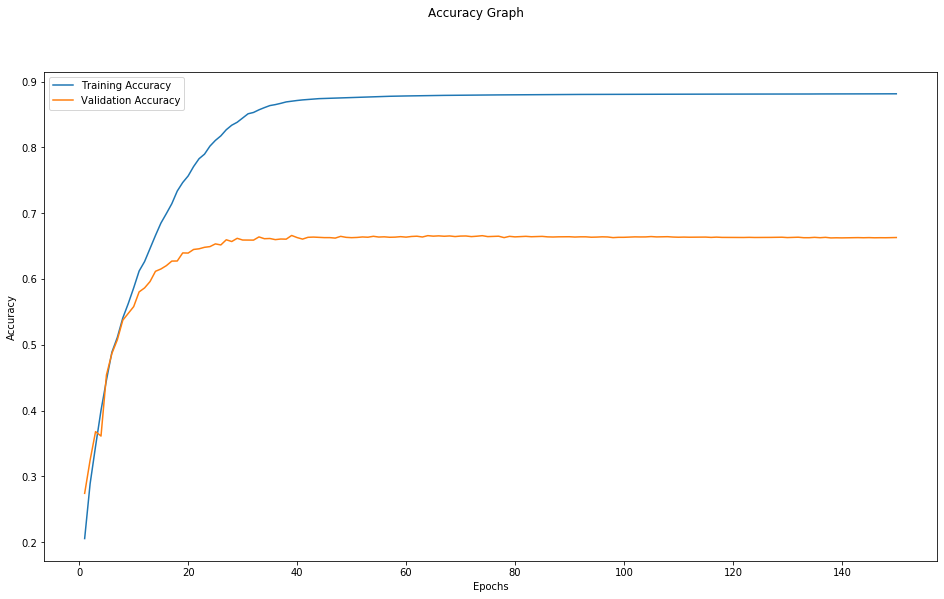

Smooth curve graphs of above graphs


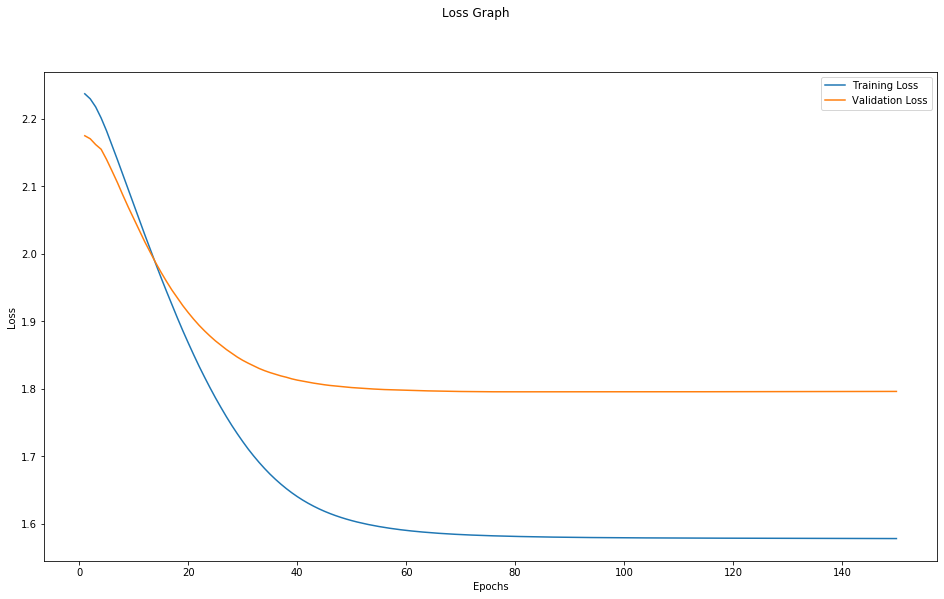

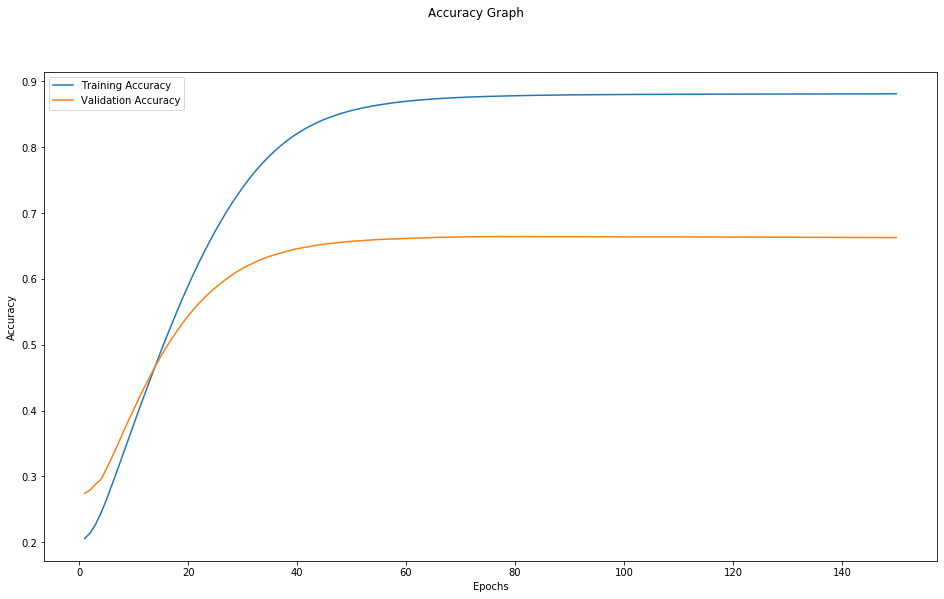

In [27]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

In [28]:
test_mse_score, test_acc_score = model.evaluate(test_data, test_labels)
print("Final testing Accuracy",test_acc_score*100,"%")

10000/10000 [==============================] - 1s 125us/sample - loss: 1.7957 - accuracy: 0.6642
Final testing Accuracy 66.42000079154968 %


SGD with Step Decay

In [29]:
def step_decay(num_epoch = 20):
        initial_lrate = 0.01
        drop = 0.5
        epochs_drop = 10.0
        lrate = initial_lrate * math.pow(drop, math.floor((1+num_epoch)/epochs_drop))
        return lrate
def build_model_SGD():
    
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu',
                      input_shape = (img_rows, img_cols, img_channels)),
        
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
                      
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2),  padding = 'same'),
        
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
                      
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2),  padding = 'same'),
        
        layers.Flatten(),
                      
        layers.Dense(128),
                      
        layers.Dense(10, activation = 'softmax'),
        
        
        
    ])
    
    sgd = keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9)
    los = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    model.compile(optimizer = sgd, loss = los, metrics = ['accuracy'])
    return model

model = build_model_SGD()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 8, 8, 128)        

In [30]:
num_epochs = 150

all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

train_data_temp, test_data_temp, train_labels_temp, test_labels_temp = train_test_split(train_data, train_labels,
                                                                                        test_size=0.3)

model = build_model_SGD()

lrate = keras.callbacks.LearningRateScheduler(step_decay)
callbacks_list = [lrate]
    
history = model.fit(train_data_temp, train_labels_temp,validation_data=(test_data_temp, test_labels_temp),
                    epochs=num_epochs, batch_size = 64, callbacks=callbacks_list)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Train on 35000 samples, validate on 15000 samples
Epoch 1/150
35000/35000 [==============================] - 9s 247us/sample - loss: 2.2549 - accuracy: 0.1771 - val_loss: 2.2211 - val_accuracy: 0.2202
Epoch 2/150
35000/35000 [==============================] - 8s 218us/sample - loss: 2.1528 - accuracy: 0.2987 - val_loss: 2.1171 - val_accuracy: 0.3379
Epoch 3/150
35000/35000 [==============================] - 8s 228us/sample - loss: 2.0869 - accuracy: 0.3691 - val_loss: 2.0856 - val_accuracy: 0.3715
Epoch 4/150
35000/35000 [==============================] - 8s 226us/sample - loss: 2.0454 - accuracy: 0.4095 - val_loss: 2.0230 - val_accuracy: 0.4319
Epoch 5/150
35000/35000 [==============================] - 8s 226us/sample - loss: 2.0137 - accuracy: 0.4415 - val_loss: 2.0009 - val_accuracy: 0.4544
Epoch 6/150
35000/35000 [==============================] - 8s 225us/sample - loss: 1.9829 - accuracy: 0.4747 - val_loss: 1.9929 - val_accuracy: 0.4645
Epoch 7/150
35000/35000 [===================

Epoch 108/150
35000/35000 [==============================] - 8s 219us/sample - loss: 1.6295 - accuracy: 0.8303 - val_loss: 1.8328 - val_accuracy: 0.6263
Epoch 109/150
35000/35000 [==============================] - 8s 223us/sample - loss: 1.6295 - accuracy: 0.8304 - val_loss: 1.8328 - val_accuracy: 0.6264
Epoch 110/150
35000/35000 [==============================] - 8s 220us/sample - loss: 1.6295 - accuracy: 0.8304 - val_loss: 1.8328 - val_accuracy: 0.6263
Epoch 111/150
35000/35000 [==============================] - 8s 225us/sample - loss: 1.6295 - accuracy: 0.8304 - val_loss: 1.8328 - val_accuracy: 0.6264
Epoch 112/150
35000/35000 [==============================] - 8s 224us/sample - loss: 1.6295 - accuracy: 0.8304 - val_loss: 1.8328 - val_accuracy: 0.6263
Epoch 113/150
35000/35000 [==============================] - 8s 220us/sample - loss: 1.6295 - accuracy: 0.8304 - val_loss: 1.8328 - val_accuracy: 0.6263
Epoch 114/150
35000/35000 [==============================] - 8s 218us/sample - los

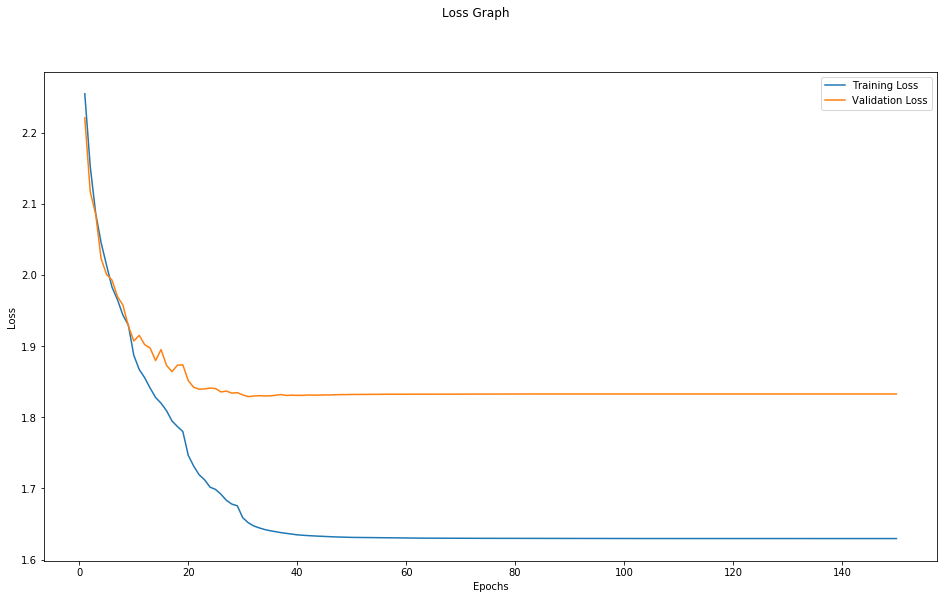

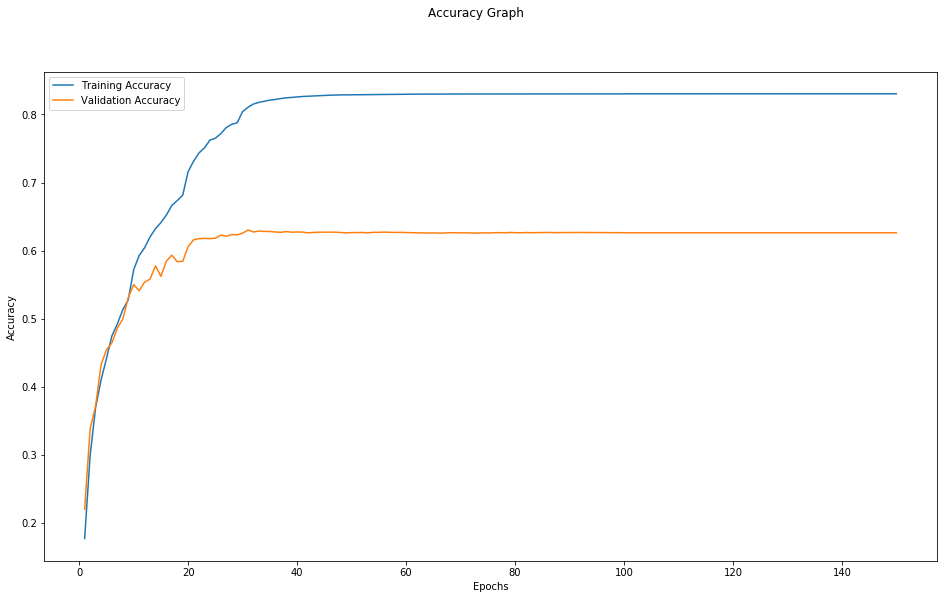

Smooth curve graphs of above graphs


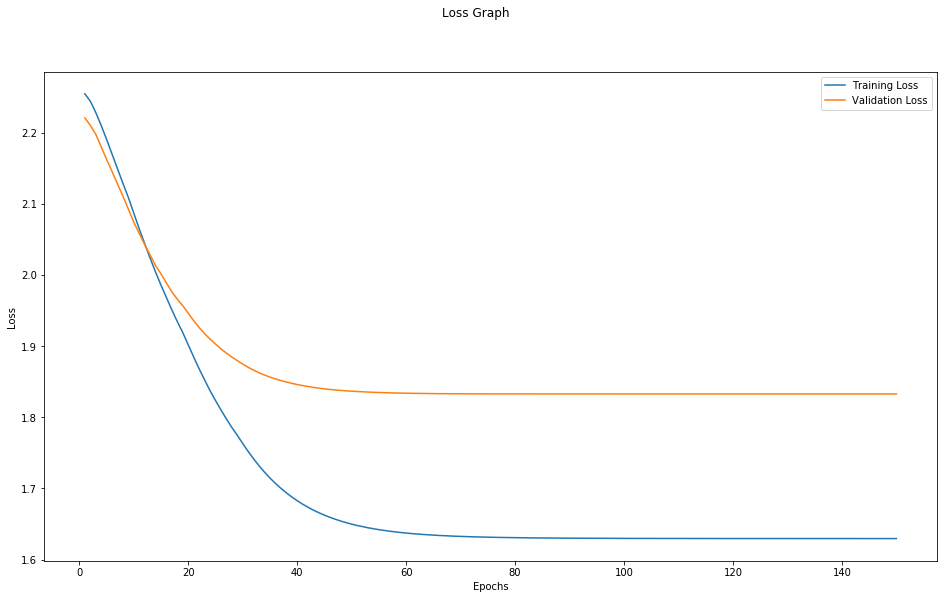

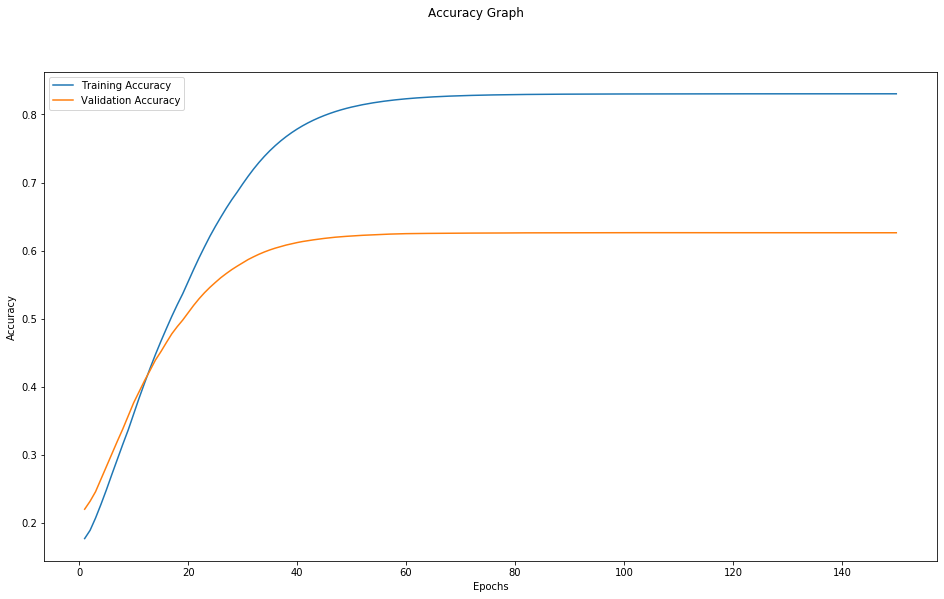

In [31]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

In [32]:
test_mse_score, test_acc_score = model.evaluate(test_data, test_labels)
print("Final testing Accuracy",test_acc_score*100,"%")

10000/10000 [==============================] - 1s 121us/sample - loss: 1.8408 - accuracy: 0.6168
Final testing Accuracy 61.68000102043152 %


SGD with exponential decay

In [33]:
def exp_decay(epoch):
    initial_lrate = 0.01
    k = 0.1
    lrate = initial_lrate * math.exp(-k*epoch)
    return lrate

num_epochs = 150

all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

train_data_temp, test_data_temp, train_labels_temp, test_labels_temp = train_test_split(train_data, train_labels,
                                                                                        test_size=0.3)

model = build_model_SGD()

lrate = keras.callbacks.LearningRateScheduler(exp_decay)
callbacks_list = [lrate]
    
history = model.fit(train_data_temp, train_labels_temp,validation_data=(test_data_temp, test_labels_temp),
                    epochs=num_epochs, batch_size = 64, callbacks=callbacks_list)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Train on 35000 samples, validate on 15000 samples
Epoch 1/150
35000/35000 [==============================] - 8s 220us/sample - loss: 2.2701 - accuracy: 0.1713 - val_loss: 2.1950 - val_accuracy: 0.2536
Epoch 2/150
35000/35000 [==============================] - 8s 224us/sample - loss: 2.1659 - accuracy: 0.2873 - val_loss: 2.1480 - val_accuracy: 0.3076
Epoch 3/150
35000/35000 [==============================] - 8s 229us/sample - loss: 2.1119 - accuracy: 0.3423 - val_loss: 2.0595 - val_accuracy: 0.3993
Epoch 4/150
35000/35000 [==============================] - 8s 227us/sample - loss: 2.0607 - accuracy: 0.3949 - val_loss: 2.0726 - val_accuracy: 0.3840
Epoch 5/150
35000/35000 [==============================] - 8s 224us/sample - loss: 2.0308 - accuracy: 0.4273 - val_loss: 2.0138 - val_accuracy: 0.4417
Epoch 6/150
35000/35000 [==============================] - 8s 226us/sample - loss: 2.0056 - accuracy: 0.4511 - val_loss: 1.9923 - val_accuracy: 0.4648
Epoch 7/150
35000/35000 [===================

Epoch 108/150
35000/35000 [==============================] - 8s 238us/sample - loss: 1.7113 - accuracy: 0.7539 - val_loss: 1.8788 - val_accuracy: 0.5794
Epoch 109/150
35000/35000 [==============================] - 9s 244us/sample - loss: 1.7113 - accuracy: 0.7539 - val_loss: 1.8788 - val_accuracy: 0.5795
Epoch 110/150
35000/35000 [==============================] - 9s 266us/sample - loss: 1.7113 - accuracy: 0.7539 - val_loss: 1.8788 - val_accuracy: 0.5794
Epoch 111/150
35000/35000 [==============================] - 9s 243us/sample - loss: 1.7113 - accuracy: 0.7539 - val_loss: 1.8788 - val_accuracy: 0.5794
Epoch 112/150
35000/35000 [==============================] - 9s 251us/sample - loss: 1.7113 - accuracy: 0.7539 - val_loss: 1.8788 - val_accuracy: 0.5794
Epoch 113/150
35000/35000 [==============================] - 8s 238us/sample - loss: 1.7113 - accuracy: 0.7539 - val_loss: 1.8788 - val_accuracy: 0.5795
Epoch 114/150
35000/35000 [==============================] - 9s 245us/sample - los

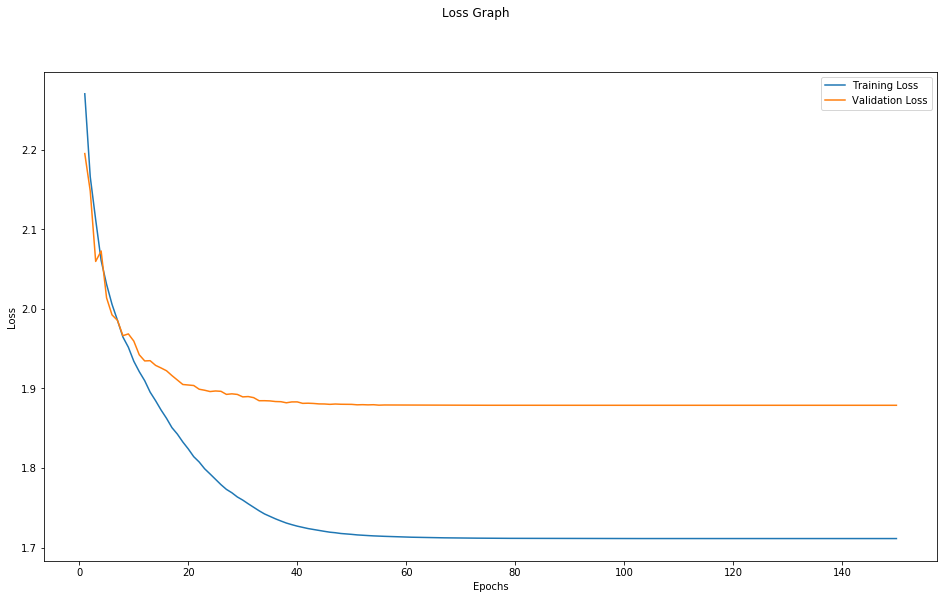

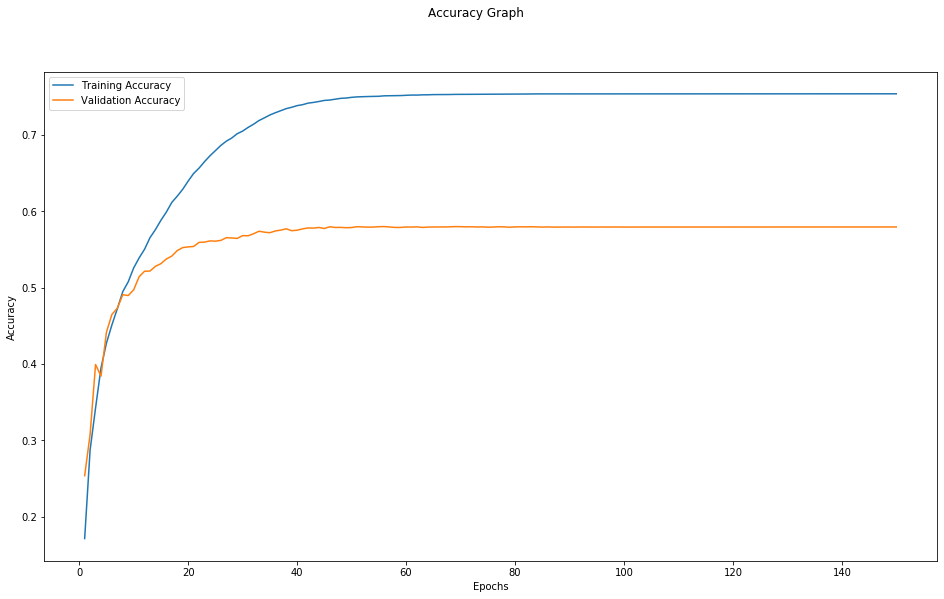

Smooth curve graphs of above graphs


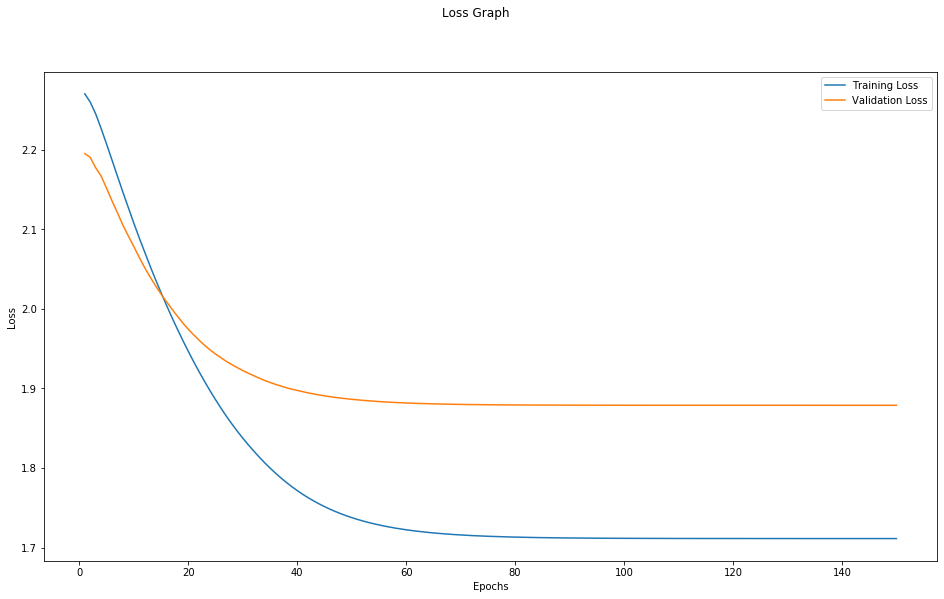

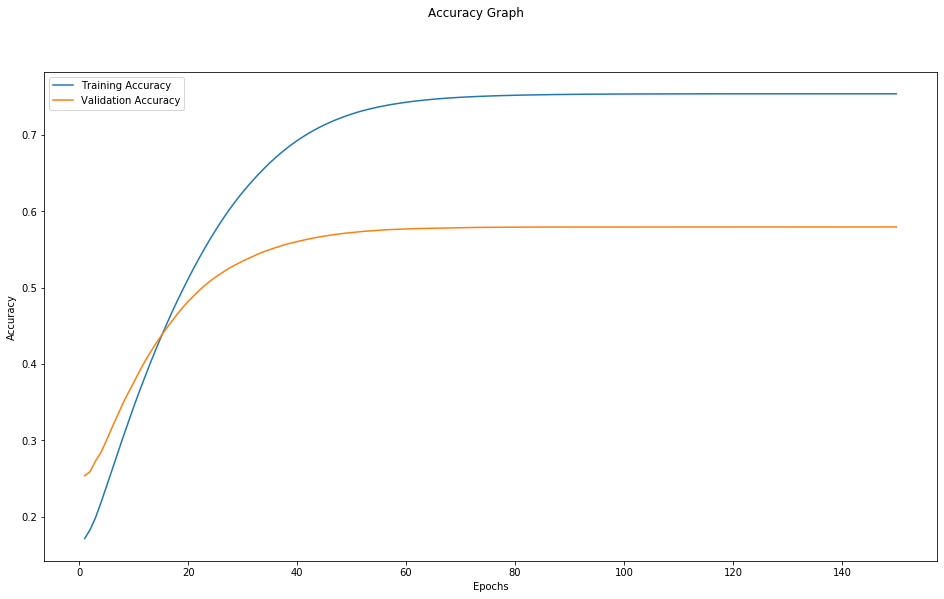

In [34]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

In [35]:
test_mse_score, test_acc_score = model.evaluate(test_data, test_labels)
print("Final testing Accuracy",test_acc_score*100,"%")

10000/10000 [==============================] - 2s 156us/sample - loss: 1.8750 - accuracy: 0.5830
Final testing Accuracy 58.30000042915344 %


SGD with Reduce Learning rate on Plateau callback

In [36]:
def build_model_SGD():
    
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu',
                      input_shape = (img_rows, img_cols, img_channels)),
        
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
                      
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2),  padding = 'same'),
        
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
                      
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2),  padding = 'same'),
        
        layers.Flatten(),
                      
        layers.Dense(128),
                      
        layers.Dense(10, activation = 'softmax'),
        
        
        
    ])
    
    sgd = keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9)
    los = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    model.compile(optimizer = sgd, loss = los, metrics = ['accuracy'])
    return model

model = build_model_SGD()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 8, 8, 128)       

In [37]:
num_epochs = 150
all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

model = build_model_SGD()

train_data_temp, test_data_temp, train_labels_temp, test_labels_temp = train_test_split(train_data, train_labels,
                                                                                        test_size=0.3)

lrate = keras.callbacks.ReduceLROnPlateau()
callbacks_list = [lrate]

history = model.fit(train_data_temp, train_labels_temp,validation_data=(test_data_temp, test_labels_temp),
                    epochs=num_epochs, batch_size = 64, callbacks=callbacks_list)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Train on 35000 samples, validate on 15000 samples
Epoch 1/150
35000/35000 [==============================] - 9s 257us/sample - loss: 2.3024 - accuracy: 0.1295 - val_loss: 2.3022 - val_accuracy: 0.1495
Epoch 2/150
35000/35000 [==============================] - 8s 240us/sample - loss: 2.3020 - accuracy: 0.1480 - val_loss: 2.3017 - val_accuracy: 0.1563
Epoch 3/150
35000/35000 [==============================] - 8s 235us/sample - loss: 2.3014 - accuracy: 0.1537 - val_loss: 2.3008 - val_accuracy: 0.1531
Epoch 4/150
35000/35000 [==============================] - 8s 236us/sample - loss: 2.3000 - accuracy: 0.1664 - val_loss: 2.2981 - val_accuracy: 0.1773
Epoch 5/150
35000/35000 [==============================] - 8s 235us/sample - loss: 2.2940 - accuracy: 0.1270 - val_loss: 2.2829 - val_accuracy: 0.1110
Epoch 6/150
35000/35000 [==============================] - 8s 236us/sample - loss: 2.2462 - accuracy: 0.2045 - val_loss: 2.2061 - val_accuracy: 0.2465
Epoch 7/150
35000/35000 [===================

Epoch 108/150
35000/35000 [==============================] - 8s 240us/sample - loss: 1.6699 - accuracy: 0.7920 - val_loss: 1.8744 - val_accuracy: 0.5838
Epoch 109/150
35000/35000 [==============================] - 8s 234us/sample - loss: 1.6698 - accuracy: 0.7920 - val_loss: 1.8744 - val_accuracy: 0.5839
Epoch 110/150
35000/35000 [==============================] - 8s 236us/sample - loss: 1.6698 - accuracy: 0.7921 - val_loss: 1.8743 - val_accuracy: 0.5839
Epoch 111/150
35000/35000 [==============================] - 8s 238us/sample - loss: 1.6698 - accuracy: 0.7922 - val_loss: 1.8744 - val_accuracy: 0.5841
Epoch 112/150
35000/35000 [==============================] - 8s 235us/sample - loss: 1.6698 - accuracy: 0.7922 - val_loss: 1.8744 - val_accuracy: 0.5841
Epoch 113/150
35000/35000 [==============================] - 8s 236us/sample - loss: 1.6698 - accuracy: 0.7922 - val_loss: 1.8744 - val_accuracy: 0.5843
Epoch 114/150
35000/35000 [==============================] - 8s 238us/sample - los

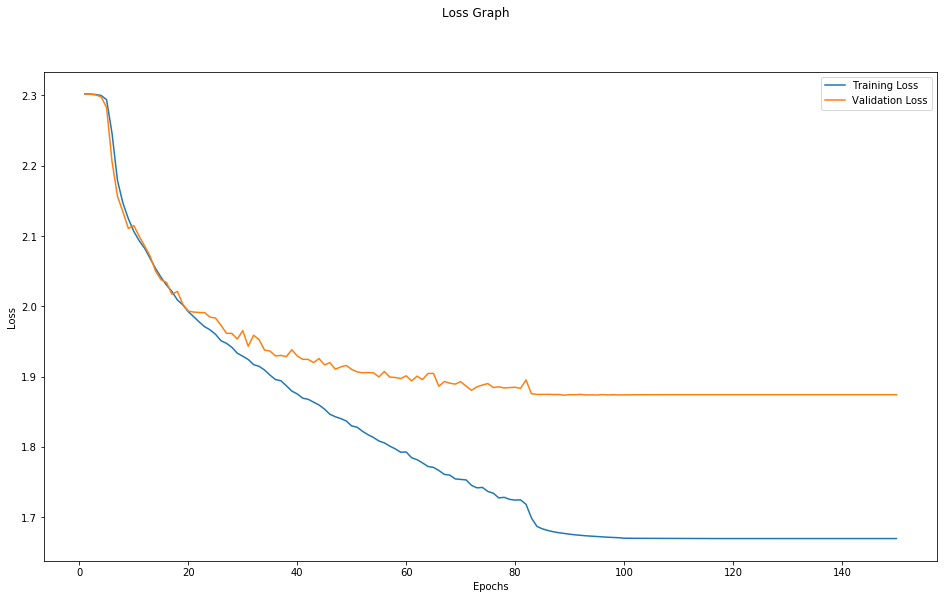

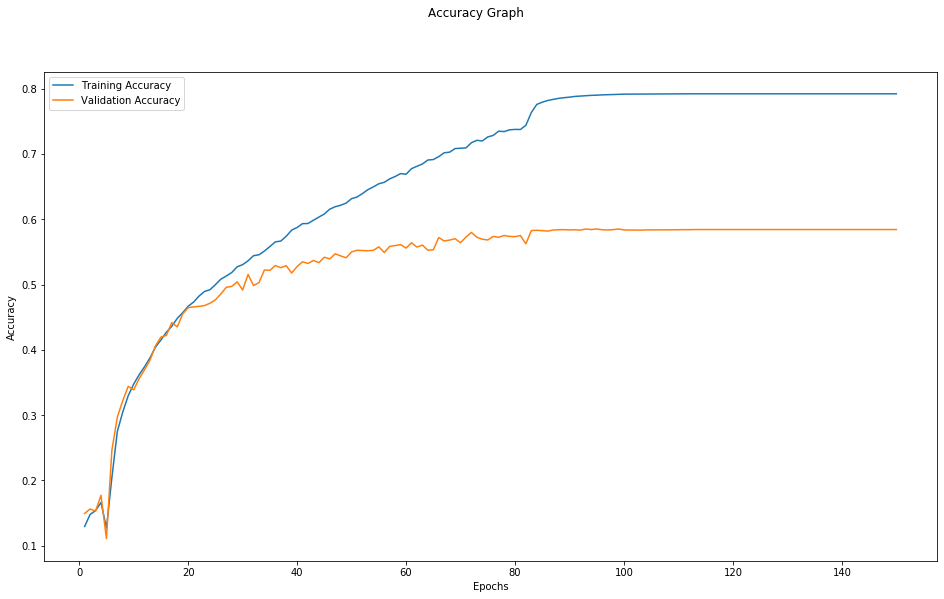

Smooth curve graphs of above graphs


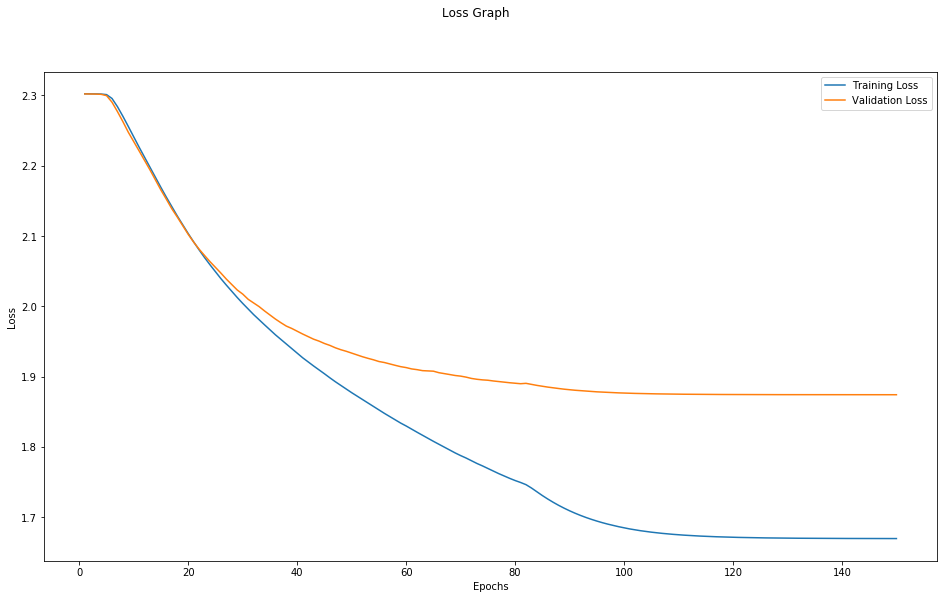

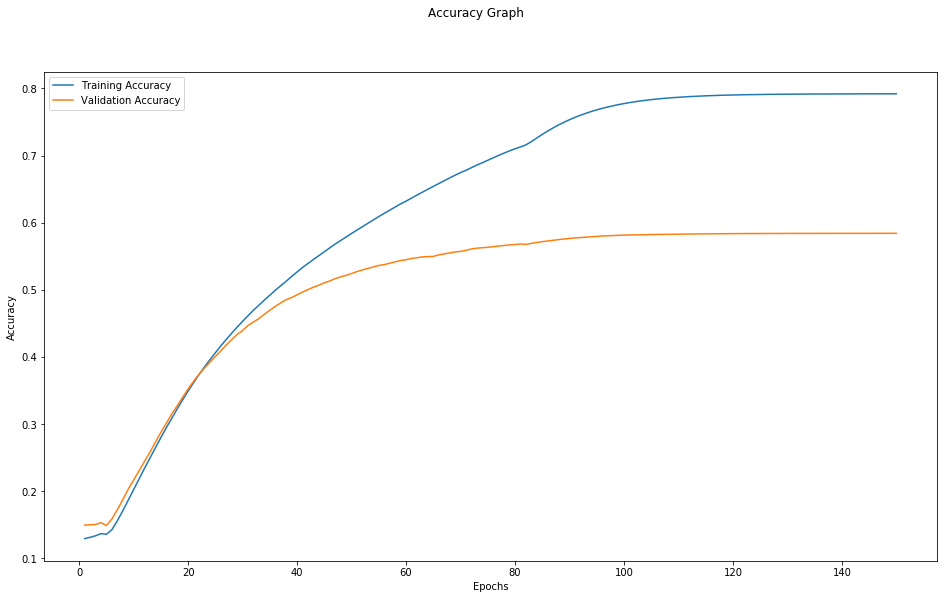

In [38]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

In [39]:
test_mse_score, test_acc_score = model.evaluate(test_data, test_labels)
print("Final testing Accuracy",test_acc_score*100,"%")

10000/10000 [==============================] - 2s 163us/sample - loss: 1.8764 - accuracy: 0.5815
Final testing Accuracy 58.149999380111694 %


Adagrad Optimizer with RLOn Plateau

In [40]:
def build_model():
    
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu',
                      input_shape = (img_rows, img_cols, img_channels)),
        
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
                      
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2),  padding = 'same'),
        
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
                      
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2),  padding = 'same'),
        
        layers.Flatten(),
                      
        layers.Dense(128),
                      
        layers.Dense(10, activation = 'softmax'),
        
        
        
    ])
    
    adagrad = keras.optimizers.Adagrad(learning_rate=0.001)
    los = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    model.compile(optimizer = adagrad, loss = los, metrics = ['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 8, 8, 128)       

In [41]:
num_epochs = 150
all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

model = build_model()

train_data_temp, test_data_temp, train_labels_temp, test_labels_temp = train_test_split(train_data, train_labels,
                                                                                        test_size=0.3)

lrate = keras.callbacks.ReduceLROnPlateau()
callbacks_list = [lrate]

history = model.fit(train_data_temp, train_labels_temp,validation_data=(test_data_temp, test_labels_temp),
                    epochs=num_epochs, batch_size = 64, callbacks=callbacks_list)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Train on 35000 samples, validate on 15000 samples
Epoch 1/150
35000/35000 [==============================] - 8s 233us/sample - loss: 2.3024 - accuracy: 0.0913 - val_loss: 2.3023 - val_accuracy: 0.0882
Epoch 2/150
35000/35000 [==============================] - 8s 228us/sample - loss: 2.3022 - accuracy: 0.0937 - val_loss: 2.3021 - val_accuracy: 0.0941
Epoch 3/150
35000/35000 [==============================] - 8s 238us/sample - loss: 2.3020 - accuracy: 0.1003 - val_loss: 2.3019 - val_accuracy: 0.1003
Epoch 4/150
35000/35000 [==============================] - 9s 245us/sample - loss: 2.3018 - accuracy: 0.1070 - val_loss: 2.3016 - val_accuracy: 0.1092
Epoch 5/150
35000/35000 [==============================] - 8s 236us/sample - loss: 2.3015 - accuracy: 0.1203 - val_loss: 2.3013 - val_accuracy: 0.1239
Epoch 6/150
35000/35000 [==============================] - 8s 235us/sample - loss: 2.3011 - accuracy: 0.1371 - val_loss: 2.3009 - val_accuracy: 0.1385
Epoch 7/150
35000/35000 [===================

Epoch 108/150
35000/35000 [==============================] - 8s 236us/sample - loss: 2.0043 - accuracy: 0.4590 - val_loss: 2.0222 - val_accuracy: 0.4373
Epoch 109/150
35000/35000 [==============================] - 8s 238us/sample - loss: 2.0038 - accuracy: 0.4593 - val_loss: 2.0187 - val_accuracy: 0.4413
Epoch 110/150
35000/35000 [==============================] - 8s 239us/sample - loss: 2.0033 - accuracy: 0.4605 - val_loss: 2.0221 - val_accuracy: 0.4376
Epoch 111/150
35000/35000 [==============================] - 8s 236us/sample - loss: 2.0023 - accuracy: 0.4618 - val_loss: 2.0180 - val_accuracy: 0.4420
Epoch 112/150
35000/35000 [==============================] - 8s 235us/sample - loss: 2.0011 - accuracy: 0.4606 - val_loss: 2.0128 - val_accuracy: 0.4466
Epoch 113/150
35000/35000 [==============================] - 8s 235us/sample - loss: 2.0000 - accuracy: 0.4633 - val_loss: 2.0172 - val_accuracy: 0.4407
Epoch 114/150
35000/35000 [==============================] - 8s 235us/sample - los

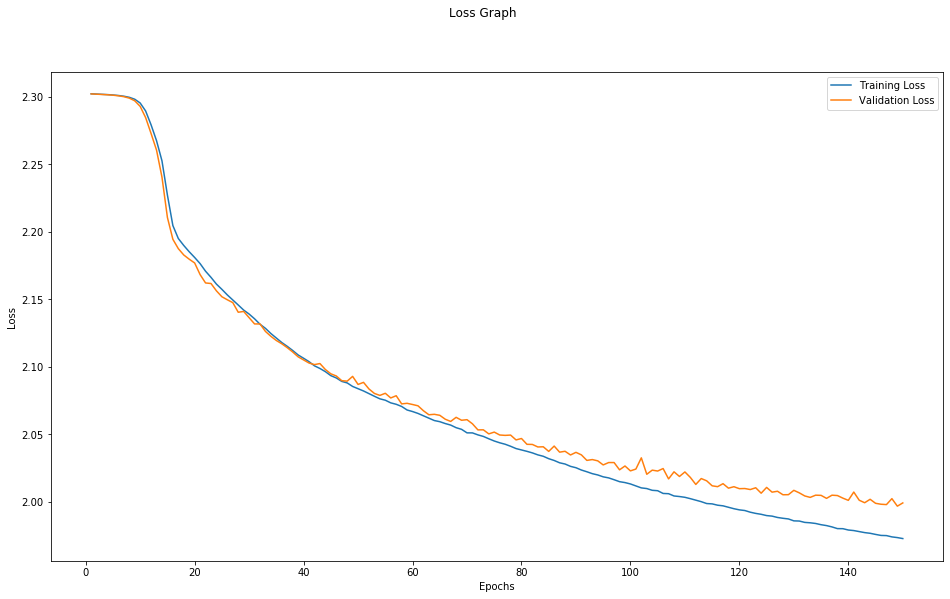

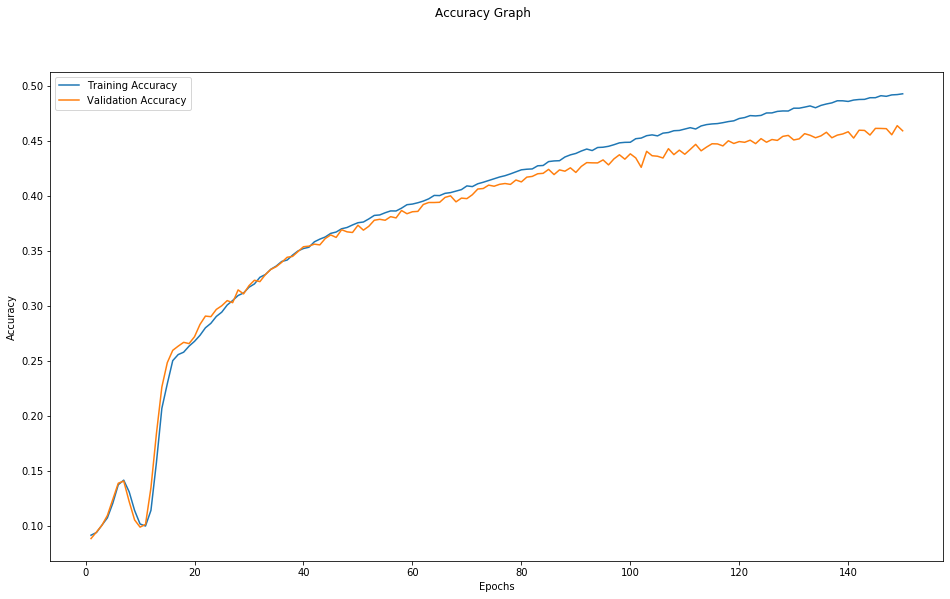

Smooth curve graphs of above graphs


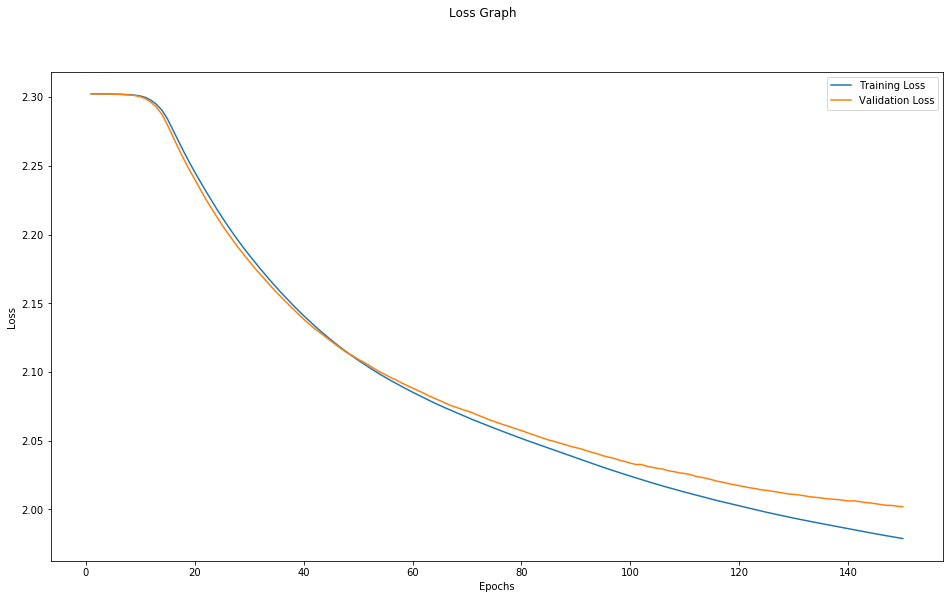

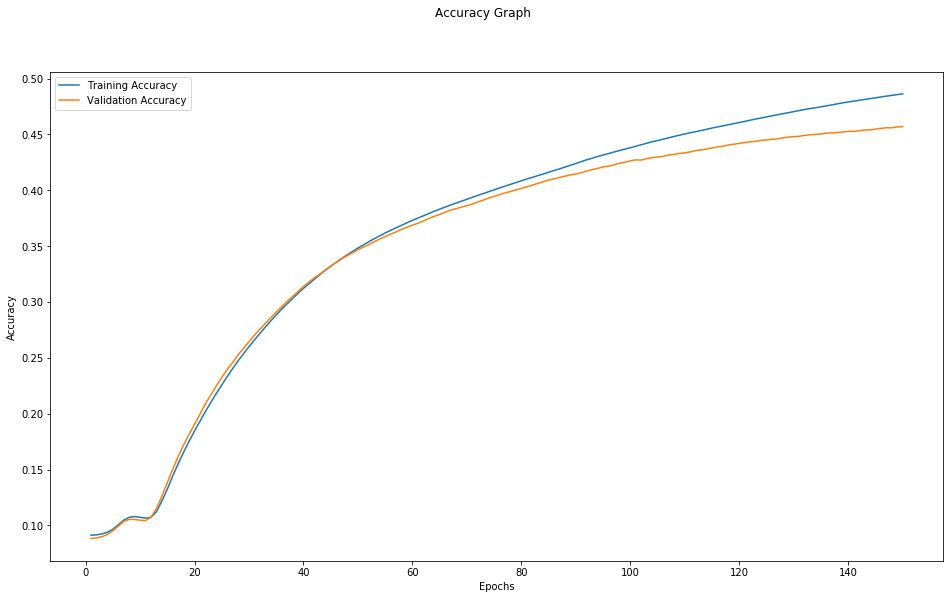

In [42]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

In [43]:
test_mse_score, test_acc_score = model.evaluate(test_data, test_labels)
print("Final testing Accuracy",test_acc_score*100,"%")

10000/10000 [==============================] - 2s 175us/sample - loss: 1.9996 - accuracy: 0.4588
Final testing Accuracy 45.87999880313873 %


Adadelta

In [44]:
def build_model():
    
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu',
                      input_shape = (img_rows, img_cols, img_channels)),
        
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
                      
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2),  padding = 'same'),
        
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
                      
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2),  padding = 'same'),
        
        layers.Flatten(),
                      
        layers.Dense(128),
                      
        layers.Dense(10, activation = 'softmax'),
        
        
        
    ])
    
    adadelta = keras.optimizers.Adadelta(learning_rate = 0.01)
    los = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    model.compile(optimizer = adadelta, loss = los, metrics = ['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 8, 8, 128)       

In [45]:
num_epochs = 150
all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

model = build_model()

train_data_temp, test_data_temp, train_labels_temp, test_labels_temp = train_test_split(train_data, train_labels,
                                                                                        test_size=0.3)

lrate = keras.callbacks.ReduceLROnPlateau()
callbacks_list = [lrate]

history = model.fit(train_data, train_labels,validation_data=(test_data_temp, test_labels_temp),
                    epochs=num_epochs, batch_size = 64, callbacks=callbacks_list)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Train on 50000 samples, validate on 15000 samples
Epoch 1/150
50000/50000 [==============================] - 13s 263us/sample - loss: 2.3023 - accuracy: 0.1141 - val_loss: 2.3021 - val_accuracy: 0.1236
Epoch 2/150
50000/50000 [==============================] - 13s 255us/sample - loss: 2.3017 - accuracy: 0.1197 - val_loss: 2.3011 - val_accuracy: 0.1050
Epoch 3/150
50000/50000 [==============================] - 12s 239us/sample - loss: 2.2996 - accuracy: 0.1035 - val_loss: 2.2966 - val_accuracy: 0.1002
Epoch 4/150
50000/50000 [==============================] - 12s 243us/sample - loss: 2.2892 - accuracy: 0.1011 - val_loss: 2.2789 - val_accuracy: 0.1175
Epoch 5/150
50000/50000 [==============================] - 12s 233us/sample - loss: 2.2575 - accuracy: 0.1805 - val_loss: 2.2266 - val_accuracy: 0.2425
Epoch 6/150
50000/50000 [==============================] - 12s 235us/sample - loss: 2.2039 - accuracy: 0.2532 - val_loss: 2.1935 - val_accuracy: 0.2556
Epoch 7/150
50000/50000 [=============

50000/50000 [==============================] - 12s 248us/sample - loss: 1.9125 - accuracy: 0.5516 - val_loss: 1.9444 - val_accuracy: 0.5163
Epoch 108/150
50000/50000 [==============================] - 13s 253us/sample - loss: 1.9118 - accuracy: 0.5521 - val_loss: 1.9200 - val_accuracy: 0.5425
Epoch 109/150
50000/50000 [==============================] - 13s 253us/sample - loss: 1.9106 - accuracy: 0.5537 - val_loss: 1.9263 - val_accuracy: 0.5351
Epoch 110/150
50000/50000 [==============================] - 12s 249us/sample - loss: 1.9096 - accuracy: 0.5541 - val_loss: 1.9092 - val_accuracy: 0.5563
Epoch 111/150
50000/50000 [==============================] - 12s 249us/sample - loss: 1.9087 - accuracy: 0.5563 - val_loss: 1.9113 - val_accuracy: 0.5517
Epoch 112/150
50000/50000 [==============================] - 12s 246us/sample - loss: 1.9075 - accuracy: 0.5569 - val_loss: 1.9334 - val_accuracy: 0.5250
Epoch 113/150
50000/50000 [==============================] - 13s 251us/sample - loss: 1.90

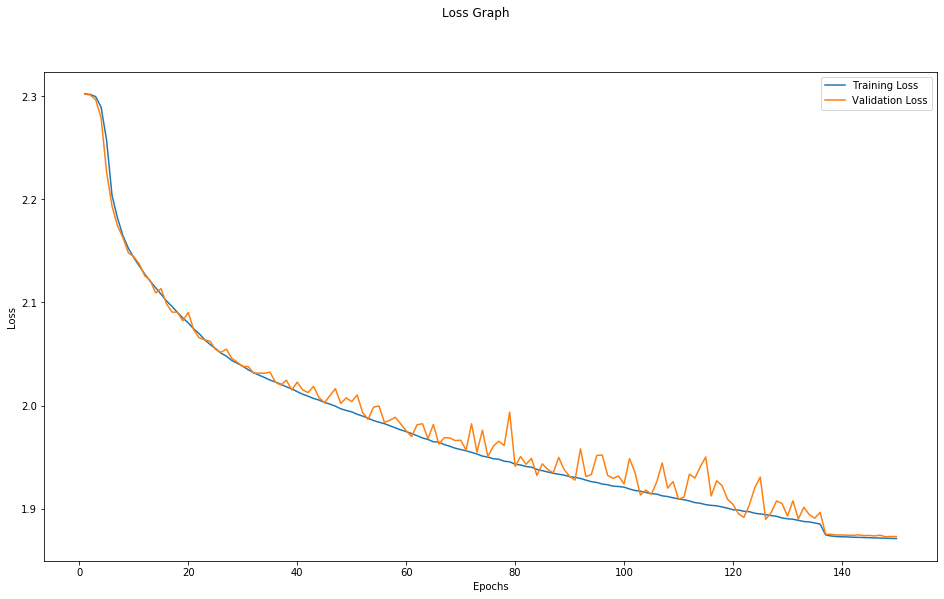

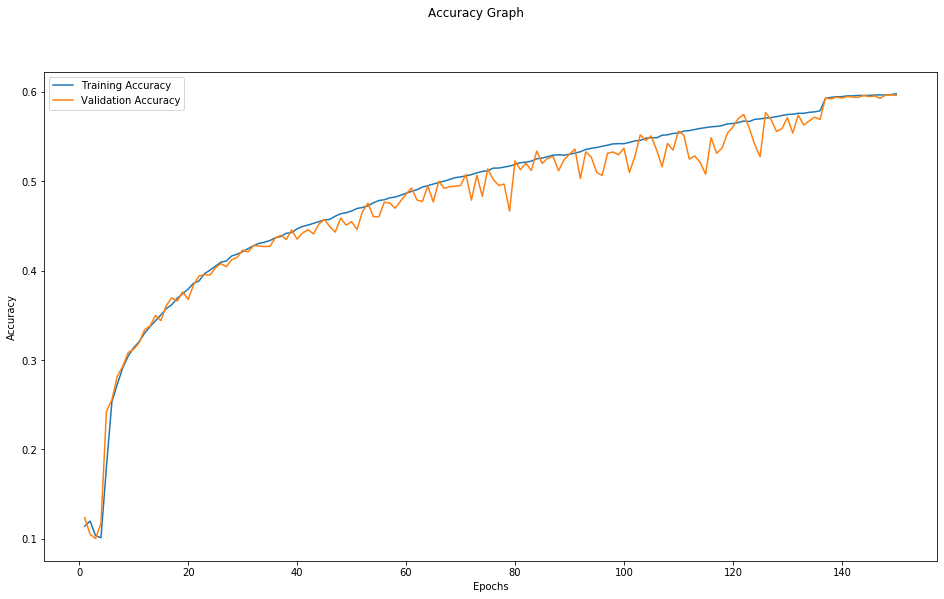

Smooth curve graphs of above graphs


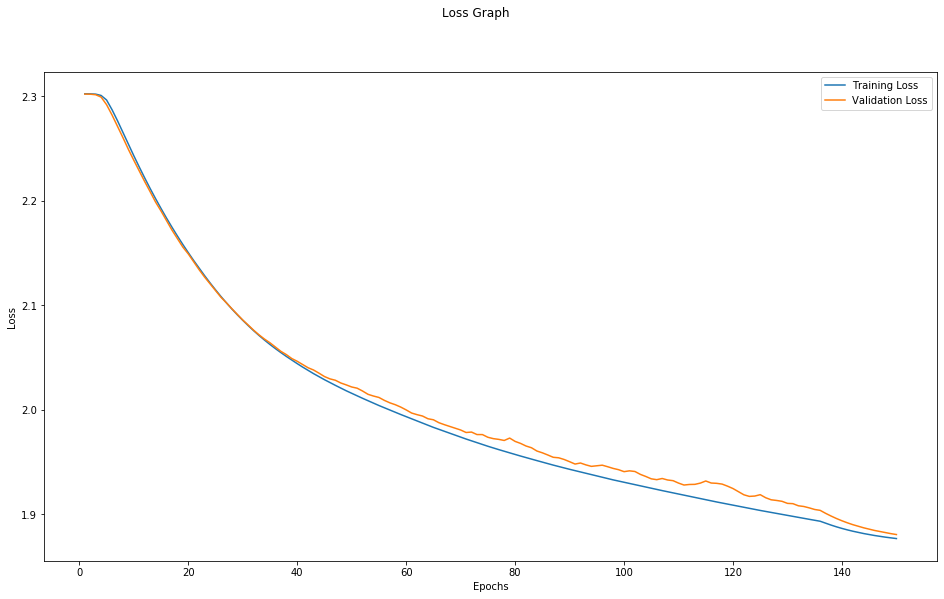

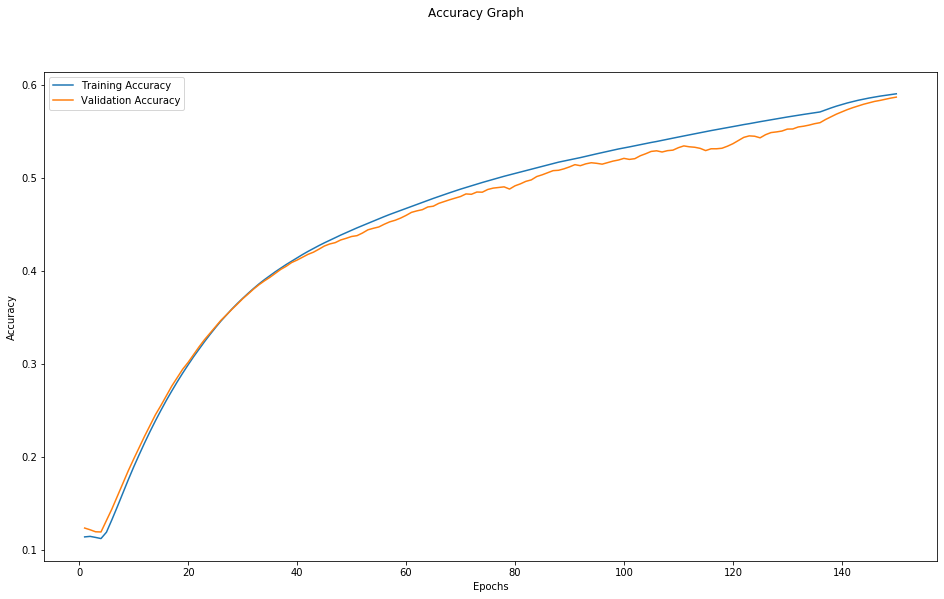

In [46]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

In [47]:
test_mse_score, test_acc_score = model.evaluate(test_data, test_labels)
print("Final testing Accuracy",test_acc_score*100,"%")

10000/10000 [==============================] - 2s 192us/sample - loss: 1.9225 - accuracy: 0.5372
Final testing Accuracy 53.71999740600586 %


Adam

In [48]:
def build_model_ADAM():
    
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu',
                      input_shape = (img_rows, img_cols, img_channels)),
        
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
                      
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Flatten(),
        
        layers.Dense(128),
        
        layers.Dense(10, activation = 'softmax')
    ])
    
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    los = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    
    model.compile(optimizer = adam, loss = los, metrics = ['accuracy'])
    return model

model = build_model_ADAM()
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 8, 8, 128)       

In [49]:
num_epochs = 150
all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

model = build_model_ADAM()

train_data_temp, test_data_temp, train_labels_temp, test_labels_temp = train_test_split(train_data, train_labels,
                                                                                        test_size=0.3)

lrate = keras.callbacks.ReduceLROnPlateau()
callbacks_list = [lrate]

history = model.fit(train_data_temp, train_labels_temp,validation_data=(test_data_temp, test_labels_temp),
                    epochs=num_epochs, batch_size = 64, callbacks=callbacks_list)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Train on 35000 samples, validate on 15000 samples
Epoch 1/150
35000/35000 [==============================] - 12s 337us/sample - loss: 2.1530 - accuracy: 0.2993 - val_loss: 2.0657 - val_accuracy: 0.3922
Epoch 2/150
35000/35000 [==============================] - 10s 297us/sample - loss: 2.0567 - accuracy: 0.4009 - val_loss: 2.0472 - val_accuracy: 0.4058
Epoch 3/150
35000/35000 [==============================] - 9s 263us/sample - loss: 2.0249 - accuracy: 0.4332 - val_loss: 2.0013 - val_accuracy: 0.4579
Epoch 4/150
35000/35000 [==============================] - 10s 277us/sample - loss: 1.9943 - accuracy: 0.4638 - val_loss: 1.9844 - val_accuracy: 0.4751
Epoch 5/150
35000/35000 [==============================] - 9s 254us/sample - loss: 1.9679 - accuracy: 0.4929 - val_loss: 1.9473 - val_accuracy: 0.5144
Epoch 6/150
35000/35000 [==============================] - 9s 259us/sample - loss: 1.9385 - accuracy: 0.5219 - val_loss: 1.9417 - val_accuracy: 0.5187
Epoch 7/150
35000/35000 [================

Epoch 108/150
35000/35000 [==============================] - 9s 252us/sample - loss: 1.5583 - accuracy: 0.9023 - val_loss: 1.7402 - val_accuracy: 0.7186
Epoch 109/150
35000/35000 [==============================] - 9s 250us/sample - loss: 1.5583 - accuracy: 0.9023 - val_loss: 1.7402 - val_accuracy: 0.7186
Epoch 110/150
35000/35000 [==============================] - 9s 249us/sample - loss: 1.5583 - accuracy: 0.9023 - val_loss: 1.7402 - val_accuracy: 0.7186
Epoch 111/150
35000/35000 [==============================] - 9s 251us/sample - loss: 1.5583 - accuracy: 0.9023 - val_loss: 1.7402 - val_accuracy: 0.7186
Epoch 112/150
35000/35000 [==============================] - 9s 249us/sample - loss: 1.5583 - accuracy: 0.9023 - val_loss: 1.7402 - val_accuracy: 0.7186
Epoch 113/150
35000/35000 [==============================] - 9s 250us/sample - loss: 1.5583 - accuracy: 0.9023 - val_loss: 1.7402 - val_accuracy: 0.7186
Epoch 114/150
35000/35000 [==============================] - 9s 250us/sample - los

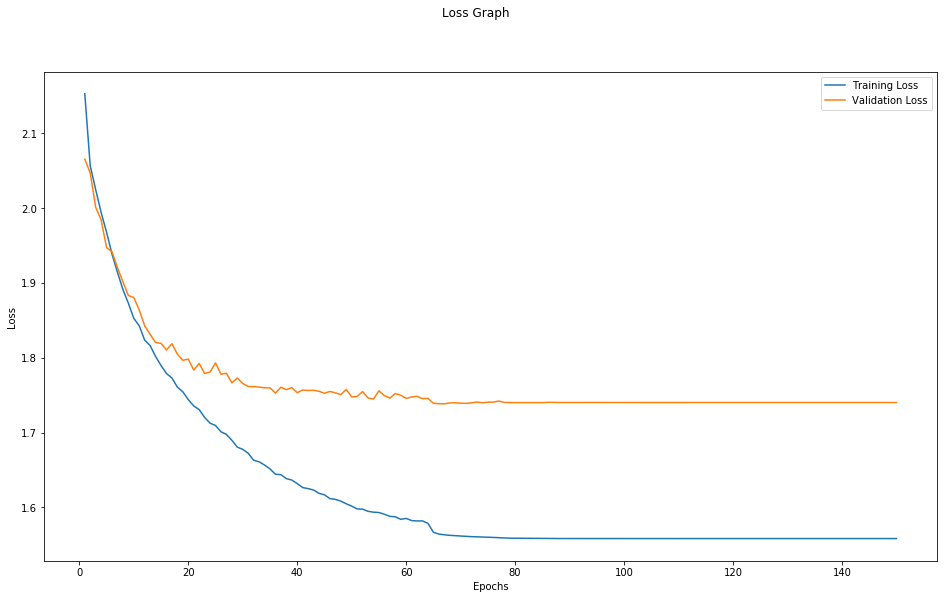

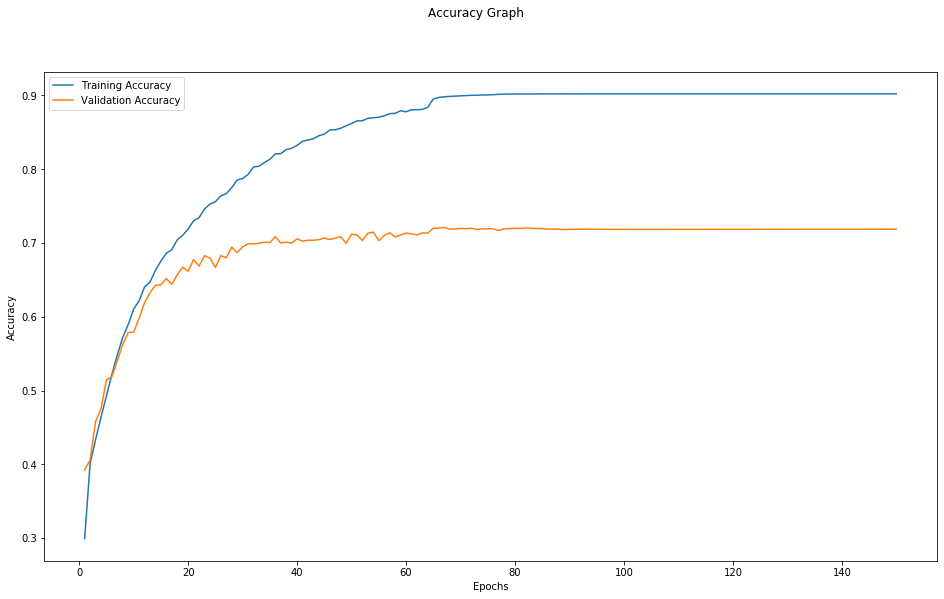

Smooth curve graphs of above graphs


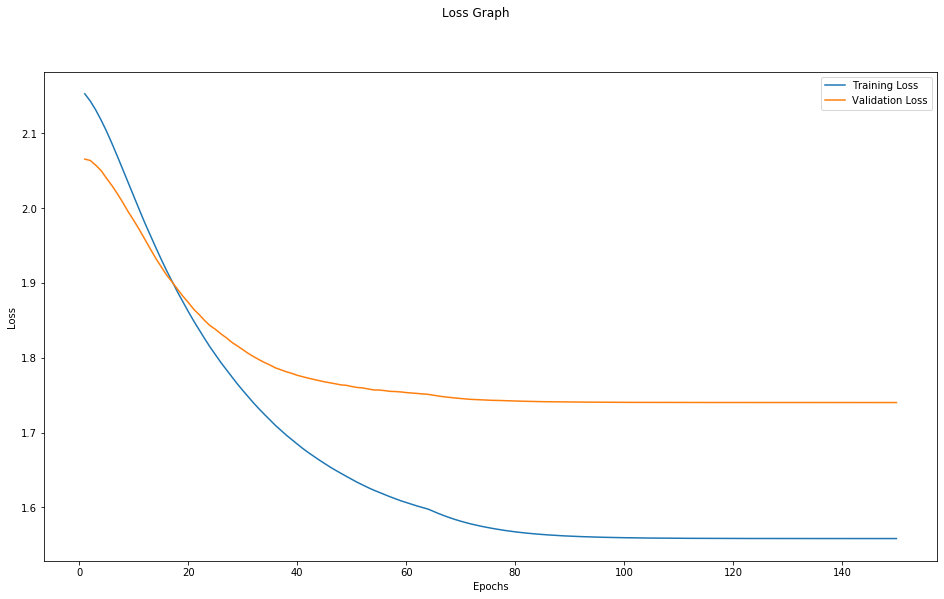

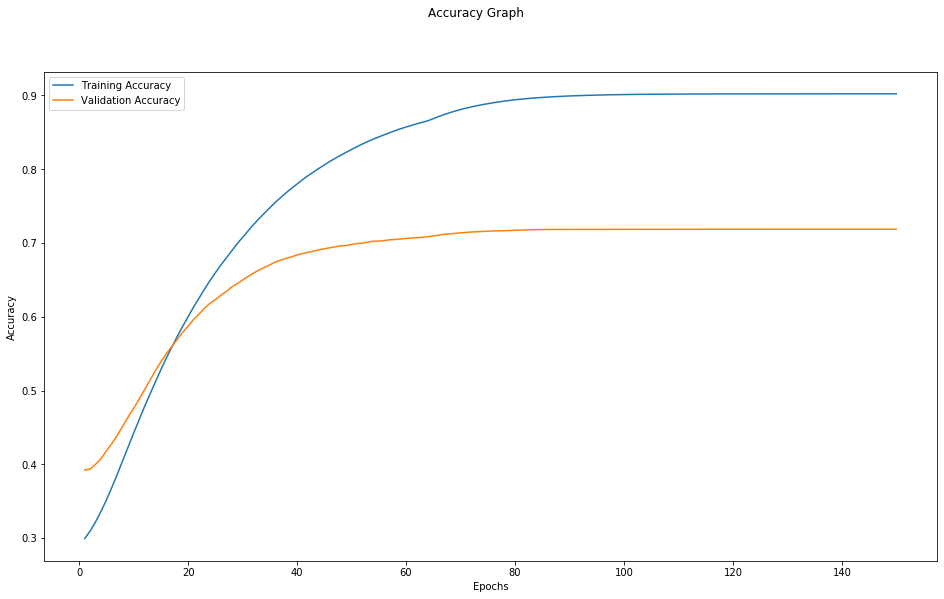

In [50]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

In [51]:
test_mse_score, test_acc_score = model.evaluate(test_data, test_labels)
test_acc_score

10000/10000 [==============================] - 2s 167us/sample - loss: 1.7471 - accuracy: 0.7115


0.7115

RMSProp

In [52]:
def build_model_RMS():
    
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu',
                      input_shape = (img_rows, img_cols, img_channels)),
        
        layers.Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
                      
        layers.Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Flatten(),
        
        layers.Dense(128),
        
        layers.Dense(10, activation = 'softmax')
    ])
    
    rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
    los = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    
    model.compile(optimizer = rmsprop, loss = los, metrics = ['accuracy'])
    return model

model = build_model_RMS()
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 8, 8, 128)       

In [53]:
num_epochs = 150
all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

model = build_model_RMS()

train_data_temp, test_data_temp, train_labels_temp, test_labels_temp = train_test_split(train_data, train_labels,
                                                                                        test_size=0.3)

lrate = keras.callbacks.ReduceLROnPlateau()
callbacks_list = [lrate]

history = model.fit(train_data_temp, train_labels_temp,validation_data=(test_data_temp, test_labels_temp),
                    epochs=num_epochs, batch_size = 64, callbacks=callbacks_list)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Train on 35000 samples, validate on 15000 samples
Epoch 1/150
35000/35000 [==============================] - 11s 309us/sample - loss: 2.1572 - accuracy: 0.2965 - val_loss: 2.0743 - val_accuracy: 0.3849
Epoch 2/150
35000/35000 [==============================] - 9s 259us/sample - loss: 2.0773 - accuracy: 0.3785 - val_loss: 2.0759 - val_accuracy: 0.3787
Epoch 3/150
35000/35000 [==============================] - 9s 256us/sample - loss: 2.0495 - accuracy: 0.4061 - val_loss: 2.0244 - val_accuracy: 0.4319
Epoch 4/150
35000/35000 [==============================] - 9s 257us/sample - loss: 2.0288 - accuracy: 0.4280 - val_loss: 2.0266 - val_accuracy: 0.4294
Epoch 5/150
35000/35000 [==============================] - 9s 256us/sample - loss: 2.0116 - accuracy: 0.4449 - val_loss: 1.9986 - val_accuracy: 0.4563
Epoch 6/150
35000/35000 [==============================] - 10s 291us/sample - loss: 1.9947 - accuracy: 0.4621 - val_loss: 1.9932 - val_accuracy: 0.4653
Epoch 7/150
35000/35000 [=================

Epoch 108/150
35000/35000 [==============================] - 10s 284us/sample - loss: 1.5492 - accuracy: 0.9112 - val_loss: 1.7294 - val_accuracy: 0.7299
Epoch 109/150
35000/35000 [==============================] - 10s 285us/sample - loss: 1.5491 - accuracy: 0.9113 - val_loss: 1.7294 - val_accuracy: 0.7297
Epoch 110/150
35000/35000 [==============================] - 10s 281us/sample - loss: 1.5491 - accuracy: 0.9113 - val_loss: 1.7294 - val_accuracy: 0.7298
Epoch 111/150
35000/35000 [==============================] - 10s 298us/sample - loss: 1.5490 - accuracy: 0.9113 - val_loss: 1.7293 - val_accuracy: 0.7303
Epoch 112/150
35000/35000 [==============================] - 10s 284us/sample - loss: 1.5490 - accuracy: 0.9113 - val_loss: 1.7295 - val_accuracy: 0.7301
Epoch 113/150
35000/35000 [==============================] - 10s 275us/sample - loss: 1.5490 - accuracy: 0.9113 - val_loss: 1.7295 - val_accuracy: 0.7297
Epoch 114/150
35000/35000 [==============================] - 10s 278us/sampl

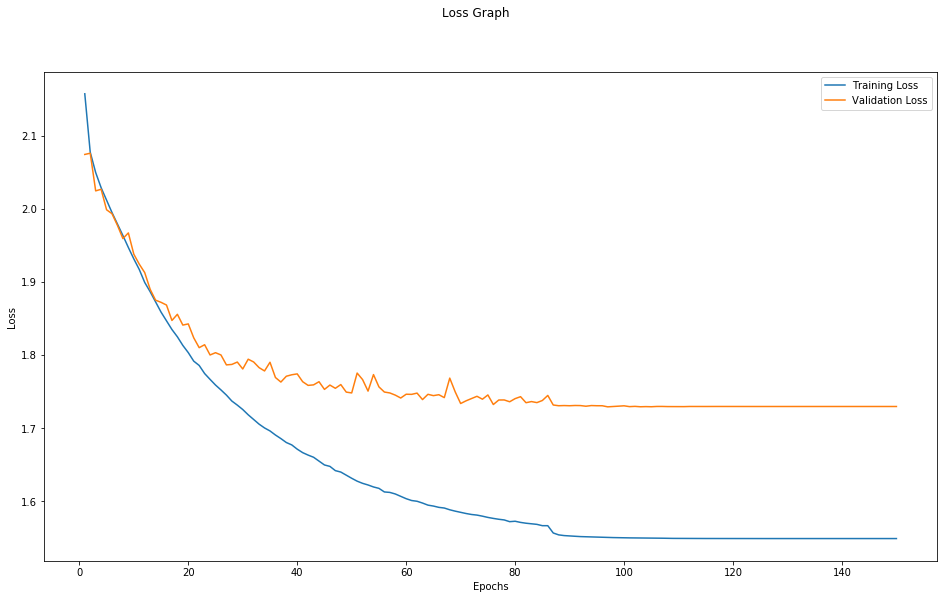

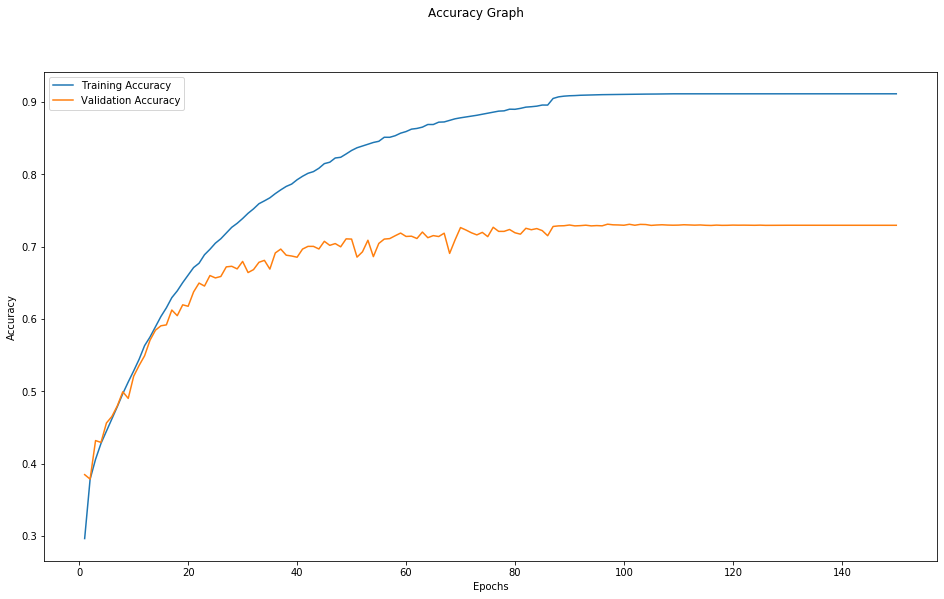

Smooth curve graphs of above graphs


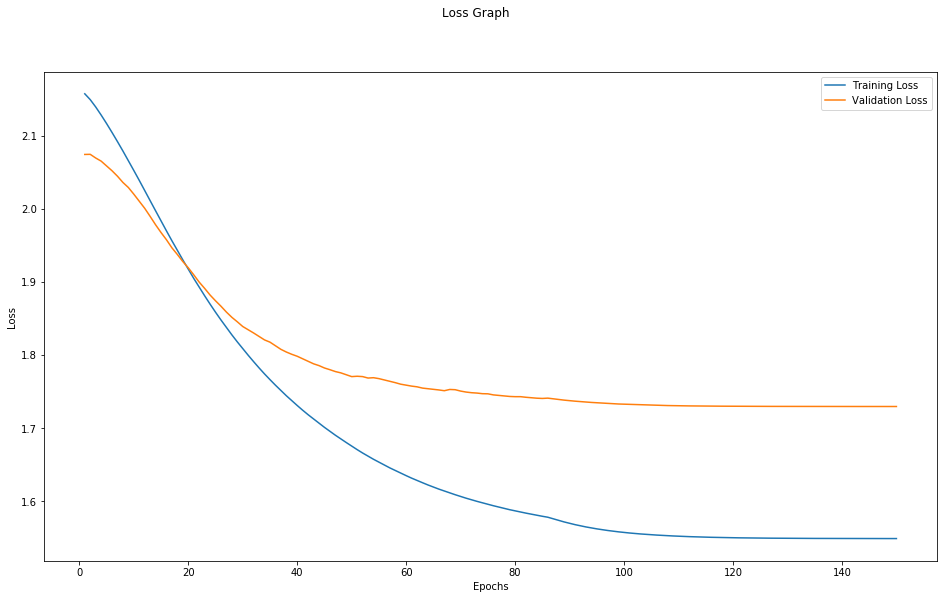

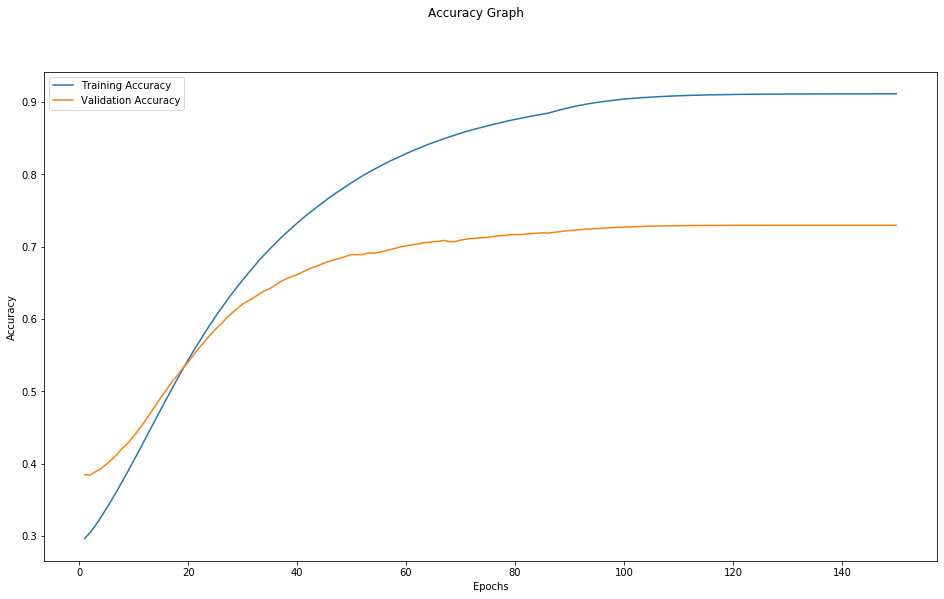

In [54]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

In [55]:
test_mse_score, test_acc_score = model.evaluate(test_data, test_labels)
test_acc_score

10000/10000 [==============================] - 2s 181us/sample - loss: 1.7339 - accuracy: 0.7245


0.7245

RMSProp with intializing kernels

In [56]:
def build_model_RMS():
    
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu',
                      input_shape = (img_rows, img_cols, img_channels)),
        
        layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
                      
        layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Conv2D(128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.Conv2D(128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Flatten(),
        
        layers.Dense(128),
        
        layers.Dense(10, activation = 'softmax')
    ])
    
    rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
    los = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    
    model.compile(optimizer = rmsprop, loss = los, metrics = ['accuracy'])
    return model

model = build_model_RMS()
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 8, 8, 128)       

In [57]:
num_epochs = 150
all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

model = build_model_RMS()

train_data_temp, test_data_temp, train_labels_temp, test_labels_temp = train_test_split(train_data, train_labels,
                                                                                        test_size=0.3)

lrate = keras.callbacks.ReduceLROnPlateau()
callbacks_list = [lrate]

history = model.fit(train_data_temp, train_labels_temp,validation_data=(test_data_temp, test_labels_temp),
                    epochs=num_epochs, batch_size = 64, callbacks=callbacks_list)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Train on 35000 samples, validate on 15000 samples
Epoch 1/150
35000/35000 [==============================] - 11s 317us/sample - loss: 2.1475 - accuracy: 0.3103 - val_loss: 2.0688 - val_accuracy: 0.3949
Epoch 2/150
35000/35000 [==============================] - 10s 272us/sample - loss: 2.0522 - accuracy: 0.4083 - val_loss: 2.0381 - val_accuracy: 0.4235
Epoch 3/150
35000/35000 [==============================] - 10s 273us/sample - loss: 2.0008 - accuracy: 0.4625 - val_loss: 2.0111 - val_accuracy: 0.4465
Epoch 4/150
35000/35000 [==============================] - 10s 279us/sample - loss: 1.9466 - accuracy: 0.5174 - val_loss: 1.9411 - val_accuracy: 0.5243
Epoch 5/150
35000/35000 [==============================] - 10s 278us/sample - loss: 1.9138 - accuracy: 0.5505 - val_loss: 1.9067 - val_accuracy: 0.5540
Epoch 6/150
35000/35000 [==============================] - 10s 276us/sample - loss: 1.8709 - accuracy: 0.5949 - val_loss: 1.8996 - val_accuracy: 0.5591
Epoch 7/150
35000/35000 [=============

Epoch 108/150
35000/35000 [==============================] - 9s 263us/sample - loss: 1.5387 - accuracy: 0.9215 - val_loss: 1.7396 - val_accuracy: 0.7195
Epoch 109/150
35000/35000 [==============================] - 10s 272us/sample - loss: 1.5387 - accuracy: 0.9215 - val_loss: 1.7396 - val_accuracy: 0.7195
Epoch 110/150
35000/35000 [==============================] - 10s 279us/sample - loss: 1.5387 - accuracy: 0.9215 - val_loss: 1.7396 - val_accuracy: 0.7195
Epoch 111/150
35000/35000 [==============================] - 9s 270us/sample - loss: 1.5387 - accuracy: 0.9215 - val_loss: 1.7396 - val_accuracy: 0.7195
Epoch 112/150
35000/35000 [==============================] - 9s 271us/sample - loss: 1.5387 - accuracy: 0.9215 - val_loss: 1.7396 - val_accuracy: 0.7195
Epoch 113/150
35000/35000 [==============================] - 10s 276us/sample - loss: 1.5387 - accuracy: 0.9215 - val_loss: 1.7396 - val_accuracy: 0.7195
Epoch 114/150
35000/35000 [==============================] - 9s 271us/sample - 

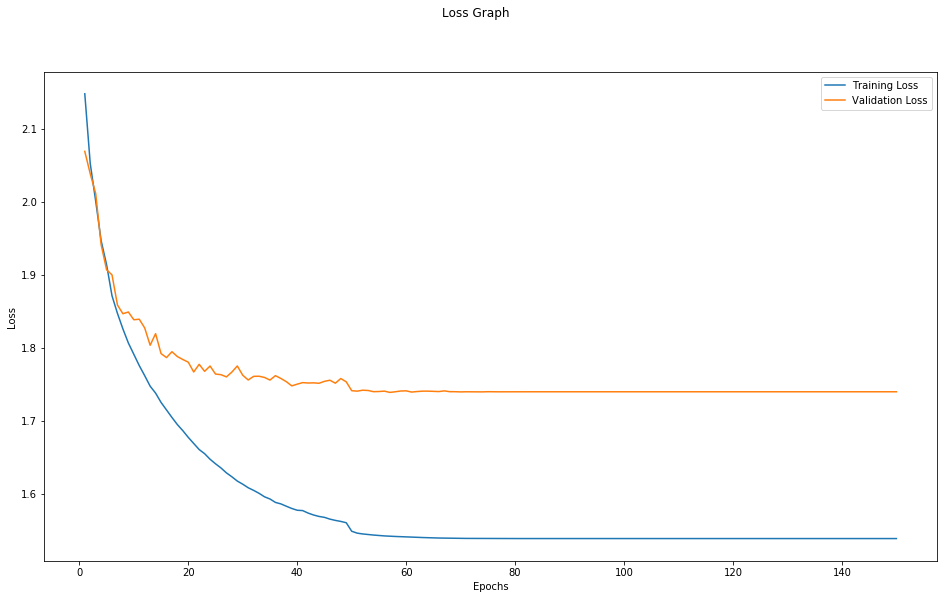

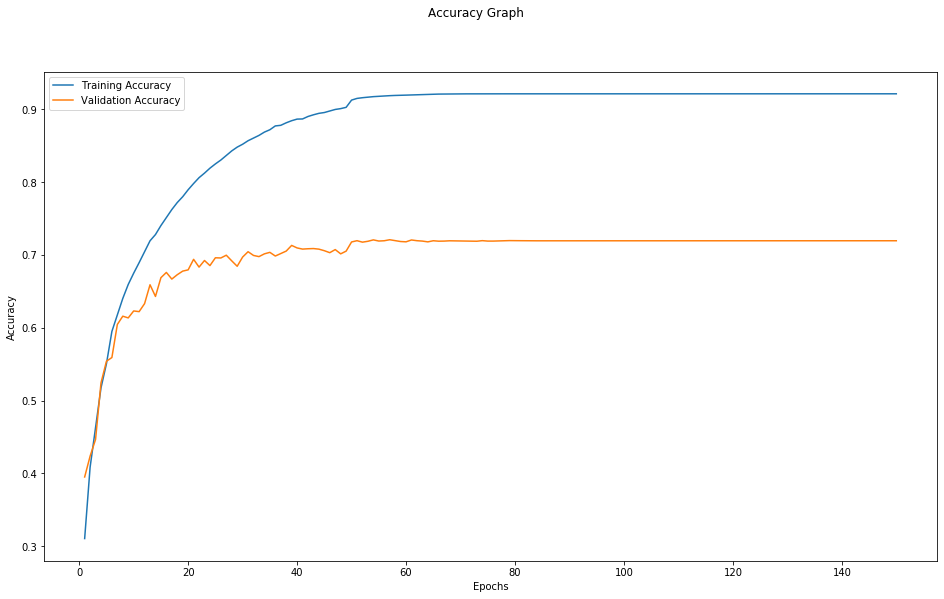

Smooth curve graphs of above graphs


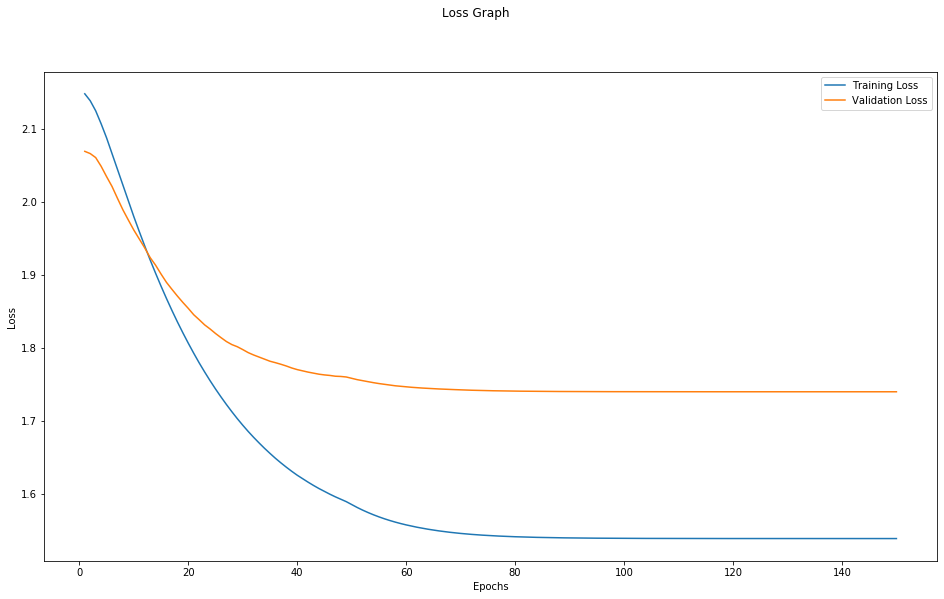

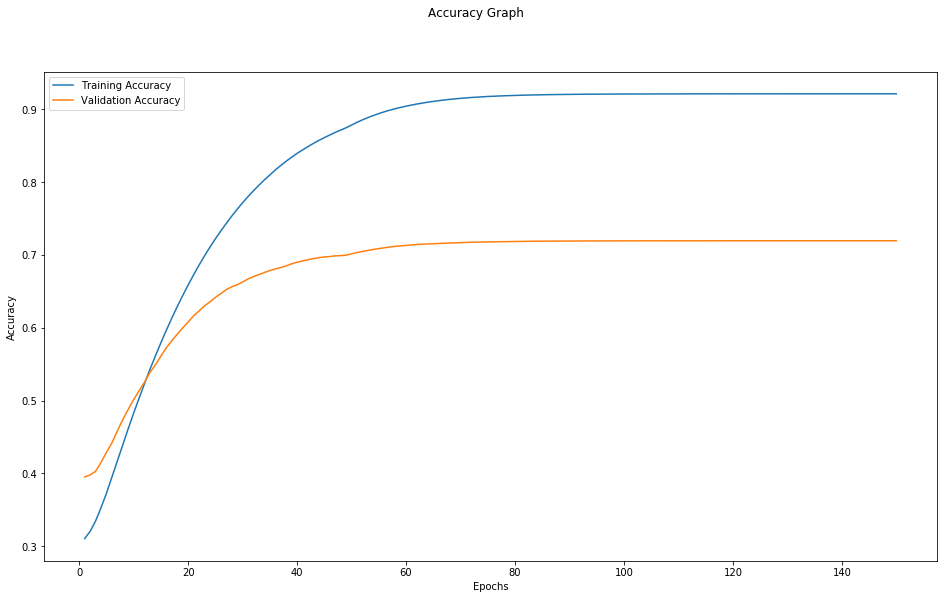

In [58]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

In [59]:
test_mse_score, test_acc_score = model.evaluate(test_data, test_labels)

10000/10000 [==============================] - 2s 174us/sample - loss: 1.7402 - accuracy: 0.7187


Above model with adding batch normalization and dropout layers

In [60]:
def build_model_RMS():
    
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu',
                      input_shape = (img_rows, img_cols, img_channels)),
        
        layers.BatchNormalization(),
        
        layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Dropout(0.2),
        
        layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
                      
        layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Dropout(0.3),
        
        layers.Conv2D(128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.Conv2D(128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Dropout(0.4),
        
        layers.Flatten(),
        
        layers.Dense(128),
        
        layers.BatchNormalization(),
        
        layers.Dropout(0.5),
        
        layers.Dense(10, activation = 'softmax')
    ])
    
    rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
    los = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    
    model.compile(optimizer = rmsprop, loss = los, metrics = ['accuracy'])
    return model

model = build_model_RMS()
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 16, 16, 64)      

In [61]:
num_epochs = 150
all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

model = build_model_RMS()

train_data_temp, test_data_temp, train_labels_temp, test_labels_temp = train_test_split(train_data, train_labels,
                                                                                        test_size=0.3)

lrate = keras.callbacks.ReduceLROnPlateau()
callbacks_list = [lrate]

history = model.fit(train_data_temp, train_labels_temp,validation_data=(test_data_temp, test_labels_temp),
                    epochs=num_epochs, batch_size = 64, callbacks=callbacks_list)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Train on 35000 samples, validate on 15000 samples
Epoch 1/150
35000/35000 [==============================] - 15s 422us/sample - loss: 2.1567 - accuracy: 0.2976 - val_loss: 2.1095 - val_accuracy: 0.3428
Epoch 2/150
35000/35000 [==============================] - 11s 318us/sample - loss: 2.0410 - accuracy: 0.4230 - val_loss: 2.0396 - val_accuracy: 0.4206
Epoch 3/150
35000/35000 [==============================] - 11s 315us/sample - loss: 1.9921 - accuracy: 0.4746 - val_loss: 1.9922 - val_accuracy: 0.4711
Epoch 4/150
35000/35000 [==============================] - 11s 315us/sample - loss: 1.9624 - accuracy: 0.5049 - val_loss: 1.9763 - val_accuracy: 0.4845
Epoch 5/150
35000/35000 [==============================] - 11s 313us/sample - loss: 1.9398 - accuracy: 0.5276 - val_loss: 1.9518 - val_accuracy: 0.5131
Epoch 6/150
35000/35000 [==============================] - 11s 312us/sample - loss: 1.9161 - accuracy: 0.5503 - val_loss: 1.9158 - val_accuracy: 0.5499
Epoch 7/150
35000/35000 [=============

35000/35000 [==============================] - 11s 319us/sample - loss: 1.5919 - accuracy: 0.8717 - val_loss: 1.6408 - val_accuracy: 0.8199
Epoch 108/150
35000/35000 [==============================] - 11s 314us/sample - loss: 1.5951 - accuracy: 0.8689 - val_loss: 1.6403 - val_accuracy: 0.8214
Epoch 109/150
35000/35000 [==============================] - 11s 318us/sample - loss: 1.5930 - accuracy: 0.8712 - val_loss: 1.6401 - val_accuracy: 0.8211
Epoch 110/150
35000/35000 [==============================] - 11s 323us/sample - loss: 1.5925 - accuracy: 0.8717 - val_loss: 1.6410 - val_accuracy: 0.8207
Epoch 111/150
35000/35000 [==============================] - 11s 326us/sample - loss: 1.5917 - accuracy: 0.8736 - val_loss: 1.6405 - val_accuracy: 0.8197
Epoch 112/150
35000/35000 [==============================] - 11s 323us/sample - loss: 1.5928 - accuracy: 0.8717 - val_loss: 1.6400 - val_accuracy: 0.8204
Epoch 113/150
35000/35000 [==============================] - 11s 307us/sample - loss: 1.59

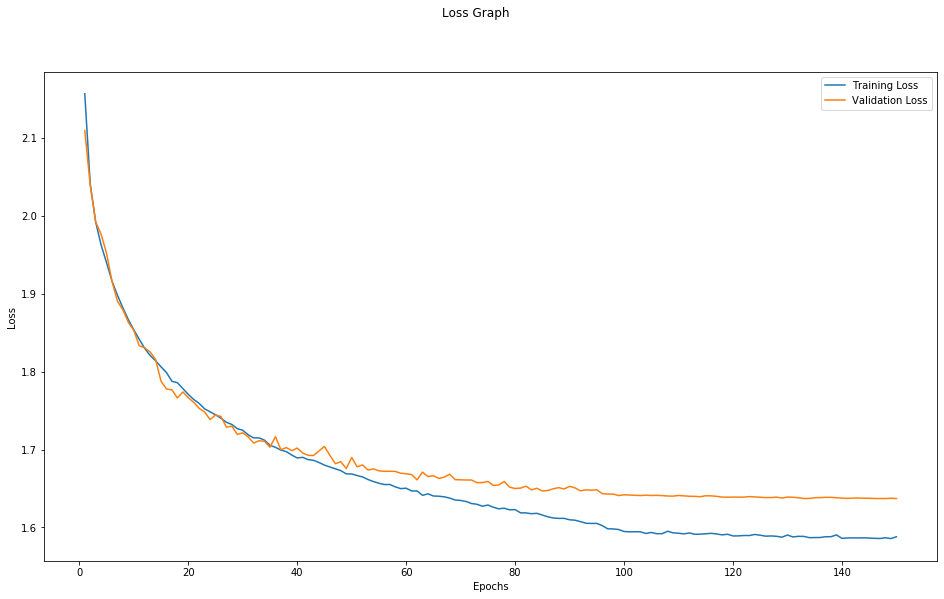

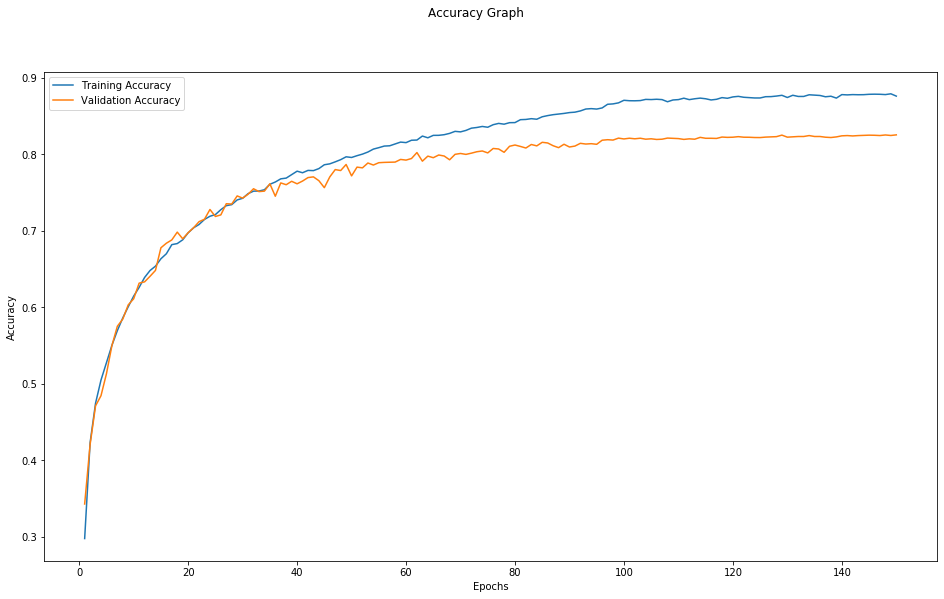

Smooth curve graphs of above graphs


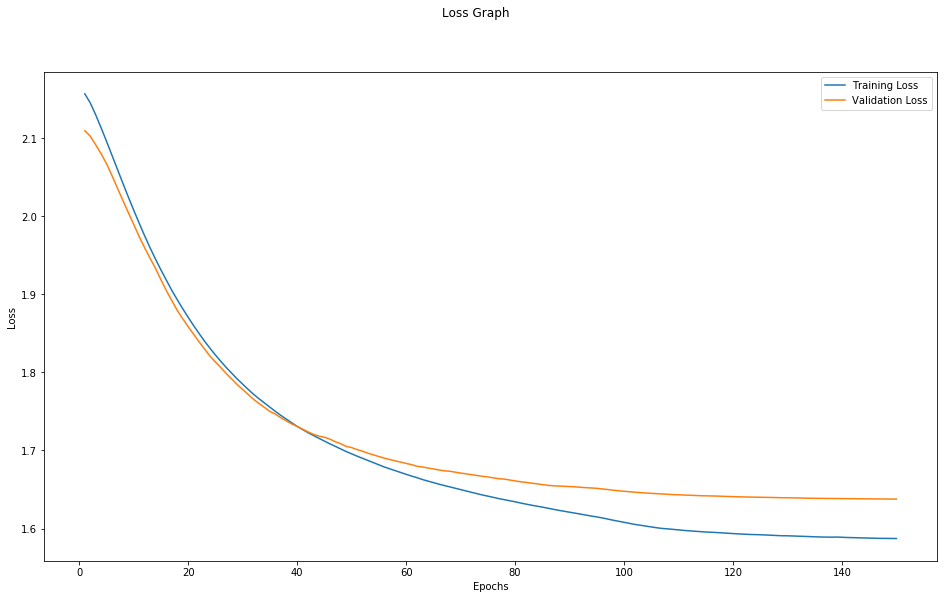

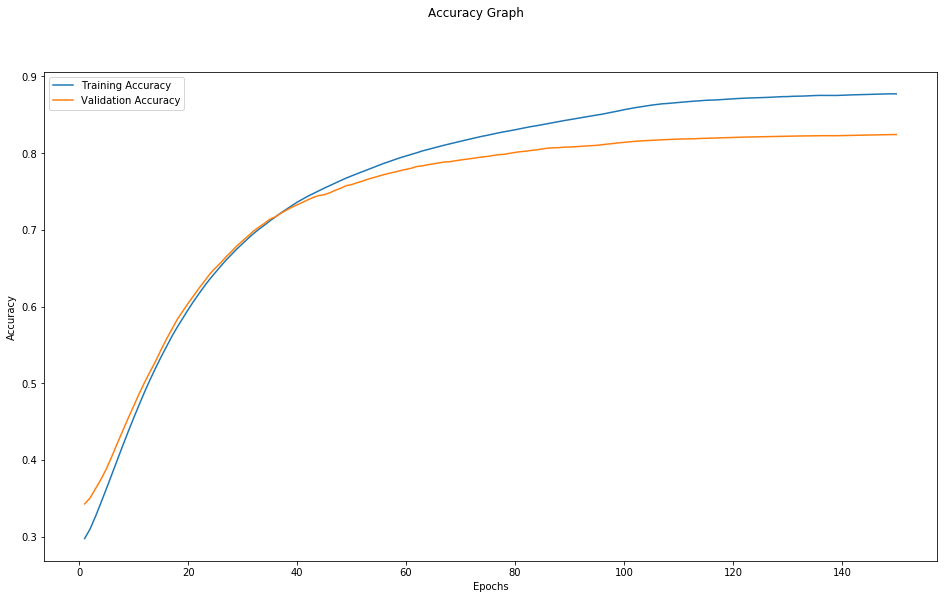

In [62]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

In [63]:
test_mse_score, test_acc_score = model.evaluate(test_data, test_labels)

10000/10000 [==============================] - 2s 222us/sample - loss: 1.6454 - accuracy: 0.8160


Above model with adding data augmentation

In [64]:
def build_model_RMS():
    
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu',
                      input_shape = (img_rows, img_cols, img_channels)),
        
        layers.BatchNormalization(),
        
        layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Dropout(0.2),
        
        layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
                      
        layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Dropout(0.3),
        
        layers.Conv2D(128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.Conv2D(128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Dropout(0.4),
        
        layers.Flatten(),
        
        layers.Dense(128),
        
        layers.BatchNormalization(),
        
        layers.Dropout(0.5),
        
        layers.Dense(10, activation = 'softmax')
    ])
    
    rmsprop = keras.optimizers.RMSprop(learning_rate=0.0005)
    los = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    
    model.compile(optimizer = rmsprop, loss = los, metrics = ['accuracy'])
    return model

model = build_model_RMS()
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_141 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 16, 16, 64)      

In [65]:
num_epochs = 150

train_data_temp, test_data_temp, train_labels_temp, test_labels_temp = train_test_split(train_data, train_labels,
                                                                                        test_size=0.3)

datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
steps = int(train_data_temp.shape[0] / 64)
datagen.fit(train_data_temp)
it_train = datagen.flow(train_data_temp, train_labels_temp, batch_size=64)

all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

model = build_model_RMS()

lrate = keras.callbacks.ReduceLROnPlateau()
callbacks_list = [lrate]

history = model.fit_generator(it_train, epochs=num_epochs, steps_per_epoch=steps, 
                                  validation_data=(test_data_temp, test_labels_temp), 
                                  callbacks=callbacks_list)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)    

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 546 steps, validate on 15000 samples
Epoch 1/150
546/546 [==============================] - 24s 43ms/step - loss: 2.0717 - accuracy: 0.3857 - val_loss: 1.9581 - val_accuracy: 0.5027
Epoch 2/150
546/546 [==============================] - 20s 37ms/step - loss: 1.9702 - accuracy: 0.4932 - val_loss: 1.9735 - val_accuracy: 0.4843
Epoch 3/150
546/546 [==============================] - 19s 35ms/step - loss: 1.9219 - accuracy: 0.5414 - val_loss: 1.8933 - val_accuracy: 0.5640
Epoch 4/150
546/546 [==============================] - 18s 34ms/step - loss: 1.8901 - accuracy: 0.5730 - val_loss: 1.8741 - val_accuracy: 0.5857
Epoch 5/150
546/546 [==============================] - 23s 42ms/step - loss: 1.8654 - accuracy: 0.5982 - val_loss: 1.8653 - val_accuracy: 0.5941
Epoch 6/150
546/546 [==============================] - 21s 38ms/step - loss: 1.8427 - accuracy: 0.6197 - val_loss: 1.8416 - val

546/546 [==============================] - 23s 42ms/step - loss: 1.6213 - accuracy: 0.8395 - val_loss: 1.6306 - val_accuracy: 0.8297
Epoch 111/150
546/546 [==============================] - 22s 41ms/step - loss: 1.6223 - accuracy: 0.8392 - val_loss: 1.6293 - val_accuracy: 0.8315
Epoch 112/150
546/546 [==============================] - 27s 49ms/step - loss: 1.6237 - accuracy: 0.8379 - val_loss: 1.6301 - val_accuracy: 0.8301
Epoch 113/150
546/546 [==============================] - 28s 50ms/step - loss: 1.6211 - accuracy: 0.8401 - val_loss: 1.6300 - val_accuracy: 0.8299
Epoch 114/150
546/546 [==============================] - 25s 46ms/step - loss: 1.6219 - accuracy: 0.8393 - val_loss: 1.6302 - val_accuracy: 0.8297
Epoch 115/150
546/546 [==============================] - 26s 47ms/step - loss: 1.6210 - accuracy: 0.8404 - val_loss: 1.6292 - val_accuracy: 0.8304
Epoch 116/150
546/546 [==============================] - 27s 50ms/step - loss: 1.6225 - accuracy: 0.8391 - val_loss: 1.6297 - val_ac

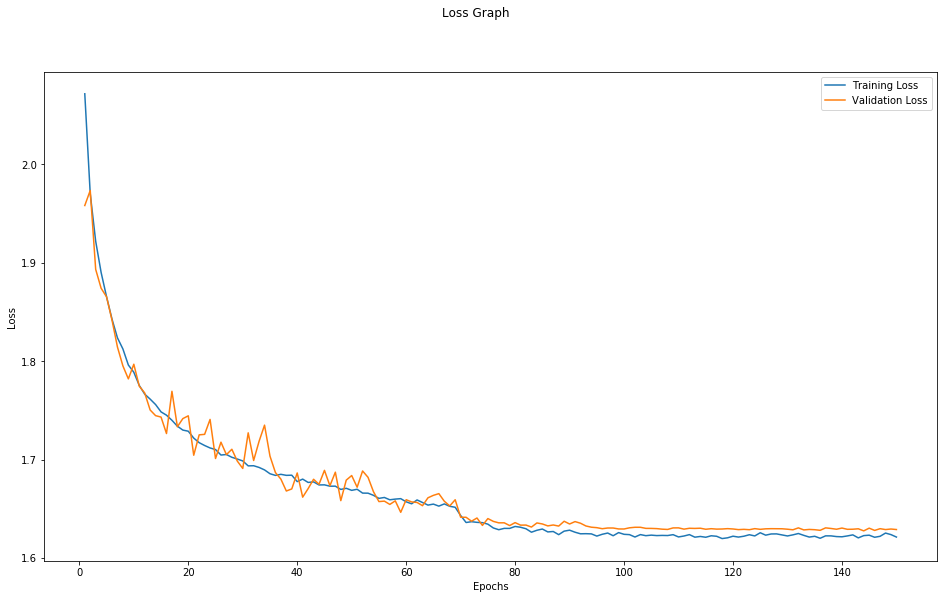

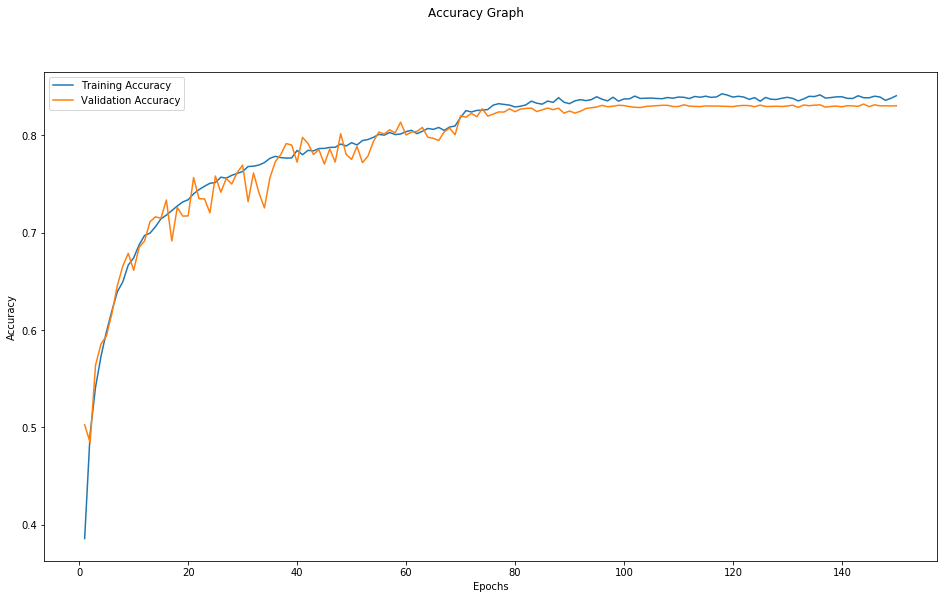

Smooth curve graphs of above graphs


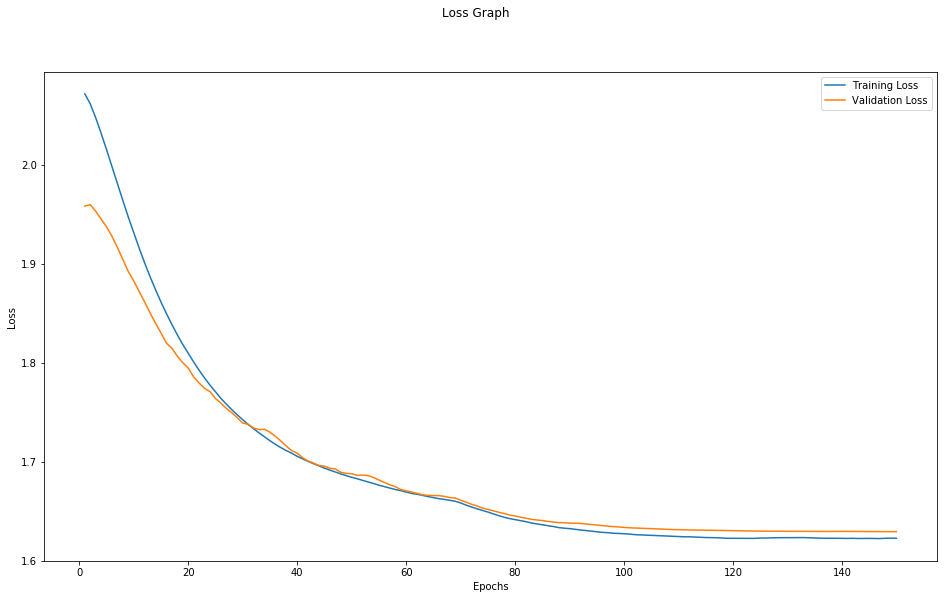

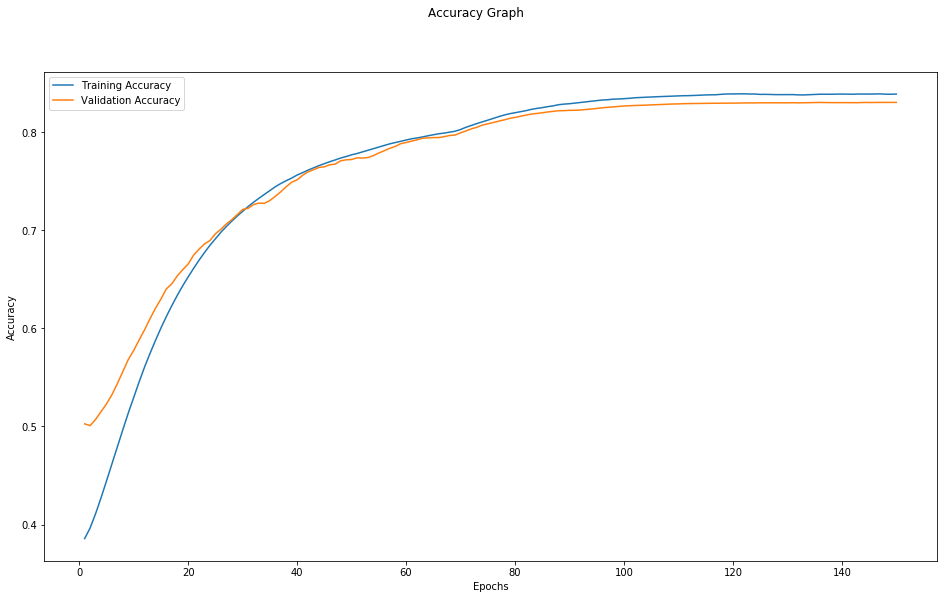

In [66]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

In [67]:
test_mse_score, test_acc_score = model.evaluate(test_data, test_labels)

10000/10000 [==============================] - 2s 152us/sample - loss: 1.6295 - accuracy: 0.8315


Building final model using above model with custom learning rate schedular instead of ReduceLR On Plateau

In [68]:
def build_model_RMS():
    
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu',
                      input_shape = (img_rows, img_cols, img_channels)),
        
        layers.BatchNormalization(),
        
        layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Dropout(0.2),
        
        layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
                      
        layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Dropout(0.3),
        
        layers.Conv2D(128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.Conv2D(128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Dropout(0.4),
        
        layers.Flatten(),
        
        layers.Dense(128),
        
        layers.BatchNormalization(),
        
        layers.Dropout(0.5),
        
        layers.Dense(10, activation = 'softmax')
    ])
    
    rmsprop = keras.optimizers.RMSprop(learning_rate=0.001, decay = 1e-6)
    los = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    
    model.compile(optimizer = rmsprop, loss = los, metrics = ['accuracy'])
    return model

model = build_model_RMS()
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_153 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 16, 16, 64)      

In [69]:
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
steps = int(train_data.shape[0] / 64)
datagen.fit(train_data)
it_train = datagen.flow(train_data, train_labels, batch_size=64)

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 45:
        lrate = 0.0007
    if epoch > 60:
        lrate = 0.0006
    if epoch > 90:
        lrate = 0.0005
    if epoch > 120:
        lrate = 0.0004
    if epoch > 140:
        lrate = 0.0003
    return lrate

k=1
num_epochs = 150
all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

for i in range(k):
    print('processing fold #', i+1)
    
    model = build_model_RMS()
    
    history = model.fit_generator(it_train, epochs=num_epochs, steps_per_epoch=steps, 
                                  validation_data=(test_data, test_labels), callbacks=[keras.callbacks.LearningRateScheduler(lr_schedule)])

    accuracy_history = history.history['accuracy']
    val_accuracy_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']

    all_accuracy_histories.append(accuracy_history)
    all_val_accuracy_histories.append(val_accuracy_history)
    all_loss_histories.append(loss_history)
    all_val_loss_histories.append(val_loss_history)

processing fold # 1
  ...
    to  
  ['...']
Train for 781 steps, validate on 10000 samples
Epoch 1/150
781/781 [==============================] - 34s 43ms/step - loss: 2.0422 - accuracy: 0.4146 - val_loss: 2.0299 - val_accuracy: 0.4247
Epoch 2/150
781/781 [==============================] - 34s 44ms/step - loss: 1.9304 - accuracy: 0.5286 - val_loss: 1.9098 - val_accuracy: 0.5494
Epoch 3/150
781/781 [==============================] - 32s 41ms/step - loss: 1.8752 - accuracy: 0.5857 - val_loss: 1.8149 - val_accuracy: 0.6464
Epoch 4/150
781/781 [==============================] - 31s 40ms/step - loss: 1.8374 - accuracy: 0.6246 - val_loss: 1.8164 - val_accuracy: 0.6444
Epoch 5/150
781/781 [==============================] - 33s 42ms/step - loss: 1.8123 - accuracy: 0.6491 - val_loss: 1.8350 - val_accuracy: 0.6241
Epoch 6/150
781/781 [==============================] - 33s 42ms/step - loss: 1.7921 - accuracy: 0.6695 - val_loss: 1.7610 - val_accuracy: 0.6990
Epoch 7/150
781/781 [=================

781/781 [==============================] - 32s 41ms/step - loss: 1.6150 - accuracy: 0.8459 - val_loss: 1.6192 - val_accuracy: 0.8413
Epoch 113/150
781/781 [==============================] - 31s 39ms/step - loss: 1.6142 - accuracy: 0.8462 - val_loss: 1.6273 - val_accuracy: 0.8331
Epoch 114/150
781/781 [==============================] - 33s 42ms/step - loss: 1.6147 - accuracy: 0.8459 - val_loss: 1.6112 - val_accuracy: 0.8491
Epoch 115/150
781/781 [==============================] - 33s 42ms/step - loss: 1.6136 - accuracy: 0.8470 - val_loss: 1.6060 - val_accuracy: 0.8543
Epoch 116/150
781/781 [==============================] - 44s 56ms/step - loss: 1.6156 - accuracy: 0.8453 - val_loss: 1.6144 - val_accuracy: 0.8463
Epoch 117/150
781/781 [==============================] - 32s 41ms/step - loss: 1.6151 - accuracy: 0.8455 - val_loss: 1.6088 - val_accuracy: 0.8513
Epoch 118/150
781/781 [==============================] - 33s 42ms/step - loss: 1.6129 - accuracy: 0.8481 - val_loss: 1.6154 - val_ac

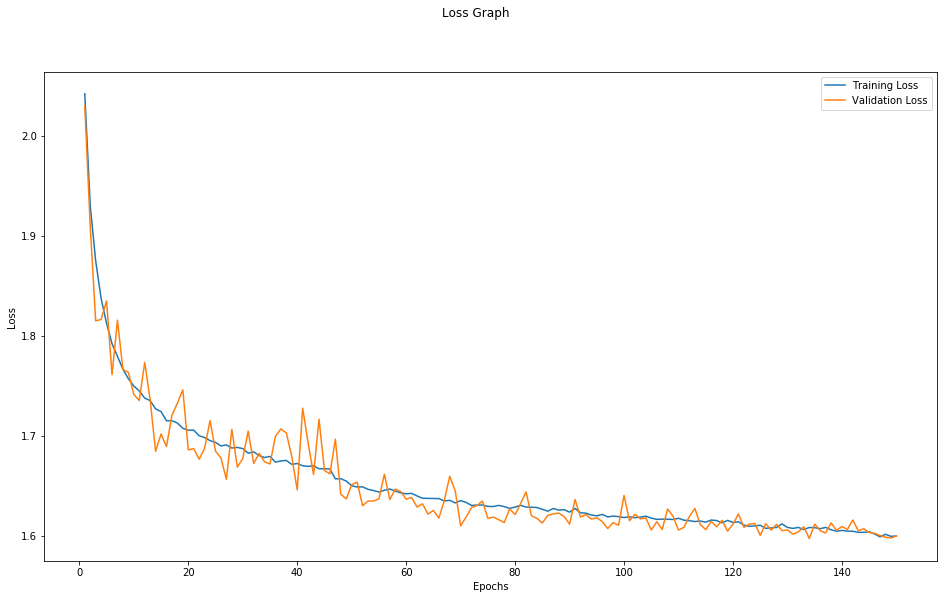

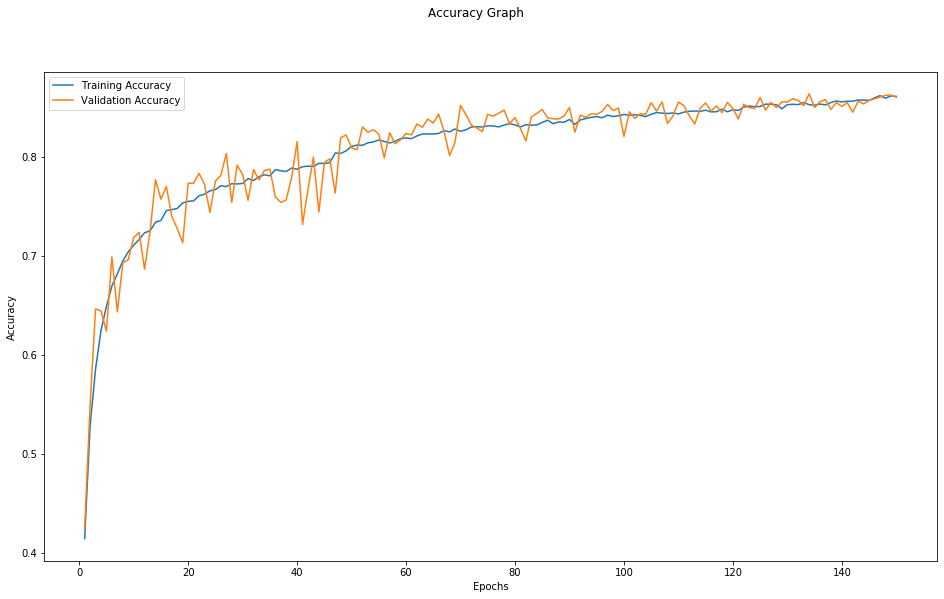

Smooth curve graphs of above graphs


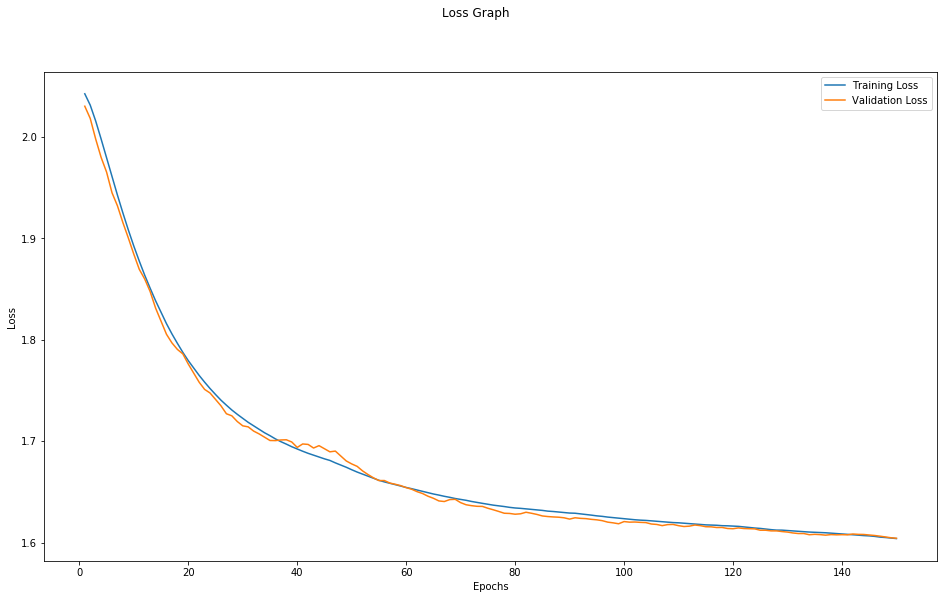

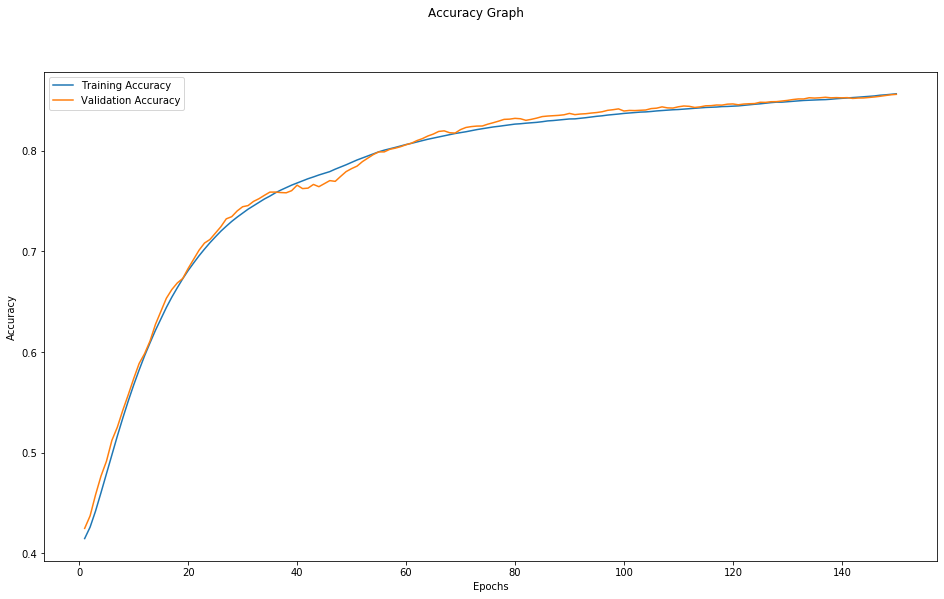

In [70]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

In [71]:
model.save("modelfinal.h5")

Using GAP instead of FC layers on above model

In [72]:
def build_model_RMS():
    
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu',
                      input_shape = (img_rows, img_cols, img_channels)),
        
        layers.BatchNormalization(),
        
        layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Dropout(0.2),
        
        layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
                      
        layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Dropout(0.3),
        
        layers.Conv2D(128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.Conv2D(128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),
        
        layers.Dropout(0.4),
        
        layers.Conv2D(10, kernel_size=(3, 3), kernel_initializer='he_uniform', padding = 'same', activation='relu'),
        
        layers.BatchNormalization(),
        
        layers.GlobalAveragePooling2D()
    ])
    
    
    rmsprop = keras.optimizers.RMSprop(learning_rate=0.001, decay = 1e-6)
    los = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    
    model.compile(optimizer = rmsprop, loss = los, metrics = ['accuracy'])
    return model

model = build_model_RMS()
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_165 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_42 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_43 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 16, 16, 64)      

In [73]:
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
steps = int(train_data.shape[0] / 64)
datagen.fit(train_data)
it_train = datagen.flow(train_data, train_labels, batch_size=64)

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 45:
        lrate = 0.0007
    if epoch > 60:
        lrate = 0.0006
    if epoch > 90:
        lrate = 0.0005
    if epoch > 120:
        lrate = 0.0004
    if epoch > 140:
        lrate = 0.0003
    return lrate

k=1
num_epochs = 150
all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

for i in range(k):
    print('processing fold #', i+1)
    
    model = build_model_RMS()
    
    history = model.fit_generator(it_train, epochs=num_epochs, steps_per_epoch=steps, 
                                  validation_data=(test_data, test_labels), callbacks=[keras.callbacks.LearningRateScheduler(lr_schedule)])

    accuracy_history = history.history['accuracy']
    val_accuracy_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']

    all_accuracy_histories.append(accuracy_history)
    all_val_accuracy_histories.append(val_accuracy_history)
    all_loss_histories.append(loss_history)
    all_val_loss_histories.append(val_loss_history)

processing fold # 1
  ...
    to  
  ['...']
Train for 781 steps, validate on 10000 samples
Epoch 1/150
781/781 [==============================] - 31s 40ms/step - loss: 1.4494 - accuracy: 0.4993 - val_loss: 1.1620 - val_accuracy: 0.5972
Epoch 2/150
781/781 [==============================] - 33s 42ms/step - loss: 1.0997 - accuracy: 0.6293 - val_loss: 0.9982 - val_accuracy: 0.6560
Epoch 3/150
781/781 [==============================] - 33s 42ms/step - loss: 0.9463 - accuracy: 0.6802 - val_loss: 0.9654 - val_accuracy: 0.6855
Epoch 4/150
781/781 [==============================] - 32s 41ms/step - loss: 0.8579 - accuracy: 0.7104 - val_loss: 0.7568 - val_accuracy: 0.7461
Epoch 5/150
781/781 [==============================] - 31s 39ms/step - loss: 0.7995 - accuracy: 0.7269 - val_loss: 0.8823 - val_accuracy: 0.7088
Epoch 6/150
781/781 [==============================] - 32s 41ms/step - loss: 0.7545 - accuracy: 0.7441 - val_loss: 0.6966 - val_accuracy: 0.7664
Epoch 7/150
781/781 [=================

781/781 [==============================] - 32s 41ms/step - loss: 0.3104 - accuracy: 0.8928 - val_loss: 0.4314 - val_accuracy: 0.8658
Epoch 113/150
781/781 [==============================] - 33s 42ms/step - loss: 0.3052 - accuracy: 0.8941 - val_loss: 0.3483 - val_accuracy: 0.8874
Epoch 114/150
781/781 [==============================] - 31s 40ms/step - loss: 0.3112 - accuracy: 0.8927 - val_loss: 0.4300 - val_accuracy: 0.8660
Epoch 115/150
781/781 [==============================] - 32s 40ms/step - loss: 0.3078 - accuracy: 0.8939 - val_loss: 0.3575 - val_accuracy: 0.8868
Epoch 116/150
781/781 [==============================] - 31s 40ms/step - loss: 0.3054 - accuracy: 0.8947 - val_loss: 0.3970 - val_accuracy: 0.8770
Epoch 117/150
781/781 [==============================] - 32s 41ms/step - loss: 0.3085 - accuracy: 0.8933 - val_loss: 0.3646 - val_accuracy: 0.8822
Epoch 118/150
781/781 [==============================] - 32s 40ms/step - loss: 0.3033 - accuracy: 0.8939 - val_loss: 0.3697 - val_ac

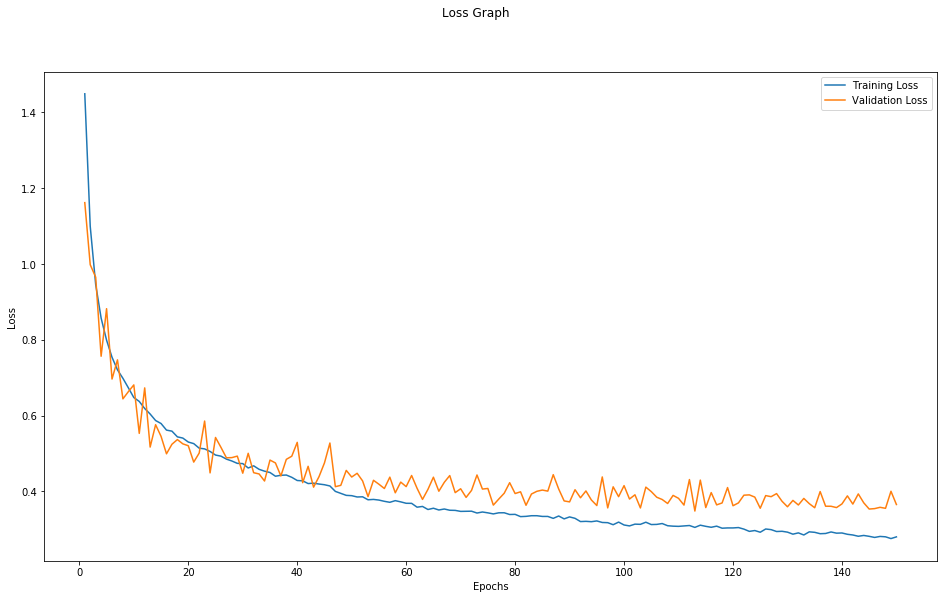

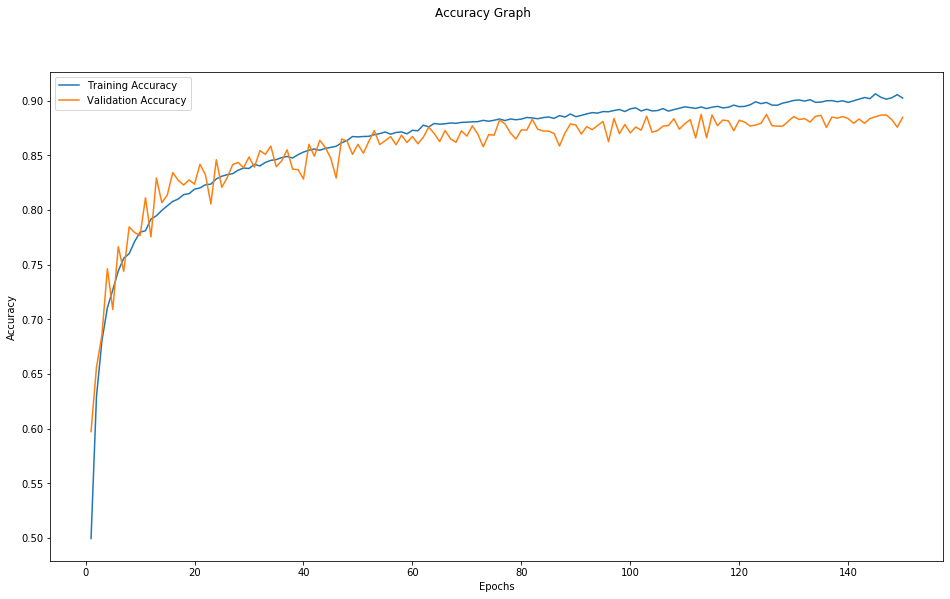

Smooth curve graphs of above graphs


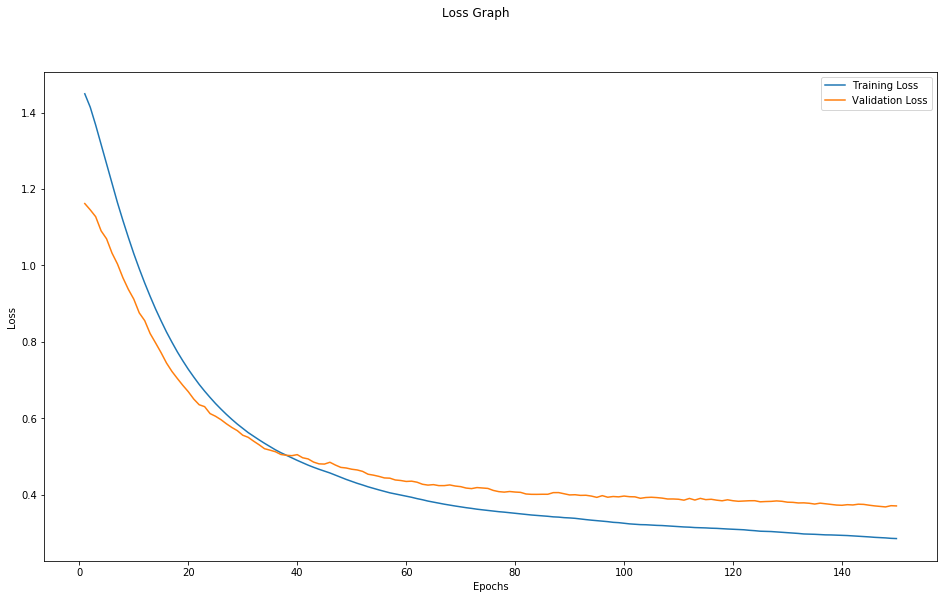

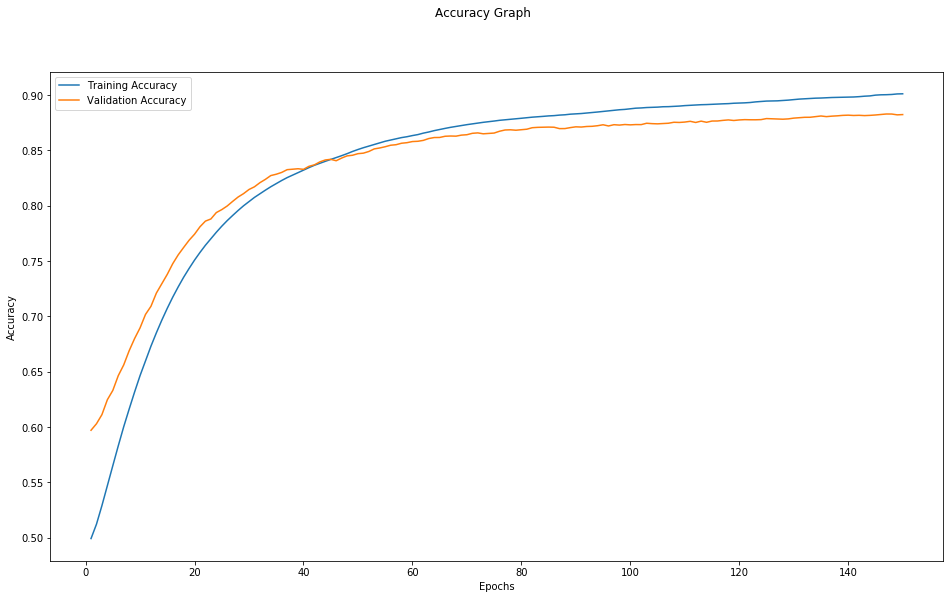

In [74]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

Part 4: Transfer Learning<br>
4.1 Save your best performed model in Part 3. Then reload the saved module and continue to train for 10 epochs. Show both your training accuracy and validation accuracy curves

In [75]:
model.save("model.h5")

In [76]:
tmodel = load_model("modelfinal.h5")
tmodel.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_159 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_35 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 16, 16, 64)      

In [77]:
(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

In [78]:
batch_size = 64
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
steps = int(train_data.shape[0] / batch_size)
datagen.fit(train_data)
it_train = datagen.flow(train_data, train_labels, batch_size=64)

num_epochs = 10
all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

def lr_schedule(epoch):
    lrate = 0.0003
    return lrate


history = tmodel.fit_generator(it_train, epochs=num_epochs, steps_per_epoch=steps, 
                               validation_data=(test_data, test_labels),
                               callbacks=[keras.callbacks.LearningRateScheduler(lr_schedule)])

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

  ...
    to  
  ['...']
Train for 781 steps, validate on 10000 samples
Epoch 1/10
781/781 [==============================] - 32s 40ms/step - loss: 1.6128 - accuracy: 0.8478 - val_loss: 1.6098 - val_accuracy: 0.8506
Epoch 2/10
781/781 [==============================] - 32s 41ms/step - loss: 1.6092 - accuracy: 0.8514 - val_loss: 1.6084 - val_accuracy: 0.8519
Epoch 3/10
781/781 [==============================] - 32s 41ms/step - loss: 1.6093 - accuracy: 0.8513 - val_loss: 1.6065 - val_accuracy: 0.8536
Epoch 4/10
781/781 [==============================] - 33s 42ms/step - loss: 1.6092 - accuracy: 0.8515 - val_loss: 1.5985 - val_accuracy: 0.8625
Epoch 5/10
781/781 [==============================] - 33s 42ms/step - loss: 1.6075 - accuracy: 0.8528 - val_loss: 1.6181 - val_accuracy: 0.8419
Epoch 6/10
781/781 [==============================] - 32s 41ms/step - loss: 1.6047 - accuracy: 0.8567 - val_loss: 1.6039 - val_accuracy: 0.8576
Epoch 7/10
781/781 [==============================] - 32s 41ms/s

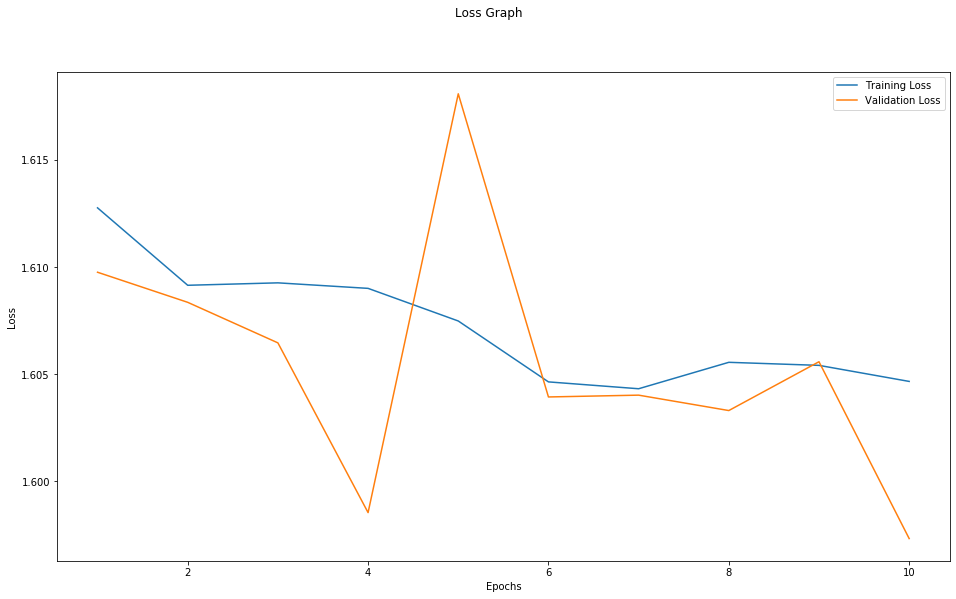

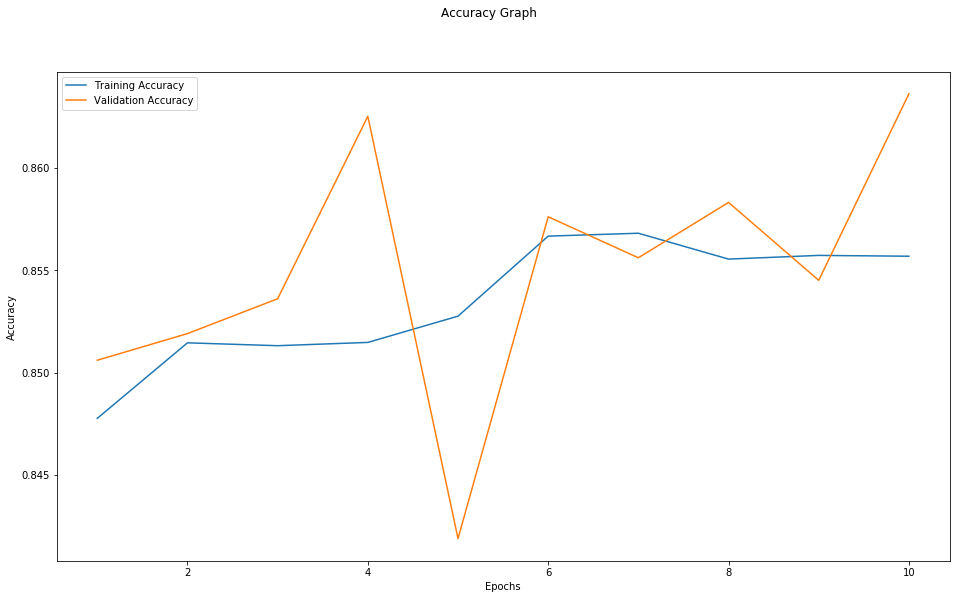

Smooth curve graphs of above graphs


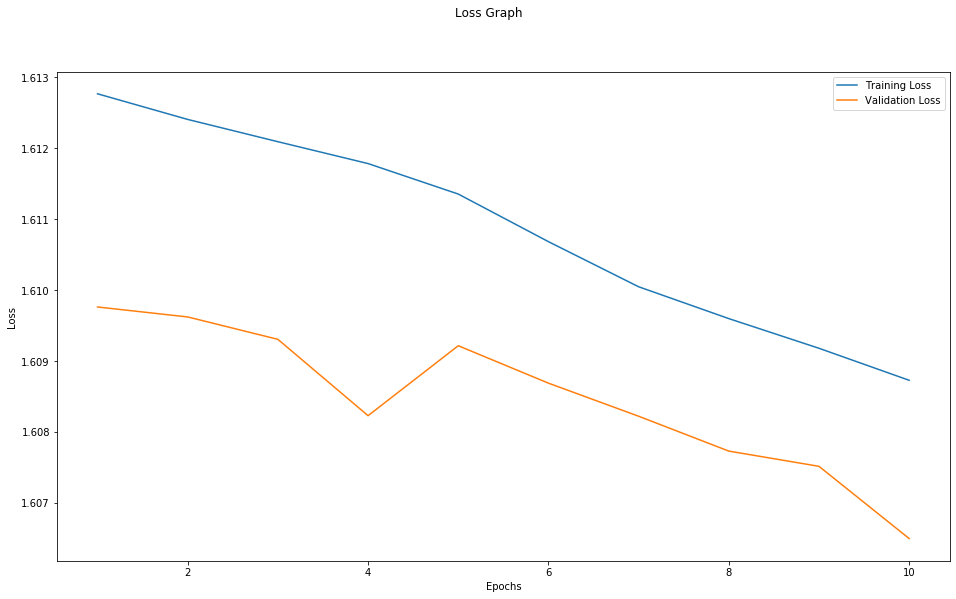

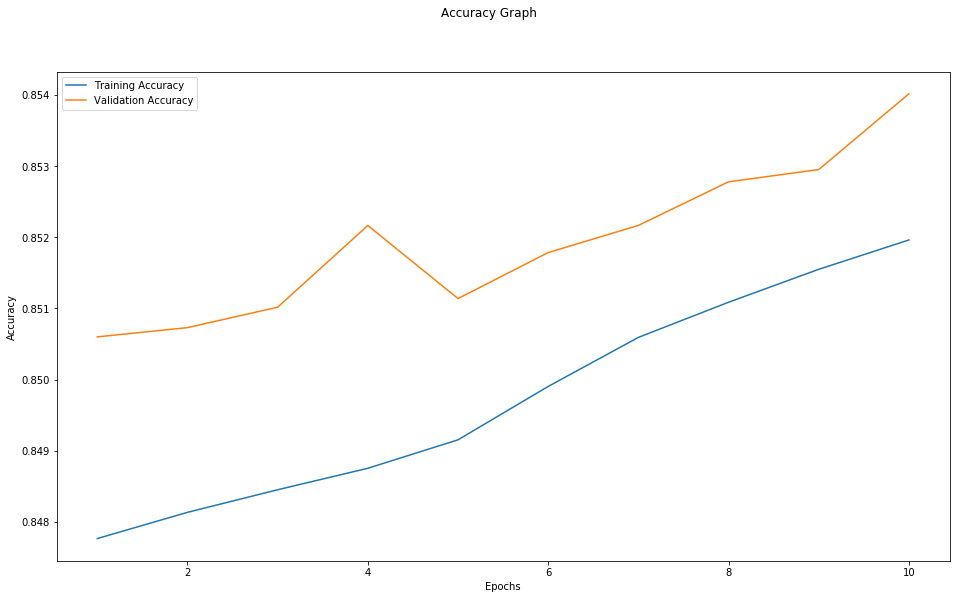

In [79]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

4.2 Save your newly trained model in 4.1, then reload it. Fix the weights in all the layers before the classification layer(s), and continue to train the classification layer(s) only for another 10 epochs, show both your training and validation curves.

In [80]:
tmodel.save("model4.1.h5")

In [81]:
model4 = load_model("model4.1.h5")
model4.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_159 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_35 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 16, 16, 64)      

In [82]:
for l in range(len(model4.layers)-1):
    model4.layers[l].trainable = False
    

rmsprop = keras.optimizers.RMSprop(learning_rate=0.0003, decay = 1e-6)
los = keras.losses.SparseCategoricalCrossentropy(from_logits = True)

model4.compile(optimizer = rmsprop, loss = los, metrics = ['accuracy'])
model4.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_159 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_35 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 16, 16, 64)      

In [83]:
batch_size = 64
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
steps = int(train_data.shape[0] / batch_size)
datagen.fit(train_data)
it_train = datagen.flow(train_data, train_labels, batch_size=64)

num_epochs = 10
all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

def lr_schedule(epoch):
    lrate = 0.0003
    return lrate


history = model4.fit_generator(it_train, epochs=num_epochs, steps_per_epoch=steps, 
                               validation_data=(test_data, test_labels),
                               callbacks=[keras.callbacks.LearningRateScheduler(lr_schedule)])

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

  ...
    to  
  ['...']
Train for 781 steps, validate on 10000 samples
Epoch 1/10
781/781 [==============================] - 29s 38ms/step - loss: 1.6045 - accuracy: 0.8562 - val_loss: 1.5977 - val_accuracy: 0.8639
Epoch 2/10
781/781 [==============================] - 31s 39ms/step - loss: 1.6055 - accuracy: 0.8550 - val_loss: 1.5969 - val_accuracy: 0.8641
Epoch 3/10
781/781 [==============================] - 27s 34ms/step - loss: 1.6035 - accuracy: 0.8576 - val_loss: 1.5976 - val_accuracy: 0.8629
Epoch 4/10
781/781 [==============================] - 29s 37ms/step - loss: 1.6021 - accuracy: 0.8588 - val_loss: 1.5977 - val_accuracy: 0.8645
Epoch 5/10
781/781 [==============================] - 31s 39ms/step - loss: 1.6040 - accuracy: 0.8567 - val_loss: 1.5976 - val_accuracy: 0.8641
Epoch 6/10
781/781 [==============================] - 26s 33ms/step - loss: 1.6043 - accuracy: 0.8568 - val_loss: 1.5977 - val_accuracy: 0.8633
Epoch 7/10
781/781 [==============================] - 30s 39ms/s

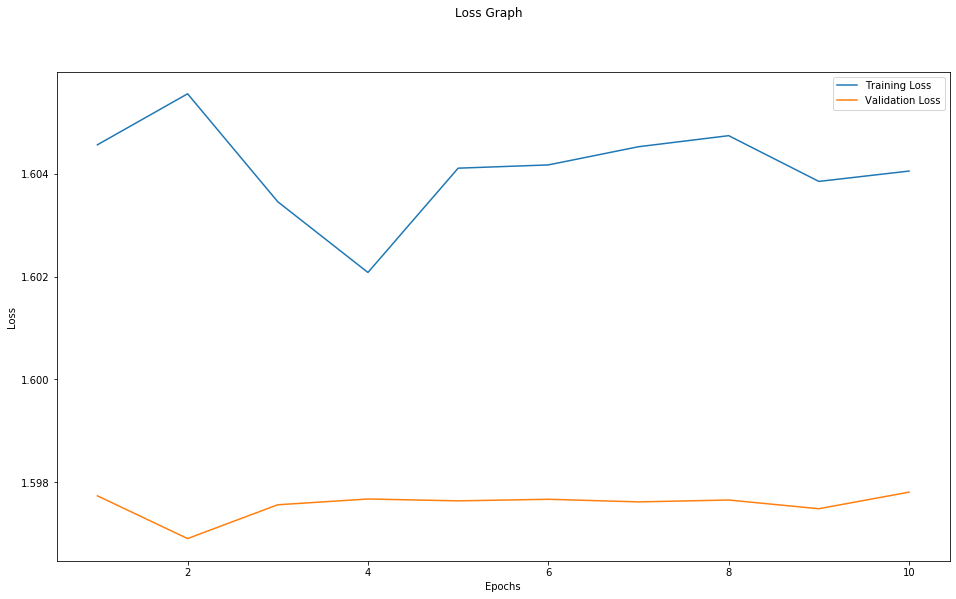

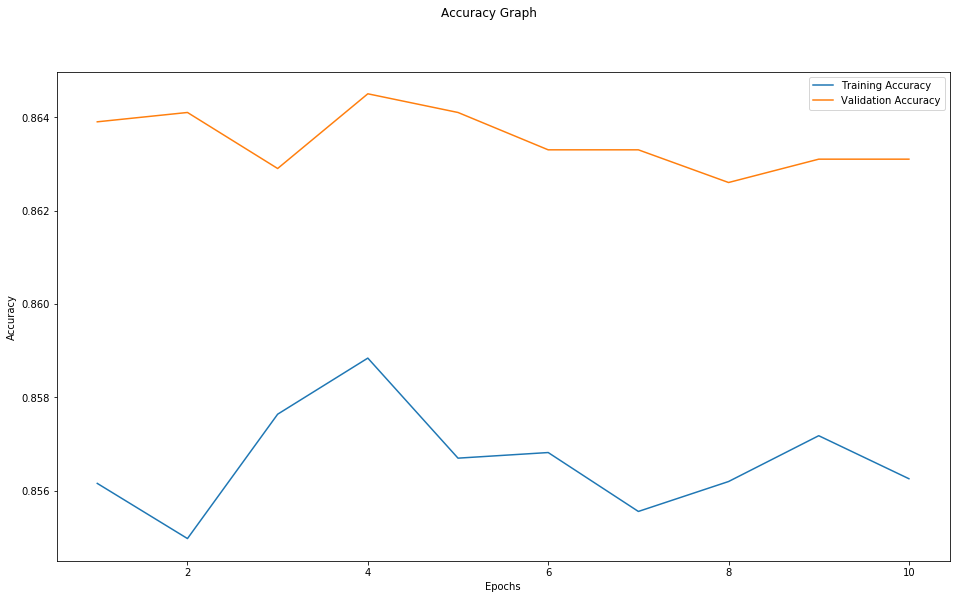

Smooth curve graphs of above graphs


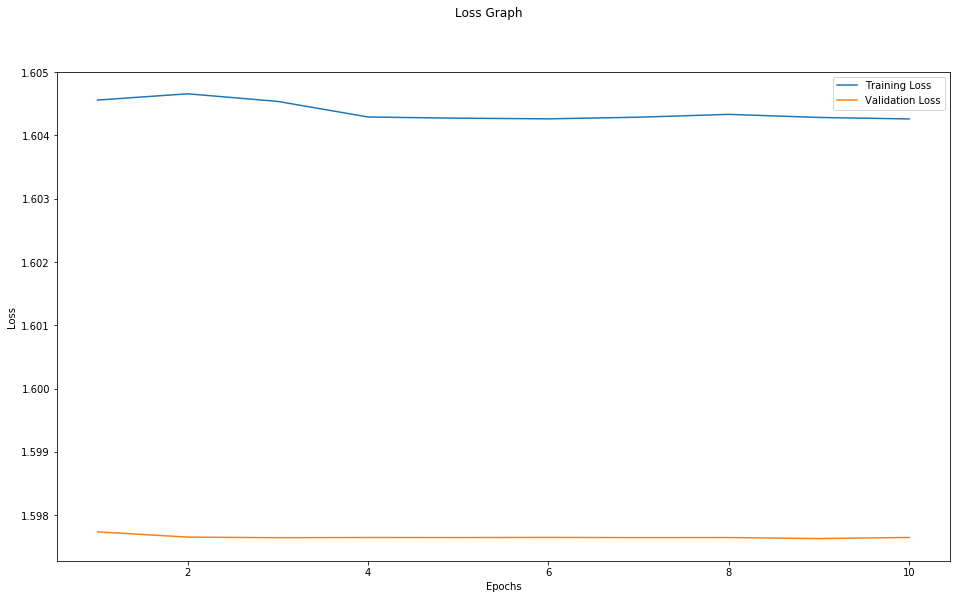

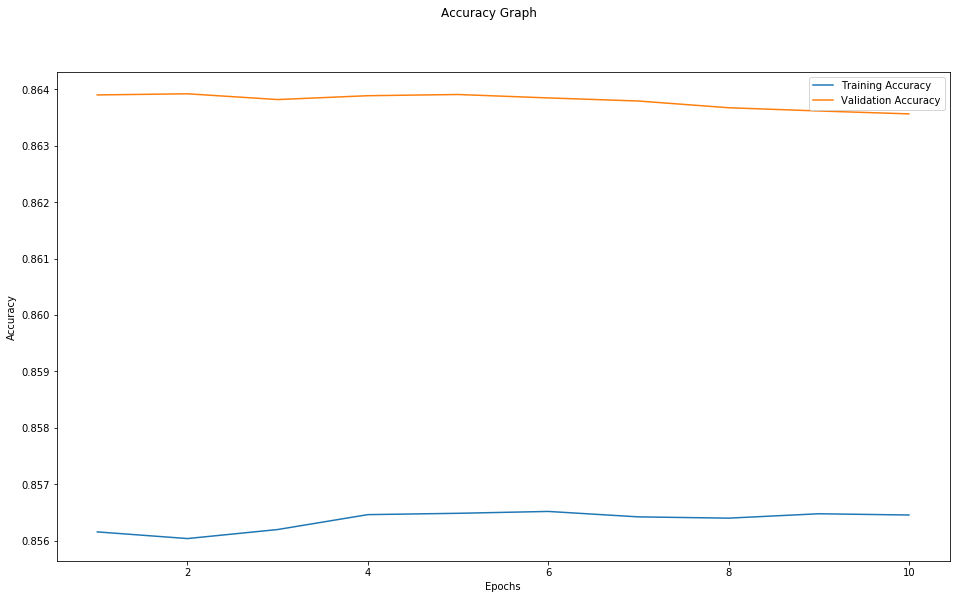

In [84]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

4.3 Use the same base model (without the classification layers) in 4.2, and add a new classifier layer, and train the new classifier layer from scratch. Show both your training and validation curves.

In [85]:
model4.save("model4.2.h5")
model4.layers.pop()
model4 = Model(inputs=model4.inputs, outputs=model4.layers[-2].output)
model4.summary()
new_model = keras.Sequential()
new_model.add(model4)
new_model.add(layers.Dense(10, activation = 'softmax'))

rmsprop = keras.optimizers.RMSprop(learning_rate=0.0003, decay = 1e-6)
los = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
new_model.compile(optimizer = rmsprop, loss = los, metrics = ['accuracy'])

new_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_159_input (InputLayer [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_35 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 16, 16, 32)        0   

In [86]:
batch_size = 64
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
steps = int(train_data.shape[0] / batch_size)
datagen.fit(train_data)
it_train = datagen.flow(train_data, train_labels, batch_size=64)

num_epochs = 10
all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

def lr_schedule(epoch):
    lrate = 0.0003
    return lrate


history = new_model.fit_generator(it_train, epochs=num_epochs, steps_per_epoch=steps, 
                               validation_data=(test_data, test_labels),
                               callbacks=[keras.callbacks.LearningRateScheduler(lr_schedule)])

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

  ...
    to  
  ['...']
Train for 781 steps, validate on 10000 samples
Epoch 1/10
781/781 [==============================] - 27s 35ms/step - loss: 1.8391 - accuracy: 0.6326 - val_loss: 1.6065 - val_accuracy: 0.8601
Epoch 2/10
781/781 [==============================] - 29s 37ms/step - loss: 1.6327 - accuracy: 0.8365 - val_loss: 1.6019 - val_accuracy: 0.8612
Epoch 3/10
781/781 [==============================] - 29s 38ms/step - loss: 1.6207 - accuracy: 0.8456 - val_loss: 1.6005 - val_accuracy: 0.8629
Epoch 4/10
781/781 [==============================] - 28s 35ms/step - loss: 1.6158 - accuracy: 0.8493 - val_loss: 1.6006 - val_accuracy: 0.8618
Epoch 5/10
781/781 [==============================] - 30s 39ms/step - loss: 1.6127 - accuracy: 0.8521 - val_loss: 1.6003 - val_accuracy: 0.8613
Epoch 6/10
781/781 [==============================] - 28s 36ms/step - loss: 1.6122 - accuracy: 0.8525 - val_loss: 1.5995 - val_accuracy: 0.8628
Epoch 7/10
781/781 [==============================] - 28s 36ms/s

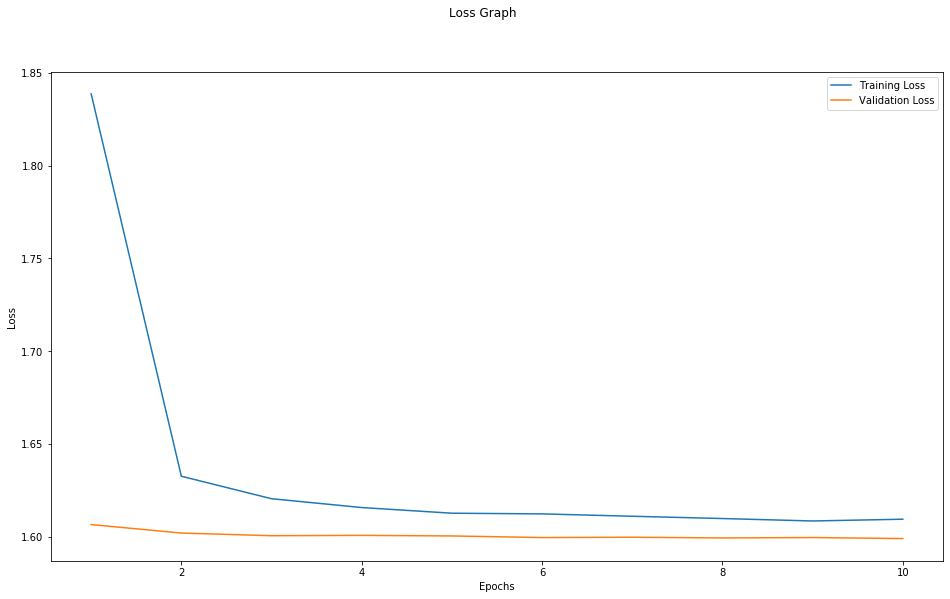

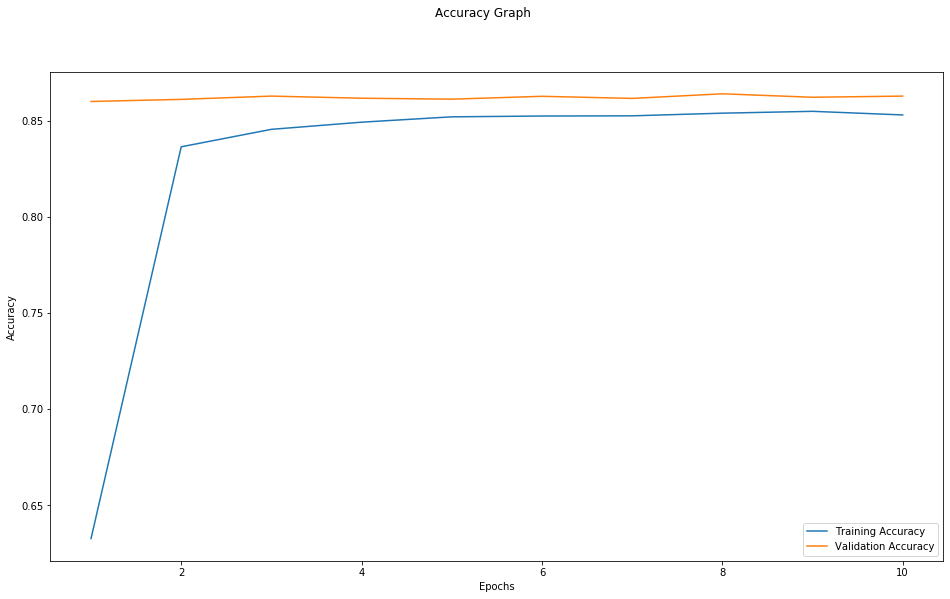

Smooth curve graphs of above graphs


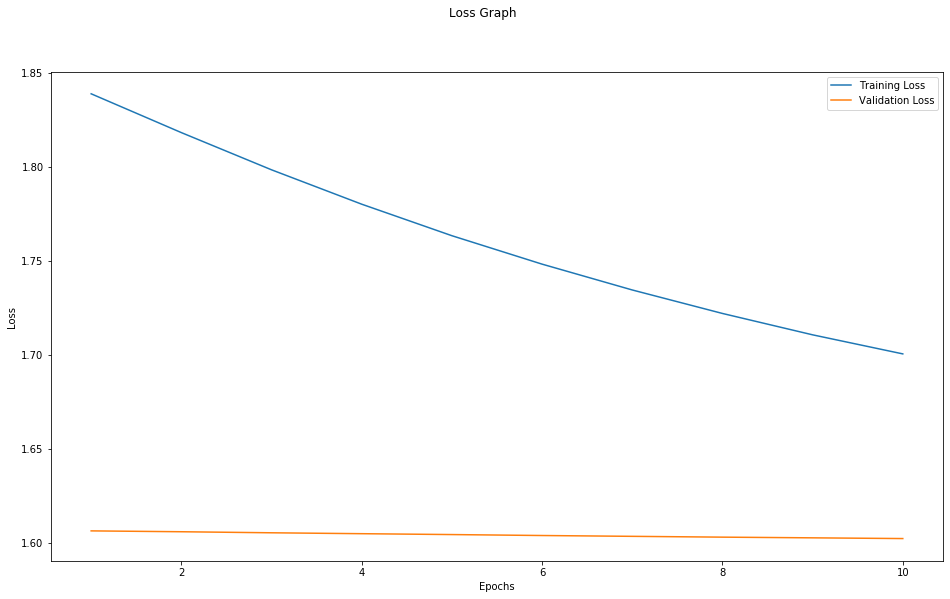

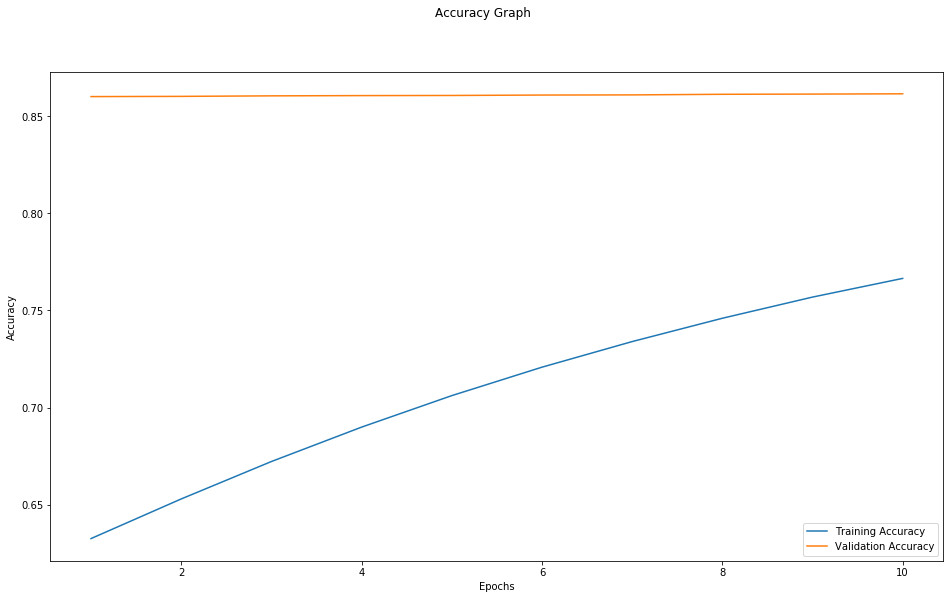

In [87]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

4.4 Compare the testing accuracy for the three models above.

In [88]:
tmodel = load_model("model4.1.h5")
test_mse_score, test_acc_score = tmodel.evaluate(test_data, test_labels)
model4 = load_model("model4.2.h5")
test_mse_score, test_acc_score = model4.evaluate(test_data, test_labels)
test_mse_score, test_acc_score = new_model.evaluate(test_data, test_labels)

10000/10000 [==============================] - 2s 159us/sample - loss: 1.5989 - accuracy: 0.8629
